In [13]:
import os
import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### データ読込

In [14]:
in_dir = '../../data/val_1/skip'

df_train_X = pd.read_excel(os.path.join(in_dir, 'train_X.xlsx'), header=0, index_col=0)
df_train_Y = pd.read_excel(os.path.join(in_dir, 'train_Y.xlsx'), header=0, index_col=0)

df_val_X = pd.read_excel(os.path.join(in_dir, 'val_X.xlsx'), header=0, index_col=0)
df_val_Y = pd.read_excel(os.path.join(in_dir, 'val_Y.xlsx'), header=0, index_col=0)

In [15]:
def sales_sum(row):
    #print(row)
    return sum(v for i, v in row.items() if 'Sales' in i) 

df_train_Y['Sales'] = df_train_Y.apply(lambda x: sales_sum(x), axis=1)
df_train_Y.head()

,SalesRent,SalesRyutsu,SalesSck,SalesMansionBkn,SalesMansionKen,SalesKodateBkn,SalesKodateKen,Impressions,Clicks,Cost,Sales
2018-02-23,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2011,12,137.569992,0.000000
2018-02-24,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1660,12,135.479992,0.000000
2018-02-25,0.0,0.0,26.378694,0.0,0.0,0.0,0.0,1576,16,180.639992,26.378694
2018-02-26,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1518,19,214.509981,0.000000
2018-02-27,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1980,12,137.739990,0.000000


In [16]:
df_val_Y['Sales'] = df_val_Y.apply(lambda x: sales_sum(x), axis=1)
df_val_Y.head()

,SalesRent,SalesRyutsu,SalesSck,SalesMansionBkn,SalesMansionKen,SalesKodateBkn,SalesKodateKen,Impressions,Clicks,Cost,Sales
2019-11-05,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,26219,178,4450.0,0.000000
2019-11-06,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,27150,172,4300.0,0.000000
2019-11-07,0.0,0.0,0.0,0.0,0.0,0.0,47250.217596,29038,198,4950.0,47250.217596
2019-11-08,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,32092,224,5885.0,0.000000
2019-11-09,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,36651,291,8730.0,0.000000


### 目的変数の分布

[]

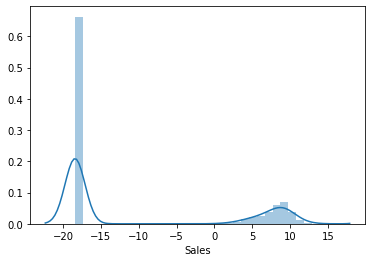

In [17]:
sns.distplot(np.log(df_train_Y['Sales'] + 0.00000001))
plt.plot()

In [18]:
def log(x):
    return np.log(x + 0.00000001)

#for c in ['Sales', 'Impressions', 'Clicks', 'Cost']:
for c in ['Sales']:
    df_train_Y['Sales_log'] = df_train_Y['Sales'].apply(log)
    df_val_Y['Sales_log'] = df_val_Y['Sales'].apply(log)

### データ構造転換

In [19]:
d_train_sales = xgb.DMatrix(df_train_X, label=df_train_Y['Sales_log'])
d_val_sales = xgb.DMatrix(df_val_X, label=df_val_Y['Sales_log'])

d_val = xgb.DMatrix(df_val_X)

/Users/dushu/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/dushu/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


### パラメータのベイズ最適化

In [20]:
def score(params):
    print("Training with params: ")
    print(params)

    evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
    evals_result = {}

    model = xgb.train(params, 
              d_train_sales, 
              num_boost_round=1000, 
              evals=evals,
              early_stopping_rounds=20,
              evals_result=evals_result)
    
    d_pred = np.exp(model.predict(d_val))
    loss = mean_squared_error(d_pred, df_val_Y['Sales'].values)
    print(f'loss: {loss}')
    return {'loss': loss, 'status': STATUS_OK}

def optimize(random_state=71):
    
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'learning_rate': hp.quniform('eta', 0.025, 0.5, 0.025),
        'max_depth':  hp.choice('max_depth', np.arange(3, 10, dtype=int)),
        'min_child_weight': hp.loguniform('min_child_weight', np.log(0.1), np.log(10)),
        'subsample': hp.quniform('subsample', 0.6, 0.95, 0.05),
        'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1.0)),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.6, 0.95, 0.05),
        'alpha': hp.loguniform('alpha', np.log(1e-8), np.log(1.0)),
        'lambda': hp.loguniform('lambda', np.log(1e-6), np.log(10.0)),
        'nthread': 4,
        'seed': random_state
    }
    best = fmin(score, space, 
                algo=tpe.suggest, 
                max_evals=250)
    return best
optimize()

Training with params:                                
{'alpha': 0.04444400741757039, 'colsample_bytree': 0.7000000000000001, 'gamma': 2.8988163403483116e-08, 'lambda': 0.01143329422397114, 'learning_rate': 0.30000000000000004, 'max_depth': 9, 'min_child_weight': 0.16126713889410169, 'n_estimators': 767.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:12.5386	eval-rmse:12.0685             

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.

[1]	train-rmse:10.0833	eval-rmse:10.3603             

[2]	train-rmse:8.58632	eval-rmse:9.40846             

[3]	train-rmse:7.70012	eval-rmse:8.9456              

[4]	train-rmse:7.18088	eval-rmse:8.70042             

[5]	train-rmse:6.86842	eval-rmse:8.62355             

[6]	train-rmse:6.66819	eval-rmse:8.56259             

[7]	train-rmse:6.53929	eval-rmse:8.55825             

[8]	train-rmse:6.44057	eval-rmse:8.54807         

[25]	train-rmse:6.99196	eval-rmse:8.46295                                   

[26]	train-rmse:6.93353	eval-rmse:8.43822                                   

[27]	train-rmse:6.88171	eval-rmse:8.41981                                   

[28]	train-rmse:6.83854	eval-rmse:8.40578                                   

[29]	train-rmse:6.797	eval-rmse:8.39242                                     

[30]	train-rmse:6.75767	eval-rmse:8.38177                                   

[31]	train-rmse:6.72614	eval-rmse:8.36872                                   

[32]	train-rmse:6.69271	eval-rmse:8.35683                                   

[33]	train-rmse:6.66186	eval-rmse:8.35177                                   

[34]	train-rmse:6.63631	eval-rmse:8.34579                                   

[35]	train-rmse:6.61411	eval-rmse:8.33928                                   

[36]	train-rmse:6.59169	eval-rmse:8.33395                                   

[37]	train-rmse:6.57172	eval-rmse:8.33135                       

[6]	train-rmse:11.3498	eval-rmse:11.1239                                       

[7]	train-rmse:10.8882	eval-rmse:10.7906                                       

[8]	train-rmse:10.4726	eval-rmse:10.4827                                       

[9]	train-rmse:10.0975	eval-rmse:10.2123                                       

[10]	train-rmse:9.76911	eval-rmse:9.98517                                      

[11]	train-rmse:9.47417	eval-rmse:9.77887                                      

[12]	train-rmse:9.21247	eval-rmse:9.59784                                      

[13]	train-rmse:8.98188	eval-rmse:9.43728                                      

[14]	train-rmse:8.77634	eval-rmse:9.30191                                      

[15]	train-rmse:8.59466	eval-rmse:9.17889                                      

[16]	train-rmse:8.43429	eval-rmse:9.07245                                      

[17]	train-rmse:8.29426	eval-rmse:8.98417                                      

[18]	train-rmse:8.16989	eval

[9]	train-rmse:8.30762	eval-rmse:9.00579                                        

[10]	train-rmse:8.07863	eval-rmse:8.86155                                       

[11]	train-rmse:7.89673	eval-rmse:8.75127                                       

[12]	train-rmse:7.7524	eval-rmse:8.66563                                        

[13]	train-rmse:7.63538	eval-rmse:8.59786                                       

[14]	train-rmse:7.54294	eval-rmse:8.54804                                       

[15]	train-rmse:7.46725	eval-rmse:8.5087                                        

[16]	train-rmse:7.40662	eval-rmse:8.47319                                       

[17]	train-rmse:7.35631	eval-rmse:8.43894                                       

[18]	train-rmse:7.31764	eval-rmse:8.41959                                       

[19]	train-rmse:7.28622	eval-rmse:8.40949                                       

[20]	train-rmse:7.25718	eval-rmse:8.39671                                       

[21]	train-rmse:

{'alpha': 0.0023905422280858317, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.02110935876170482, 'lambda': 0.0008296534862423373, 'learning_rate': 0.275, 'max_depth': 6, 'min_child_weight': 0.6457782002982894, 'n_estimators': 961.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:12.9146	eval-rmse:12.3293                                        

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                        

[1]	train-rmse:10.6559	eval-rmse:10.6308                                        

[2]	train-rmse:9.22003	eval-rmse:9.64481                                        

[3]	train-rmse:8.34389	eval-rmse:9.07019                                        

[4]	train-rmse:7.82664	eval-rmse:8.73829                                        

[5]	train-rmse:7.51482	eval-rmse:8.55677                                        

[6]	train-rmse:7.3348	eval-rmse:8.47056  

[14]	train-rmse:6.5139	eval-rmse:8.57089                                      

[15]	train-rmse:6.50236	eval-rmse:8.57065                                     

[16]	train-rmse:6.48693	eval-rmse:8.56777                                     

[17]	train-rmse:6.47585	eval-rmse:8.60513                                     

[18]	train-rmse:6.46214	eval-rmse:8.60439                                     

[19]	train-rmse:6.4514	eval-rmse:8.61672                                      

[20]	train-rmse:6.43546	eval-rmse:8.63437                                     

[21]	train-rmse:6.41758	eval-rmse:8.65816                                     

[22]	train-rmse:6.38935	eval-rmse:8.64433                                     

[23]	train-rmse:6.36945	eval-rmse:8.64479                                     

[24]	train-rmse:6.35233	eval-rmse:8.65124                                     

[25]	train-rmse:6.33609	eval-rmse:8.6654                                      

[26]	train-rmse:6.32238	eval-rmse:8.6787

[78]	train-rmse:7.18233	eval-rmse:8.36876                                      

[79]	train-rmse:7.17847	eval-rmse:8.37096                                      

Stopping. Best iteration:                                                      
[59]	train-rmse:7.22443	eval-rmse:8.3469


loss: 1491727785.0576925                                                       
Training with params:                                                          
{'alpha': 0.01012058949044075, 'colsample_bytree': 0.75, 'gamma': 0.05336451164117455, 'lambda': 0.158562006940559, 'learning_rate': 0.25, 'max_depth': 3, 'min_child_weight': 0.7664767365625861, 'n_estimators': 730.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:13.3848	eval-rmse:12.6726                                       

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                       

[1]	train-rmse:11.3249	eval-r

loss: 36457948909.02089                                                        
Training with params:                                                          
{'alpha': 8.028854436283925e-07, 'colsample_bytree': 0.8, 'gamma': 5.095895928164059e-07, 'lambda': 1.0131151223303487, 'learning_rate': 0.35000000000000003, 'max_depth': 7, 'min_child_weight': 0.12837727307808716, 'n_estimators': 616.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:12.0029	eval-rmse:11.6045                                       

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                       

[1]	train-rmse:9.55067	eval-rmse:9.83536                                       

[2]	train-rmse:8.24695	eval-rmse:8.9737                                        

[3]	train-rmse:7.58901	eval-rmse:8.59447                                       

[4]	train-rmse:7.25638	eval-rmse:8.42211           

Will train until eval-rmse hasn't improved in 20 rounds.                       

[1]	train-rmse:11.7368	eval-rmse:11.3994                                       

[2]	train-rmse:10.3597	eval-rmse:10.3734                                       

[3]	train-rmse:9.40325	eval-rmse:9.70543                                       

[4]	train-rmse:8.74239	eval-rmse:9.26491                                       

[5]	train-rmse:8.29437	eval-rmse:8.96481                                       

[6]	train-rmse:8.0049	eval-rmse:8.794                                          

[7]	train-rmse:7.81184	eval-rmse:8.66767                                       

[8]	train-rmse:7.67984	eval-rmse:8.58687                                       

[9]	train-rmse:7.59091	eval-rmse:8.52924                                       

[10]	train-rmse:7.53127	eval-rmse:8.49091                                      

[11]	train-rmse:7.49017	eval-rmse:8.46864                                      

[12]	train-rmse:7.46126	eval

loss: 1606722303.689405                                                        
Training with params:                                                          
{'alpha': 1.545961611682221e-05, 'colsample_bytree': 0.9, 'gamma': 0.018622339633925046, 'lambda': 9.197273560228359, 'learning_rate': 0.025, 'max_depth': 9, 'min_child_weight': 0.1031131081764235, 'n_estimators': 574.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8500000000000001}
[0]	train-rmse:15.9848	eval-rmse:14.7323                                       

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                       

[1]	train-rmse:15.666	eval-rmse:14.4828                                        

[2]	train-rmse:15.3586	eval-rmse:14.2433                                       

[3]	train-rmse:15.0571	eval-rmse:14.0128                                       

[4]	train-rmse:14.7673	eval-rmse:13.7877                            

[93]	train-rmse:6.54851	eval-rmse:8.35899                                      

[94]	train-rmse:6.53478	eval-rmse:8.35482                                      

[95]	train-rmse:6.52167	eval-rmse:8.35077                                      

[96]	train-rmse:6.50848	eval-rmse:8.3464                                       

[97]	train-rmse:6.49529	eval-rmse:8.3425                                       

[98]	train-rmse:6.48411	eval-rmse:8.33881                                      

[99]	train-rmse:6.47228	eval-rmse:8.33544                                      

[100]	train-rmse:6.4602	eval-rmse:8.33314                                      

[101]	train-rmse:6.44935	eval-rmse:8.32892                                     

[102]	train-rmse:6.43884	eval-rmse:8.32569                                     

[103]	train-rmse:6.42864	eval-rmse:8.32218                                     

[104]	train-rmse:6.41727	eval-rmse:8.31989                                     

[105]	train-rmse:6.40724	eva

[194]	train-rmse:5.96665	eval-rmse:8.23094                                     

[195]	train-rmse:5.96331	eval-rmse:8.22994                                     

[196]	train-rmse:5.9619	eval-rmse:8.22969                                      

[197]	train-rmse:5.95984	eval-rmse:8.23009                                     

[198]	train-rmse:5.95815	eval-rmse:8.22977                                     

[199]	train-rmse:5.95595	eval-rmse:8.22966                                     

[200]	train-rmse:5.95439	eval-rmse:8.22954                                     

[201]	train-rmse:5.95008	eval-rmse:8.22893                                     

[202]	train-rmse:5.94769	eval-rmse:8.22858                                     

[203]	train-rmse:5.94595	eval-rmse:8.2284                                      

[204]	train-rmse:5.94041	eval-rmse:8.22857                                     

[205]	train-rmse:5.93789	eval-rmse:8.2275                                      

[206]	train-rmse:5.93597	eva

[295]	train-rmse:5.77564	eval-rmse:8.21486                                     

[296]	train-rmse:5.77304	eval-rmse:8.21495                                     

[297]	train-rmse:5.77263	eval-rmse:8.21507                                     

[298]	train-rmse:5.7714	eval-rmse:8.21479                                      

[299]	train-rmse:5.77057	eval-rmse:8.21479                                     

[300]	train-rmse:5.76794	eval-rmse:8.21436                                     

[301]	train-rmse:5.76683	eval-rmse:8.21473                                     

[302]	train-rmse:5.76352	eval-rmse:8.21434                                     

[303]	train-rmse:5.76293	eval-rmse:8.21476                                     

[304]	train-rmse:5.76201	eval-rmse:8.21392                                     

[305]	train-rmse:5.76099	eval-rmse:8.21388                                     

[306]	train-rmse:5.76038	eval-rmse:8.21379                                     

[307]	train-rmse:5.75855	eva

[0]	train-rmse:15.6911	eval-rmse:14.4874                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                         

[1]	train-rmse:15.1068	eval-rmse:14.0177                                         

[2]	train-rmse:14.5576	eval-rmse:13.5808                                         

[3]	train-rmse:14.0402	eval-rmse:13.1755                                         

[4]	train-rmse:13.556	eval-rmse:12.7983                                          

[5]	train-rmse:13.1013	eval-rmse:12.4443                                         

[6]	train-rmse:12.6767	eval-rmse:12.1181                                         

[7]	train-rmse:12.2765	eval-rmse:11.8101                                         

[8]	train-rmse:11.9049	eval-rmse:11.5253                                         

[9]	train-rmse:11.5584	eval-rmse:11.267                                          



[96]	train-rmse:7.19679	eval-rmse:8.32872                                        

[97]	train-rmse:7.19524	eval-rmse:8.32977                                        

[98]	train-rmse:7.19336	eval-rmse:8.32995                                        

[99]	train-rmse:7.19181	eval-rmse:8.32949                                        

[100]	train-rmse:7.1902	eval-rmse:8.32849                                        

[101]	train-rmse:7.18875	eval-rmse:8.32947                                       

[102]	train-rmse:7.18723	eval-rmse:8.32942                                       

[103]	train-rmse:7.18616	eval-rmse:8.32859                                       

[104]	train-rmse:7.1846	eval-rmse:8.32794                                        

[105]	train-rmse:7.1832	eval-rmse:8.3279                                         

[106]	train-rmse:7.18149	eval-rmse:8.32765                                       

[107]	train-rmse:7.18062	eval-rmse:8.32759                                       

[108

[32]	train-rmse:7.28297	eval-rmse:8.37318                                        

[33]	train-rmse:7.27439	eval-rmse:8.37072                                        

[34]	train-rmse:7.26677	eval-rmse:8.3657                                         

[35]	train-rmse:7.25893	eval-rmse:8.35977                                        

[36]	train-rmse:7.25252	eval-rmse:8.35479                                        

[37]	train-rmse:7.24674	eval-rmse:8.35326                                        

[38]	train-rmse:7.24192	eval-rmse:8.3536                                         

[39]	train-rmse:7.23666	eval-rmse:8.35277                                        

[40]	train-rmse:7.23213	eval-rmse:8.35374                                        

[41]	train-rmse:7.22704	eval-rmse:8.35247                                        

[42]	train-rmse:7.22287	eval-rmse:8.35075                                        

[43]	train-rmse:7.21843	eval-rmse:8.34874                                        

[44]

[34]	train-rmse:9.6545	eval-rmse:9.89482                                         

[35]	train-rmse:9.55836	eval-rmse:9.82737                                        

[36]	train-rmse:9.46636	eval-rmse:9.76455                                        

[37]	train-rmse:9.37753	eval-rmse:9.70407                                        

[38]	train-rmse:9.29327	eval-rmse:9.6455                                         

[39]	train-rmse:9.21133	eval-rmse:9.58853                                        

[40]	train-rmse:9.13257	eval-rmse:9.53607                                        

[41]	train-rmse:9.05554	eval-rmse:9.48527                                        

[42]	train-rmse:8.98287	eval-rmse:9.43561                                        

[43]	train-rmse:8.91312	eval-rmse:9.38721                                        

[44]	train-rmse:8.84522	eval-rmse:9.34211                                        

[45]	train-rmse:8.78163	eval-rmse:9.29867                                        

[46]

[132]	train-rmse:7.2825	eval-rmse:8.36496                                        

[133]	train-rmse:7.28019	eval-rmse:8.36435                                       

[134]	train-rmse:7.27785	eval-rmse:8.36347                                       

[135]	train-rmse:7.27555	eval-rmse:8.36233                                       

[136]	train-rmse:7.27313	eval-rmse:8.36099                                       

[137]	train-rmse:7.27097	eval-rmse:8.36067                                       

[138]	train-rmse:7.26858	eval-rmse:8.35888                                       

[139]	train-rmse:7.26668	eval-rmse:8.35762                                       

[140]	train-rmse:7.26485	eval-rmse:8.35737                                       

[141]	train-rmse:7.26276	eval-rmse:8.35641                                       

[142]	train-rmse:7.26098	eval-rmse:8.35556                                       

[143]	train-rmse:7.25902	eval-rmse:8.35478                                       

[144

[230]	train-rmse:7.17136	eval-rmse:8.32724                                       

[231]	train-rmse:7.17064	eval-rmse:8.32684                                       

[232]	train-rmse:7.17004	eval-rmse:8.32694                                       

[233]	train-rmse:7.16962	eval-rmse:8.32669                                       

[234]	train-rmse:7.16921	eval-rmse:8.32709                                       

[235]	train-rmse:7.16856	eval-rmse:8.32672                                       

[236]	train-rmse:7.16773	eval-rmse:8.32602                                       

[237]	train-rmse:7.16727	eval-rmse:8.32579                                       

[238]	train-rmse:7.16658	eval-rmse:8.32554                                       

[239]	train-rmse:7.16601	eval-rmse:8.32533                                       

[240]	train-rmse:7.1657	eval-rmse:8.32531                                        

[241]	train-rmse:7.16542	eval-rmse:8.32536                                       

[242

[328]	train-rmse:7.12563	eval-rmse:8.31828                                       

[329]	train-rmse:7.12501	eval-rmse:8.31831                                       

[330]	train-rmse:7.12467	eval-rmse:8.31804                                       

[331]	train-rmse:7.12417	eval-rmse:8.31806                                       

[332]	train-rmse:7.12398	eval-rmse:8.31837                                       

[333]	train-rmse:7.12352	eval-rmse:8.31742                                       

[334]	train-rmse:7.12326	eval-rmse:8.31779                                       

[335]	train-rmse:7.12289	eval-rmse:8.31744                                       

[336]	train-rmse:7.12249	eval-rmse:8.31725                                       

[337]	train-rmse:7.12191	eval-rmse:8.31699                                       

[338]	train-rmse:7.1216	eval-rmse:8.317                                          

[339]	train-rmse:7.12125	eval-rmse:8.31684                                       

[340

[57]	train-rmse:8.18163	eval-rmse:8.90914                                        

[58]	train-rmse:8.14386	eval-rmse:8.88513                                        

[59]	train-rmse:8.10804	eval-rmse:8.8625                                         

[60]	train-rmse:8.07315	eval-rmse:8.83941                                        

[61]	train-rmse:8.03933	eval-rmse:8.81723                                        

[62]	train-rmse:8.00711	eval-rmse:8.79667                                        

[63]	train-rmse:7.97608	eval-rmse:8.77641                                        

[64]	train-rmse:7.94738	eval-rmse:8.75781                                        

[65]	train-rmse:7.9193	eval-rmse:8.73915                                         

[66]	train-rmse:7.89209	eval-rmse:8.72116                                        

[67]	train-rmse:7.86618	eval-rmse:8.70515                                        

[68]	train-rmse:7.84127	eval-rmse:8.69039                                        

[69]

[155]	train-rmse:7.2386	eval-rmse:8.34368                                        

[156]	train-rmse:7.23697	eval-rmse:8.34366                                       

[157]	train-rmse:7.23552	eval-rmse:8.34301                                       

[158]	train-rmse:7.23406	eval-rmse:8.34278                                       

[159]	train-rmse:7.23288	eval-rmse:8.34274                                       

[160]	train-rmse:7.23159	eval-rmse:8.34216                                       

[161]	train-rmse:7.23017	eval-rmse:8.34174                                       

[162]	train-rmse:7.22852	eval-rmse:8.34105                                       

[163]	train-rmse:7.2272	eval-rmse:8.34029                                        

[164]	train-rmse:7.22605	eval-rmse:8.33952                                       

[165]	train-rmse:7.22455	eval-rmse:8.33818                                       

[166]	train-rmse:7.22342	eval-rmse:8.33821                                       

[167

[253]	train-rmse:7.15718	eval-rmse:8.32028                                       

[254]	train-rmse:7.15666	eval-rmse:8.32023                                       

[255]	train-rmse:7.15636	eval-rmse:8.32021                                       

[256]	train-rmse:7.15592	eval-rmse:8.32049                                       

[257]	train-rmse:7.15516	eval-rmse:8.32028                                       

[258]	train-rmse:7.15468	eval-rmse:8.31986                                       

[259]	train-rmse:7.15428	eval-rmse:8.31997                                       

[260]	train-rmse:7.15362	eval-rmse:8.31992                                       

[261]	train-rmse:7.15292	eval-rmse:8.31978                                       

[262]	train-rmse:7.15245	eval-rmse:8.31963                                       

[263]	train-rmse:7.15177	eval-rmse:8.31957                                       

[264]	train-rmse:7.1513	eval-rmse:8.31947                                        

[265

[351]	train-rmse:7.11406	eval-rmse:8.31141                                       

[352]	train-rmse:7.11371	eval-rmse:8.31123                                       

[353]	train-rmse:7.11332	eval-rmse:8.31095                                       

[354]	train-rmse:7.1128	eval-rmse:8.31107                                        

[355]	train-rmse:7.11255	eval-rmse:8.31139                                       

[356]	train-rmse:7.11226	eval-rmse:8.31109                                       

[357]	train-rmse:7.11196	eval-rmse:8.31113                                       

[358]	train-rmse:7.11142	eval-rmse:8.31089                                       

[359]	train-rmse:7.11087	eval-rmse:8.3113                                        

[360]	train-rmse:7.1102	eval-rmse:8.31126                                        

[361]	train-rmse:7.1099	eval-rmse:8.31121                                        

[362]	train-rmse:7.10968	eval-rmse:8.31145                                       

[363

[5]	train-rmse:9.07429	eval-rmse:9.56994                                         

[6]	train-rmse:8.56831	eval-rmse:9.23554                                         

[7]	train-rmse:8.17426	eval-rmse:8.98792                                         

[8]	train-rmse:7.86796	eval-rmse:8.81445                                         

[9]	train-rmse:7.63258	eval-rmse:8.68393                                         

[10]	train-rmse:7.45197	eval-rmse:8.58745                                        

[11]	train-rmse:7.31247	eval-rmse:8.51377                                        

[12]	train-rmse:7.20395	eval-rmse:8.46003                                        

[13]	train-rmse:7.11931	eval-rmse:8.41757                                        

[14]	train-rmse:7.05522	eval-rmse:8.38887                                        

[15]	train-rmse:6.99767	eval-rmse:8.3699                                         

[16]	train-rmse:6.95251	eval-rmse:8.3527                                         

[17]

[39]	train-rmse:8.629	eval-rmse:9.44086                                         

[40]	train-rmse:8.5389	eval-rmse:9.38744                                        

[41]	train-rmse:8.4517	eval-rmse:9.33489                                        

[42]	train-rmse:8.36771	eval-rmse:9.28595                                       

[43]	train-rmse:8.28732	eval-rmse:9.23873                                       

[44]	train-rmse:8.20914	eval-rmse:9.19209                                       

[45]	train-rmse:8.134	eval-rmse:9.14821                                         

[46]	train-rmse:8.06121	eval-rmse:9.10698                                       

[47]	train-rmse:7.99093	eval-rmse:9.06758                                       

[48]	train-rmse:7.9235	eval-rmse:9.03032                                        

[49]	train-rmse:7.85628	eval-rmse:8.99489                                       

[50]	train-rmse:7.7938	eval-rmse:8.95837                                        

[51]	train-rmse:

[138]	train-rmse:6.02346	eval-rmse:8.24687                                      

[139]	train-rmse:6.01798	eval-rmse:8.24632                                      

[140]	train-rmse:6.01225	eval-rmse:8.24597                                      

[141]	train-rmse:6.00739	eval-rmse:8.24502                                      

[142]	train-rmse:6.002	eval-rmse:8.24385                                        

[143]	train-rmse:5.99787	eval-rmse:8.24295                                      

[144]	train-rmse:5.99169	eval-rmse:8.2415                                       

[145]	train-rmse:5.98692	eval-rmse:8.24124                                      

[146]	train-rmse:5.98176	eval-rmse:8.24057                                      

[147]	train-rmse:5.9769	eval-rmse:8.24122                                       

[148]	train-rmse:5.97294	eval-rmse:8.24174                                      

[149]	train-rmse:5.96782	eval-rmse:8.24128                                      

[150]	train-rmse

[1]	train-rmse:12.7516	eval-rmse:12.266                                          

[2]	train-rmse:11.4287	eval-rmse:11.3136                                         

[3]	train-rmse:10.3591	eval-rmse:10.5877                                         

[4]	train-rmse:9.49883	eval-rmse:10.0297                                         

[5]	train-rmse:8.80976	eval-rmse:9.5913                                          

[6]	train-rmse:8.2606	eval-rmse:9.25952                                          

[7]	train-rmse:7.827	eval-rmse:9.02844                                           

[8]	train-rmse:7.4829	eval-rmse:8.85652                                          

[9]	train-rmse:7.21378	eval-rmse:8.73027                                         

[10]	train-rmse:6.99621	eval-rmse:8.63421                                        

[11]	train-rmse:6.82593	eval-rmse:8.55325                                        

[12]	train-rmse:6.69162	eval-rmse:8.51435                                        

[13]

[48]	train-rmse:8.60005	eval-rmse:9.18449                                       

[49]	train-rmse:8.54516	eval-rmse:9.14715                                       

[50]	train-rmse:8.4919	eval-rmse:9.11253                                        

[51]	train-rmse:8.44158	eval-rmse:9.07987                                       

[52]	train-rmse:8.39279	eval-rmse:9.04905                                       

[53]	train-rmse:8.34612	eval-rmse:9.01795                                       

[54]	train-rmse:8.3024	eval-rmse:8.98853                                        

[55]	train-rmse:8.25932	eval-rmse:8.96093                                       

[56]	train-rmse:8.21771	eval-rmse:8.93381                                       

[57]	train-rmse:8.17835	eval-rmse:8.90782                                       

[58]	train-rmse:8.1402	eval-rmse:8.88397                                        

[59]	train-rmse:8.10469	eval-rmse:8.862                                         

[60]	train-rmse:

[147]	train-rmse:7.24626	eval-rmse:8.35341                                      

[148]	train-rmse:7.24479	eval-rmse:8.35276                                      

[149]	train-rmse:7.24306	eval-rmse:8.35215                                      

[150]	train-rmse:7.24164	eval-rmse:8.35165                                      

[151]	train-rmse:7.24009	eval-rmse:8.35213                                      

[152]	train-rmse:7.2385	eval-rmse:8.35138                                       

[153]	train-rmse:7.23685	eval-rmse:8.35105                                      

[154]	train-rmse:7.2355	eval-rmse:8.35056                                       

[155]	train-rmse:7.23362	eval-rmse:8.34954                                      

[156]	train-rmse:7.23189	eval-rmse:8.34934                                      

[157]	train-rmse:7.2304	eval-rmse:8.34906                                       

[158]	train-rmse:7.22925	eval-rmse:8.34894                                      

[159]	train-rmse

[3]	train-rmse:13.0674	eval-rmse:12.4282                                        

[4]	train-rmse:12.4354	eval-rmse:11.9495                                        

[5]	train-rmse:11.8633	eval-rmse:11.5093                                        

[6]	train-rmse:11.3512	eval-rmse:11.1285                                        

[7]	train-rmse:10.8866	eval-rmse:10.78                                          

[8]	train-rmse:10.4728	eval-rmse:10.4792                                        

[9]	train-rmse:10.1011	eval-rmse:10.2144                                        

[10]	train-rmse:9.76847	eval-rmse:9.98088                                       

[11]	train-rmse:9.47475	eval-rmse:9.77946                                       

[12]	train-rmse:9.21135	eval-rmse:9.59975                                       

[13]	train-rmse:8.97862	eval-rmse:9.4395                                        

[14]	train-rmse:8.7729	eval-rmse:9.29889                                        

[15]	train-rmse:

[5]	train-rmse:8.83249	eval-rmse:9.34661                                        

[6]	train-rmse:8.40879	eval-rmse:9.05513                                        

[7]	train-rmse:8.10258	eval-rmse:8.86062                                        

[8]	train-rmse:7.8783	eval-rmse:8.71918                                         

[9]	train-rmse:7.71684	eval-rmse:8.61493                                        

[10]	train-rmse:7.59749	eval-rmse:8.54311                                       

[11]	train-rmse:7.51248	eval-rmse:8.4955                                        

[12]	train-rmse:7.44935	eval-rmse:8.46589                                       

[13]	train-rmse:7.39979	eval-rmse:8.43293                                       

[14]	train-rmse:7.36388	eval-rmse:8.41119                                       

[15]	train-rmse:7.33657	eval-rmse:8.38665                                       

[16]	train-rmse:7.31227	eval-rmse:8.38077                                       

[17]	train-rmse:

[48]	train-rmse:7.42867	eval-rmse:8.44177                                       

[49]	train-rmse:7.41468	eval-rmse:8.43562                                       

[50]	train-rmse:7.40163	eval-rmse:8.42812                                       

[51]	train-rmse:7.39006	eval-rmse:8.42341                                       

[52]	train-rmse:7.37905	eval-rmse:8.41942                                       

[53]	train-rmse:7.36886	eval-rmse:8.4154                                        

[54]	train-rmse:7.35919	eval-rmse:8.41133                                       

[55]	train-rmse:7.35006	eval-rmse:8.40502                                       

[56]	train-rmse:7.3408	eval-rmse:8.39963                                        

[57]	train-rmse:7.33242	eval-rmse:8.39416                                       

[58]	train-rmse:7.32466	eval-rmse:8.3899                                        

[59]	train-rmse:7.31684	eval-rmse:8.38572                                       

[60]	train-rmse:

[7]	train-rmse:9.74973	eval-rmse:9.9745                                         

[8]	train-rmse:9.34257	eval-rmse:9.69248                                        

[9]	train-rmse:8.99733	eval-rmse:9.45415                                        

[10]	train-rmse:8.70635	eval-rmse:9.26448                                       

[11]	train-rmse:8.45999	eval-rmse:9.10314                                       

[12]	train-rmse:8.25127	eval-rmse:8.96313                                       

[13]	train-rmse:8.07484	eval-rmse:8.84607                                       

[14]	train-rmse:7.92877	eval-rmse:8.76044                                       

[15]	train-rmse:7.80431	eval-rmse:8.6853                                        

[16]	train-rmse:7.69992	eval-rmse:8.61997                                       

[17]	train-rmse:7.61352	eval-rmse:8.56645                                       

[18]	train-rmse:7.54126	eval-rmse:8.52291                                       

[19]	train-rmse:

[106]	train-rmse:6.901	eval-rmse:8.30834                                        

[107]	train-rmse:6.89997	eval-rmse:8.30898                                      

[108]	train-rmse:6.89847	eval-rmse:8.30989                                      

Stopping. Best iteration:                                                       
[88]	train-rmse:6.95277	eval-rmse:8.29536


loss: 1396823140.223455                                                         
Training with params:                                                           
{'alpha': 3.546672180005095e-08, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.00031649478104255085, 'lambda': 0.010975750067200155, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 0.17702572004403022, 'n_estimators': 221.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9500000000000001}
[0]	train-rmse:15.691	eval-rmse:14.4871                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


[87]	train-rmse:7.21434	eval-rmse:8.33238                                       

[88]	train-rmse:7.21215	eval-rmse:8.33108                                       

[89]	train-rmse:7.20939	eval-rmse:8.32866                                       

[90]	train-rmse:7.20712	eval-rmse:8.3283                                        

[91]	train-rmse:7.20525	eval-rmse:8.32671                                       

[92]	train-rmse:7.20348	eval-rmse:8.32771                                       

[93]	train-rmse:7.20158	eval-rmse:8.32839                                       

[94]	train-rmse:7.20002	eval-rmse:8.32978                                       

[95]	train-rmse:7.19817	eval-rmse:8.3316                                        

[96]	train-rmse:7.19622	eval-rmse:8.33079                                       

[97]	train-rmse:7.19458	eval-rmse:8.33161                                       

[98]	train-rmse:7.19226	eval-rmse:8.33038                                       

[99]	train-rmse:

[24]	train-rmse:7.28993	eval-rmse:8.38895                                       

[25]	train-rmse:7.26542	eval-rmse:8.37562                                       

[26]	train-rmse:7.24374	eval-rmse:8.36401                                       

[27]	train-rmse:7.22623	eval-rmse:8.35863                                       

[28]	train-rmse:7.21095	eval-rmse:8.35484                                       

[29]	train-rmse:7.19715	eval-rmse:8.34967                                       

[30]	train-rmse:7.18122	eval-rmse:8.34058                                       

[31]	train-rmse:7.1718	eval-rmse:8.34339                                        

[32]	train-rmse:7.16181	eval-rmse:8.34094                                       

[33]	train-rmse:7.15262	eval-rmse:8.33852                                       

[34]	train-rmse:7.14452	eval-rmse:8.33484                                       

[35]	train-rmse:7.13585	eval-rmse:8.32854                                       

[36]	train-rmse:

[9]	train-rmse:7.12985	eval-rmse:8.58674                                        

[10]	train-rmse:6.9791	eval-rmse:8.53041                                        

[11]	train-rmse:6.86917	eval-rmse:8.4742                                        

[12]	train-rmse:6.78193	eval-rmse:8.4377                                        

[13]	train-rmse:6.71337	eval-rmse:8.41301                                       

[14]	train-rmse:6.65316	eval-rmse:8.40621                                       

[15]	train-rmse:6.60276	eval-rmse:8.40009                                       

[16]	train-rmse:6.56557	eval-rmse:8.38999                                       

[17]	train-rmse:6.53057	eval-rmse:8.38068                                       

[18]	train-rmse:6.5011	eval-rmse:8.37677                                        

[19]	train-rmse:6.47839	eval-rmse:8.38333                                       

[20]	train-rmse:6.45559	eval-rmse:8.37762                                       

[21]	train-rmse:

[7]	train-rmse:8.61446	eval-rmse:9.38993                                        

[8]	train-rmse:8.22485	eval-rmse:9.1532                                         

[9]	train-rmse:7.91009	eval-rmse:8.9738                                         

[10]	train-rmse:7.65024	eval-rmse:8.8321                                        

[11]	train-rmse:7.44036	eval-rmse:8.71469                                       

[12]	train-rmse:7.27151	eval-rmse:8.6283                                        

[13]	train-rmse:7.12966	eval-rmse:8.56704                                       

[14]	train-rmse:7.01316	eval-rmse:8.50818                                       

[15]	train-rmse:6.9136	eval-rmse:8.46598                                        

[16]	train-rmse:6.83101	eval-rmse:8.43375                                       

[17]	train-rmse:6.76195	eval-rmse:8.41521                                       

[18]	train-rmse:6.70578	eval-rmse:8.40669                                       

[19]	train-rmse:

[43]	train-rmse:7.15796	eval-rmse:8.33825                                       

[44]	train-rmse:7.1512	eval-rmse:8.33581                                        

[45]	train-rmse:7.1438	eval-rmse:8.33415                                        

[46]	train-rmse:7.13812	eval-rmse:8.33288                                       

[47]	train-rmse:7.13128	eval-rmse:8.32969                                       

[48]	train-rmse:7.12632	eval-rmse:8.32942                                       

[49]	train-rmse:7.12174	eval-rmse:8.3288                                        

[50]	train-rmse:7.11693	eval-rmse:8.32797                                       

[51]	train-rmse:7.11179	eval-rmse:8.32591                                       

[52]	train-rmse:7.10722	eval-rmse:8.32429                                       

[53]	train-rmse:7.10039	eval-rmse:8.32164                                       

[54]	train-rmse:7.09588	eval-rmse:8.32027                                       

[55]	train-rmse:

[43]	train-rmse:7.11702	eval-rmse:8.3569                                        

[44]	train-rmse:7.11398	eval-rmse:8.35651                                       

[45]	train-rmse:7.11264	eval-rmse:8.35684                                       

[46]	train-rmse:7.10789	eval-rmse:8.35752                                       

[47]	train-rmse:7.10555	eval-rmse:8.35618                                       

[48]	train-rmse:7.10156	eval-rmse:8.35569                                       

[49]	train-rmse:7.09949	eval-rmse:8.35719                                       

[50]	train-rmse:7.09604	eval-rmse:8.36619                                       

[51]	train-rmse:7.09133	eval-rmse:8.37129                                       

[52]	train-rmse:7.08836	eval-rmse:8.36958                                       

[53]	train-rmse:7.08626	eval-rmse:8.36829                                       

[54]	train-rmse:7.08271	eval-rmse:8.36924                                       

[55]	train-rmse:

[27]	train-rmse:7.30186	eval-rmse:8.44603                                       

[28]	train-rmse:7.2647	eval-rmse:8.42969                                        

[29]	train-rmse:7.2321	eval-rmse:8.41385                                        

[30]	train-rmse:7.2012	eval-rmse:8.39873                                        

[31]	train-rmse:7.17396	eval-rmse:8.3891                                        

[32]	train-rmse:7.1505	eval-rmse:8.38113                                        

[33]	train-rmse:7.13038	eval-rmse:8.37252                                       

[34]	train-rmse:7.11073	eval-rmse:8.36479                                       

[35]	train-rmse:7.09288	eval-rmse:8.35736                                       

[36]	train-rmse:7.07606	eval-rmse:8.34658                                       

[37]	train-rmse:7.06115	eval-rmse:8.34161                                       

[38]	train-rmse:7.04598	eval-rmse:8.33395                                       

[39]	train-rmse:

[16]	train-rmse:7.38758	eval-rmse:8.40194                                       

[17]	train-rmse:7.35863	eval-rmse:8.38858                                       

[18]	train-rmse:7.33577	eval-rmse:8.37514                                       

[19]	train-rmse:7.31623	eval-rmse:8.36738                                       

[20]	train-rmse:7.29966	eval-rmse:8.35831                                       

[21]	train-rmse:7.28608	eval-rmse:8.359                                         

[22]	train-rmse:7.27604	eval-rmse:8.35588                                       

[23]	train-rmse:7.26616	eval-rmse:8.35082                                       

[24]	train-rmse:7.25645	eval-rmse:8.35257                                       

[25]	train-rmse:7.24889	eval-rmse:8.34858                                       

[26]	train-rmse:7.24065	eval-rmse:8.33943                                       

[27]	train-rmse:7.23363	eval-rmse:8.33491                                       

[28]	train-rmse:

[53]	train-rmse:7.48809	eval-rmse:8.48918                                       

[54]	train-rmse:7.47727	eval-rmse:8.4809                                        

[55]	train-rmse:7.46753	eval-rmse:8.47365                                       

[56]	train-rmse:7.45887	eval-rmse:8.46906                                       

[57]	train-rmse:7.45	eval-rmse:8.46311                                          

[58]	train-rmse:7.44171	eval-rmse:8.45806                                       

[59]	train-rmse:7.43479	eval-rmse:8.45277                                       

[60]	train-rmse:7.42903	eval-rmse:8.44869                                       

[61]	train-rmse:7.42178	eval-rmse:8.4426                                        

[62]	train-rmse:7.41601	eval-rmse:8.4391                                        

[63]	train-rmse:7.41063	eval-rmse:8.43772                                       

[64]	train-rmse:7.40524	eval-rmse:8.43609                                       

[65]	train-rmse:

[152]	train-rmse:7.26123	eval-rmse:8.37573                                      

[153]	train-rmse:7.26061	eval-rmse:8.37602                                      

[154]	train-rmse:7.26026	eval-rmse:8.37666                                      

Stopping. Best iteration:                                                       
[134]	train-rmse:7.27429	eval-rmse:8.3724


loss: 1361908484.4630342                                                        
Training with params:                                                           
{'alpha': 0.042055544683198345, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.013115999559815588, 'lambda': 0.08549168883638307, 'learning_rate': 0.30000000000000004, 'max_depth': 8, 'min_child_weight': 8.881165159018444, 'n_estimators': 897.0, 'nthread': 4, 'seed': 71, 'subsample': 0.9}
[0]	train-rmse:12.5396	eval-rmse:12.0462                                        

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will

[0]	train-rmse:14.7462	eval-rmse:13.7331                                        

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                        

[1]	train-rmse:13.4147	eval-rmse:12.6947                                        

[2]	train-rmse:12.2939	eval-rmse:11.8317                                        

[3]	train-rmse:11.3541	eval-rmse:11.1264                                        

[4]	train-rmse:10.5687	eval-rmse:10.5391                                        

[5]	train-rmse:9.917	eval-rmse:10.0714                                          

[6]	train-rmse:9.38071	eval-rmse:9.70184                                        

[7]	train-rmse:8.94671	eval-rmse:9.40466                                        

[8]	train-rmse:8.59156	eval-rmse:9.16863                                        

[9]	train-rmse:8.30605	eval-rmse:8.98735                                        

[10]	train-

[36]	train-rmse:6.85307	eval-rmse:8.39544                                       

[37]	train-rmse:6.84854	eval-rmse:8.39402                                       

[38]	train-rmse:6.84525	eval-rmse:8.39011                                       

[39]	train-rmse:6.83995	eval-rmse:8.39674                                       

[40]	train-rmse:6.83318	eval-rmse:8.40718                                       

[41]	train-rmse:6.82243	eval-rmse:8.40889                                       

[42]	train-rmse:6.81657	eval-rmse:8.40828                                       

[43]	train-rmse:6.81268	eval-rmse:8.41234                                       

[44]	train-rmse:6.80539	eval-rmse:8.41211                                       

[45]	train-rmse:6.80334	eval-rmse:8.41617                                       

[46]	train-rmse:6.79955	eval-rmse:8.41485                                       

Stopping. Best iteration:                                                       
[26]	train-rmse:6

[80]	train-rmse:7.74344	eval-rmse:8.62651                                       

[81]	train-rmse:7.72947	eval-rmse:8.61787                                       

[82]	train-rmse:7.71475	eval-rmse:8.60846                                       

[83]	train-rmse:7.70118	eval-rmse:8.6004                                        

[84]	train-rmse:7.68808	eval-rmse:8.59308                                       

[85]	train-rmse:7.67554	eval-rmse:8.58524                                       

[86]	train-rmse:7.66351	eval-rmse:8.5792                                        

[87]	train-rmse:7.65184	eval-rmse:8.57233                                       

[88]	train-rmse:7.64075	eval-rmse:8.5664                                        

[89]	train-rmse:7.6305	eval-rmse:8.56098                                        

[90]	train-rmse:7.61951	eval-rmse:8.55484                                       

[91]	train-rmse:7.60979	eval-rmse:8.54968                                       

[92]	train-rmse:

[179]	train-rmse:7.33179	eval-rmse:8.38698                                      

[180]	train-rmse:7.331	eval-rmse:8.38652                                        

[181]	train-rmse:7.32993	eval-rmse:8.38563                                      

[182]	train-rmse:7.3292	eval-rmse:8.38458                                       

[183]	train-rmse:7.32835	eval-rmse:8.38537                                      

[184]	train-rmse:7.32743	eval-rmse:8.3851                                       

[185]	train-rmse:7.32668	eval-rmse:8.38489                                      

[186]	train-rmse:7.32564	eval-rmse:8.38412                                      

[187]	train-rmse:7.3247	eval-rmse:8.38385                                       

[188]	train-rmse:7.32377	eval-rmse:8.38307                                      

[189]	train-rmse:7.32309	eval-rmse:8.38323                                      

[190]	train-rmse:7.32229	eval-rmse:8.38336                                      

[191]	train-rmse

[0]	train-rmse:13.3845	eval-rmse:12.6635                                        

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                        

[1]	train-rmse:11.3265	eval-rmse:11.1042                                        

[2]	train-rmse:9.92245	eval-rmse:10.0927                                        

[3]	train-rmse:9.0004	eval-rmse:9.46009                                         

[4]	train-rmse:8.41898	eval-rmse:9.08197                                        

[5]	train-rmse:8.04637	eval-rmse:8.8565                                         

[6]	train-rmse:7.81923	eval-rmse:8.70085                                        

[7]	train-rmse:7.67095	eval-rmse:8.60162                                        

[8]	train-rmse:7.57911	eval-rmse:8.54925                                        

[9]	train-rmse:7.51916	eval-rmse:8.50844                                        

[10]	train-

[49]	train-rmse:7.26926	eval-rmse:8.45268                                       

[50]	train-rmse:7.26567	eval-rmse:8.45332                                       

[51]	train-rmse:7.26418	eval-rmse:8.4517                                        

[52]	train-rmse:7.26312	eval-rmse:8.45055                                       

Stopping. Best iteration:                                                       
[32]	train-rmse:7.30741	eval-rmse:8.42738


loss: 1585436551.1922557                                                        
Training with params:                                                           
{'alpha': 1.5029905827865858e-07, 'colsample_bytree': 0.75, 'gamma': 0.04147825161517714, 'lambda': 5.987538975500036e-05, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1.5097341453891566, 'n_estimators': 695.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:15.11	eval-rmse:14.0196                                          

Multiple eval metric

loss: 2838151733.756818                                                         
Training with params:                                                           
{'alpha': 4.056289731395173e-07, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.4983449531581605, 'lambda': 2.072586529522339e-05, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 0.3438136978688661, 'n_estimators': 639.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:15.7081	eval-rmse:14.4982                                        

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                        

[1]	train-rmse:15.1379	eval-rmse:14.0403                                        

[2]	train-rmse:14.6032	eval-rmse:13.6097                                        

[3]	train-rmse:14.0985	eval-rmse:13.209                                         

[4]	train-rmse:13.6251	eval-rmse:12.8329     

[92]	train-rmse:7.32223	eval-rmse:8.38338                                       

[93]	train-rmse:7.3208	eval-rmse:8.3818                                         

[94]	train-rmse:7.31933	eval-rmse:8.38025                                       

[95]	train-rmse:7.31781	eval-rmse:8.3797                                        

[96]	train-rmse:7.31621	eval-rmse:8.37891                                       

[97]	train-rmse:7.31502	eval-rmse:8.37803                                       

[98]	train-rmse:7.3137	eval-rmse:8.37669                                        

[99]	train-rmse:7.31215	eval-rmse:8.37598                                       

[100]	train-rmse:7.31005	eval-rmse:8.374                                        

[101]	train-rmse:7.30903	eval-rmse:8.37371                                      

[102]	train-rmse:7.30753	eval-rmse:8.37197                                      

[103]	train-rmse:7.30657	eval-rmse:8.37078                                      

[104]	train-rmse

[35]	train-rmse:7.28818	eval-rmse:8.44213                                       

[36]	train-rmse:7.28491	eval-rmse:8.44197                                       

[37]	train-rmse:7.28161	eval-rmse:8.44688                                       

[38]	train-rmse:7.27865	eval-rmse:8.4451                                        

Stopping. Best iteration:                                                       
[18]	train-rmse:7.36213	eval-rmse:8.39515


loss: 3721164780.721683                                                         
Training with params:                                                           
{'alpha': 1.0151563825825694e-08, 'colsample_bytree': 0.75, 'gamma': 0.02316479344089365, 'lambda': 0.00013511962460134228, 'learning_rate': 0.45, 'max_depth': 7, 'min_child_weight': 0.28316127678629344, 'n_estimators': 608.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:10.9134	eval-rmse:10.8361                                        

Multiple eval metrics have been

loss: 1363587089.2679722                                                        
Training with params:                                                           
{'alpha': 1.009556919831413e-06, 'colsample_bytree': 0.8, 'gamma': 0.9988379198072044, 'lambda': 0.0010195978853590297, 'learning_rate': 0.025, 'max_depth': 3, 'min_child_weight': 7.098321779513035, 'n_estimators': 759.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:16.0074	eval-rmse:14.7418                                        

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                        

[1]	train-rmse:15.715	eval-rmse:14.5032                                         

[2]	train-rmse:15.427	eval-rmse:14.2701                                         

[3]	train-rmse:15.1495	eval-rmse:14.048                                         

[4]	train-rmse:14.8811	eval-rmse:13.8312                    

[92]	train-rmse:7.59788	eval-rmse:8.54828                                       

[93]	train-rmse:7.58879	eval-rmse:8.54217                                       

[94]	train-rmse:7.58017	eval-rmse:8.53575                                       

[95]	train-rmse:7.57177	eval-rmse:8.52996                                       

[96]	train-rmse:7.56359	eval-rmse:8.5259                                        

[97]	train-rmse:7.55543	eval-rmse:8.52004                                       

[98]	train-rmse:7.54778	eval-rmse:8.51563                                       

[99]	train-rmse:7.54043	eval-rmse:8.51117                                       

[100]	train-rmse:7.5333	eval-rmse:8.50636                                       

[101]	train-rmse:7.52653	eval-rmse:8.50233                                      

[102]	train-rmse:7.51963	eval-rmse:8.49821                                      

[103]	train-rmse:7.5131	eval-rmse:8.49357                                       

[104]	train-rmse

[191]	train-rmse:7.31863	eval-rmse:8.38688                                      

[192]	train-rmse:7.31774	eval-rmse:8.38619                                      

[193]	train-rmse:7.31705	eval-rmse:8.3861                                       

[194]	train-rmse:7.31634	eval-rmse:8.38522                                      

[195]	train-rmse:7.31564	eval-rmse:8.38438                                      

[196]	train-rmse:7.31488	eval-rmse:8.38464                                      

[197]	train-rmse:7.31424	eval-rmse:8.38416                                      

[198]	train-rmse:7.31328	eval-rmse:8.38308                                      

[199]	train-rmse:7.31235	eval-rmse:8.38293                                      

[200]	train-rmse:7.31162	eval-rmse:8.38261                                      

[201]	train-rmse:7.3108	eval-rmse:8.38221                                       

[202]	train-rmse:7.3102	eval-rmse:8.38136                                       

[203]	train-rmse

[0]	train-rmse:13.8163	eval-rmse:13.011                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                        

[1]	train-rmse:11.9196	eval-rmse:11.5546                                        

[2]	train-rmse:10.5135	eval-rmse:10.5232                                        

[3]	train-rmse:9.48182	eval-rmse:9.79483                                        

[4]	train-rmse:8.74944	eval-rmse:9.31372                                        

[5]	train-rmse:8.22676	eval-rmse:8.96936                                        

[6]	train-rmse:7.86693	eval-rmse:8.75139                                        

[7]	train-rmse:7.61871	eval-rmse:8.60926                                        

[8]	train-rmse:7.44373	eval-rmse:8.49593                                        

[9]	train-rmse:7.31918	eval-rmse:8.43064                                        

[10]	train-

[40]	train-rmse:6.30523	eval-rmse:8.45692                                       

[41]	train-rmse:6.28895	eval-rmse:8.45328                                       

[42]	train-rmse:6.28131	eval-rmse:8.45071                                       

[43]	train-rmse:6.27288	eval-rmse:8.45802                                       

[44]	train-rmse:6.26481	eval-rmse:8.46075                                       

[45]	train-rmse:6.26386	eval-rmse:8.46133                                       

[46]	train-rmse:6.25591	eval-rmse:8.46298                                       

[47]	train-rmse:6.25155	eval-rmse:8.46116                                       

[48]	train-rmse:6.24251	eval-rmse:8.46742                                       

[49]	train-rmse:6.23722	eval-rmse:8.47132                                       

[50]	train-rmse:6.23038	eval-rmse:8.47584                                       

[51]	train-rmse:6.22213	eval-rmse:8.47657                                       

[52]	train-rmse:

[34]	train-rmse:9.14978	eval-rmse:9.76171                                       

[35]	train-rmse:9.04168	eval-rmse:9.69495                                       

[36]	train-rmse:8.93954	eval-rmse:9.63028                                       

[37]	train-rmse:8.83915	eval-rmse:9.56778                                       

[38]	train-rmse:8.7434	eval-rmse:9.50927                                        

[39]	train-rmse:8.64974	eval-rmse:9.45322                                       

[40]	train-rmse:8.5605	eval-rmse:9.39798                                        

[41]	train-rmse:8.47335	eval-rmse:9.34715                                       

[42]	train-rmse:8.39005	eval-rmse:9.29635                                       

[43]	train-rmse:8.30866	eval-rmse:9.25142                                       

[44]	train-rmse:8.22998	eval-rmse:9.20598                                       

[45]	train-rmse:8.15587	eval-rmse:9.16333                                       

[46]	train-rmse:

[133]	train-rmse:6.12959	eval-rmse:8.3179                                       

[134]	train-rmse:6.12345	eval-rmse:8.31759                                      

[135]	train-rmse:6.11841	eval-rmse:8.31663                                      

[136]	train-rmse:6.11303	eval-rmse:8.31659                                      

[137]	train-rmse:6.10669	eval-rmse:8.31606                                      

[138]	train-rmse:6.10064	eval-rmse:8.3164                                       

[139]	train-rmse:6.09465	eval-rmse:8.31793                                      

[140]	train-rmse:6.08834	eval-rmse:8.3176                                       

[141]	train-rmse:6.08252	eval-rmse:8.31683                                      

[142]	train-rmse:6.07654	eval-rmse:8.31446                                      

[143]	train-rmse:6.07211	eval-rmse:8.31397                                      

[144]	train-rmse:6.06796	eval-rmse:8.31404                                      

[145]	train-rmse

[47]	train-rmse:6.72815	eval-rmse:8.31242                                       

[48]	train-rmse:6.71779	eval-rmse:8.31295                                       

[49]	train-rmse:6.70825	eval-rmse:8.31268                                       

[50]	train-rmse:6.6992	eval-rmse:8.3127                                         

[51]	train-rmse:6.6926	eval-rmse:8.31434                                        

[52]	train-rmse:6.68498	eval-rmse:8.31427                                       

[53]	train-rmse:6.6796	eval-rmse:8.30842                                        

[54]	train-rmse:6.67396	eval-rmse:8.31101                                       

[55]	train-rmse:6.66483	eval-rmse:8.30917                                       

[56]	train-rmse:6.65736	eval-rmse:8.30916                                       

[57]	train-rmse:6.64996	eval-rmse:8.30676                                       

[58]	train-rmse:6.6429	eval-rmse:8.30375                                        

[59]	train-rmse:

[0]	train-rmse:15.7055	eval-rmse:14.4964                                        

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                        

[1]	train-rmse:15.1369	eval-rmse:14.0383                                        

[2]	train-rmse:14.6006	eval-rmse:13.6095                                        

[3]	train-rmse:14.0945	eval-rmse:13.2128                                        

[4]	train-rmse:13.6222	eval-rmse:12.8379                                        

[5]	train-rmse:13.1777	eval-rmse:12.4949                                        

[6]	train-rmse:12.7626	eval-rmse:12.1746                                        

[7]	train-rmse:12.3749	eval-rmse:11.8776                                        

[8]	train-rmse:12.0107	eval-rmse:11.6083                                        

[9]	train-rmse:11.6658	eval-rmse:11.3511                                        

[10]	train-

[97]	train-rmse:7.31845	eval-rmse:8.37923                                       

[98]	train-rmse:7.3171	eval-rmse:8.37891                                        

[99]	train-rmse:7.31554	eval-rmse:8.37838                                       

[100]	train-rmse:7.31423	eval-rmse:8.37748                                      

[101]	train-rmse:7.31269	eval-rmse:8.37645                                      

[102]	train-rmse:7.31131	eval-rmse:8.37529                                      

[103]	train-rmse:7.30984	eval-rmse:8.3759                                       

[104]	train-rmse:7.30853	eval-rmse:8.3764                                       

[105]	train-rmse:7.30738	eval-rmse:8.37554                                      

[106]	train-rmse:7.30619	eval-rmse:8.37614                                      

[107]	train-rmse:7.30508	eval-rmse:8.37608                                      

[108]	train-rmse:7.304	eval-rmse:8.37424                                        

[109]	train-rmse

[38]	train-rmse:7.77653	eval-rmse:8.65582                                        

[39]	train-rmse:7.74405	eval-rmse:8.63472                                        

[40]	train-rmse:7.71571	eval-rmse:8.61754                                        

[41]	train-rmse:7.68793	eval-rmse:8.60135                                        

[42]	train-rmse:7.66404	eval-rmse:8.58679                                        

[43]	train-rmse:7.641	eval-rmse:8.57181                                          

[44]	train-rmse:7.6192	eval-rmse:8.55676                                         

[45]	train-rmse:7.59946	eval-rmse:8.54531                                        

[46]	train-rmse:7.58184	eval-rmse:8.5361                                         

[47]	train-rmse:7.5656	eval-rmse:8.52791                                         

[48]	train-rmse:7.5502	eval-rmse:8.51937                                         

[49]	train-rmse:7.53577	eval-rmse:8.51169                                        

[50]

[136]	train-rmse:7.27463	eval-rmse:8.38153                                       

[137]	train-rmse:7.27392	eval-rmse:8.3818                                        

[138]	train-rmse:7.27317	eval-rmse:8.38279                                       

[139]	train-rmse:7.27228	eval-rmse:8.38269                                       

[140]	train-rmse:7.27158	eval-rmse:8.38308                                       

[141]	train-rmse:7.27074	eval-rmse:8.38378                                       

[142]	train-rmse:7.27004	eval-rmse:8.38295                                       

[143]	train-rmse:7.26964	eval-rmse:8.38332                                       

[144]	train-rmse:7.26872	eval-rmse:8.38362                                       

[145]	train-rmse:7.26837	eval-rmse:8.38384                                       

[146]	train-rmse:7.26749	eval-rmse:8.38397                                       

[147]	train-rmse:7.26647	eval-rmse:8.38289                                       

[148

[71]	train-rmse:7.37685	eval-rmse:8.40634                                        

[72]	train-rmse:7.37342	eval-rmse:8.40493                                        

[73]	train-rmse:7.37012	eval-rmse:8.40225                                        

[74]	train-rmse:7.36671	eval-rmse:8.40063                                        

[75]	train-rmse:7.36405	eval-rmse:8.39816                                        

[76]	train-rmse:7.36122	eval-rmse:8.39592                                        

[77]	train-rmse:7.35787	eval-rmse:8.39636                                        

[78]	train-rmse:7.35509	eval-rmse:8.39388                                        

[79]	train-rmse:7.35286	eval-rmse:8.39209                                        

[80]	train-rmse:7.35076	eval-rmse:8.39151                                        

[81]	train-rmse:7.348	eval-rmse:8.39059                                          

[82]	train-rmse:7.34576	eval-rmse:8.38996                                        

[83]

[11]	train-rmse:8.69615	eval-rmse:9.23356                                        

[12]	train-rmse:8.48934	eval-rmse:9.10643                                        

[13]	train-rmse:8.31519	eval-rmse:8.99427                                        

[14]	train-rmse:8.16856	eval-rmse:8.89983                                        

[15]	train-rmse:8.04565	eval-rmse:8.82321                                        

[16]	train-rmse:7.94172	eval-rmse:8.75725                                        

[17]	train-rmse:7.85343	eval-rmse:8.70543                                        

[18]	train-rmse:7.78163	eval-rmse:8.6587                                         

[19]	train-rmse:7.71872	eval-rmse:8.62534                                        

[20]	train-rmse:7.66546	eval-rmse:8.59277                                        

[21]	train-rmse:7.62131	eval-rmse:8.56654                                        

[22]	train-rmse:7.5846	eval-rmse:8.54323                                         

[23]

[109]	train-rmse:7.22921	eval-rmse:8.38863                                       

[110]	train-rmse:7.22788	eval-rmse:8.3872                                        

[111]	train-rmse:7.22656	eval-rmse:8.38729                                       

[112]	train-rmse:7.22561	eval-rmse:8.38742                                       

[113]	train-rmse:7.22416	eval-rmse:8.38785                                       

[114]	train-rmse:7.22341	eval-rmse:8.38858                                       

[115]	train-rmse:7.22281	eval-rmse:8.38932                                       

[116]	train-rmse:7.22237	eval-rmse:8.38974                                       

[117]	train-rmse:7.22192	eval-rmse:8.39122                                       

[118]	train-rmse:7.22133	eval-rmse:8.391                                         

[119]	train-rmse:7.22058	eval-rmse:8.39158                                       

[120]	train-rmse:7.21885	eval-rmse:8.38945                                       

[121

[67]	train-rmse:7.39361	eval-rmse:8.42411                                        

[68]	train-rmse:7.38863	eval-rmse:8.42188                                        

[69]	train-rmse:7.38479	eval-rmse:8.41938                                        

[70]	train-rmse:7.38107	eval-rmse:8.41734                                        

[71]	train-rmse:7.377	eval-rmse:8.41502                                          

[72]	train-rmse:7.37347	eval-rmse:8.41305                                        

[73]	train-rmse:7.37083	eval-rmse:8.4119                                         

[74]	train-rmse:7.36775	eval-rmse:8.41007                                        

[75]	train-rmse:7.36507	eval-rmse:8.40916                                        

[76]	train-rmse:7.36213	eval-rmse:8.40745                                        

[77]	train-rmse:7.35903	eval-rmse:8.40793                                        

[78]	train-rmse:7.35648	eval-rmse:8.40755                                        

[79]

[2]	train-rmse:13.8275	eval-rmse:13.0039                                         

[3]	train-rmse:13.1453	eval-rmse:12.4762                                         

[4]	train-rmse:12.5271	eval-rmse:11.9993                                         

[5]	train-rmse:11.9692	eval-rmse:11.5824                                         

[6]	train-rmse:11.4641	eval-rmse:11.2014                                         

[7]	train-rmse:11.0109	eval-rmse:10.8749                                         

[8]	train-rmse:10.6037	eval-rmse:10.5796                                         

[9]	train-rmse:10.2317	eval-rmse:10.3088                                         

[10]	train-rmse:9.9046	eval-rmse:10.0738                                         

[11]	train-rmse:9.61126	eval-rmse:9.86584                                        

[12]	train-rmse:9.35127	eval-rmse:9.69172                                        

[13]	train-rmse:9.12146	eval-rmse:9.52895                                        

[14]

[100]	train-rmse:7.26464	eval-rmse:8.38649                                       

[101]	train-rmse:7.26309	eval-rmse:8.38562                                       

[102]	train-rmse:7.26182	eval-rmse:8.38405                                       

[103]	train-rmse:7.26105	eval-rmse:8.3847                                        

[104]	train-rmse:7.25992	eval-rmse:8.38576                                       

[105]	train-rmse:7.25926	eval-rmse:8.38323                                       

[106]	train-rmse:7.25816	eval-rmse:8.38276                                       

[107]	train-rmse:7.25722	eval-rmse:8.38328                                       

[108]	train-rmse:7.25664	eval-rmse:8.38282                                       

[109]	train-rmse:7.25604	eval-rmse:8.38291                                       

[110]	train-rmse:7.25501	eval-rmse:8.38526                                       

[111]	train-rmse:7.25402	eval-rmse:8.38517                                       

[112

[36]	train-rmse:7.37339	eval-rmse:8.42281                                        

[37]	train-rmse:7.36748	eval-rmse:8.41946                                        

[38]	train-rmse:7.36324	eval-rmse:8.4173                                         

[39]	train-rmse:7.35834	eval-rmse:8.41812                                        

[40]	train-rmse:7.35409	eval-rmse:8.41894                                        

[41]	train-rmse:7.34998	eval-rmse:8.41521                                        

[42]	train-rmse:7.34544	eval-rmse:8.41501                                        

[43]	train-rmse:7.34182	eval-rmse:8.4131                                         

[44]	train-rmse:7.3383	eval-rmse:8.40871                                         

[45]	train-rmse:7.33514	eval-rmse:8.40609                                        

[46]	train-rmse:7.33219	eval-rmse:8.40441                                        

[47]	train-rmse:7.32953	eval-rmse:8.40201                                        

[48]

[134]	train-rmse:7.20796	eval-rmse:8.37054                                       

[135]	train-rmse:7.20626	eval-rmse:8.36821                                       

[136]	train-rmse:7.20587	eval-rmse:8.36862                                       

[137]	train-rmse:7.20505	eval-rmse:8.36915                                       

[138]	train-rmse:7.20387	eval-rmse:8.36885                                       

[139]	train-rmse:7.20331	eval-rmse:8.36988                                       

[140]	train-rmse:7.20289	eval-rmse:8.3704                                        

[141]	train-rmse:7.20195	eval-rmse:8.36951                                       

[142]	train-rmse:7.2013	eval-rmse:8.37019                                        

[143]	train-rmse:7.20083	eval-rmse:8.37101                                       

[144]	train-rmse:7.19976	eval-rmse:8.37096                                       

[145]	train-rmse:7.19898	eval-rmse:8.37041                                       

[146

[232]	train-rmse:7.12508	eval-rmse:8.3551                                        

[233]	train-rmse:7.12432	eval-rmse:8.35549                                       

[234]	train-rmse:7.12329	eval-rmse:8.35544                                       

[235]	train-rmse:7.12308	eval-rmse:8.35502                                       

[236]	train-rmse:7.12275	eval-rmse:8.35499                                       

[237]	train-rmse:7.12209	eval-rmse:8.3542                                        

[238]	train-rmse:7.12174	eval-rmse:8.35441                                       

[239]	train-rmse:7.12101	eval-rmse:8.35416                                       

[240]	train-rmse:7.12049	eval-rmse:8.35393                                       

[241]	train-rmse:7.11997	eval-rmse:8.35335                                       

Stopping. Best iteration:                                                        
[221]	train-rmse:7.13492	eval-rmse:8.35249


loss: 2516958455.7769933                   

[11]	train-rmse:7.64113	eval-rmse:8.57726                                        

[12]	train-rmse:7.57479	eval-rmse:8.54241                                        

[13]	train-rmse:7.52526	eval-rmse:8.50995                                        

[14]	train-rmse:7.48773	eval-rmse:8.49158                                        

[15]	train-rmse:7.4586	eval-rmse:8.47025                                         

[16]	train-rmse:7.43748	eval-rmse:8.46065                                        

[17]	train-rmse:7.41912	eval-rmse:8.44862                                        

[18]	train-rmse:7.40514	eval-rmse:8.44122                                        

[19]	train-rmse:7.39105	eval-rmse:8.43464                                        

[20]	train-rmse:7.3806	eval-rmse:8.43273                                         

[21]	train-rmse:7.37156	eval-rmse:8.436                                          

[22]	train-rmse:7.36498	eval-rmse:8.42784                                        

[23]

[53]	train-rmse:7.34875	eval-rmse:8.41325                                        

[54]	train-rmse:7.34527	eval-rmse:8.41292                                        

[55]	train-rmse:7.34214	eval-rmse:8.41114                                        

[56]	train-rmse:7.33897	eval-rmse:8.40943                                        

[57]	train-rmse:7.33586	eval-rmse:8.40837                                        

[58]	train-rmse:7.33294	eval-rmse:8.40856                                        

[59]	train-rmse:7.32999	eval-rmse:8.40671                                        

[60]	train-rmse:7.32755	eval-rmse:8.40542                                        

[61]	train-rmse:7.32534	eval-rmse:8.40482                                        

[62]	train-rmse:7.32291	eval-rmse:8.40285                                        

[63]	train-rmse:7.32063	eval-rmse:8.40182                                        

[64]	train-rmse:7.31774	eval-rmse:8.40065                                        

[65]

[40]	train-rmse:7.71683	eval-rmse:8.62594                                        

[41]	train-rmse:7.69032	eval-rmse:8.60971                                        

[42]	train-rmse:7.66492	eval-rmse:8.59353                                        

[43]	train-rmse:7.64193	eval-rmse:8.57798                                        

[44]	train-rmse:7.62015	eval-rmse:8.56268                                        

[45]	train-rmse:7.60035	eval-rmse:8.5516                                         

[46]	train-rmse:7.58259	eval-rmse:8.54005                                        

[47]	train-rmse:7.5645	eval-rmse:8.52703                                         

[48]	train-rmse:7.54895	eval-rmse:8.51678                                        

[49]	train-rmse:7.53517	eval-rmse:8.50869                                        

[50]	train-rmse:7.52226	eval-rmse:8.50179                                        

[51]	train-rmse:7.51009	eval-rmse:8.49549                                        

[52]

loss: 1353976114.0302136                                                         
Training with params:                                                            
{'alpha': 0.00020130285971145466, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.0030747020955591117, 'lambda': 0.03917375130657937, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 8.456363841196458, 'n_estimators': 978.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:15.7057	eval-rmse:14.4994                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                         

[1]	train-rmse:15.1372	eval-rmse:14.0406                                         

[2]	train-rmse:14.6009	eval-rmse:13.6119                                         

[3]	train-rmse:14.095	eval-rmse:13.2157                                          

[4]	train-rmse:13.6227	eval-rmse:12.8

[91]	train-rmse:7.32563	eval-rmse:8.39157                                        

[92]	train-rmse:7.324	eval-rmse:8.39079                                          

[93]	train-rmse:7.32258	eval-rmse:8.3905                                         

[94]	train-rmse:7.32123	eval-rmse:8.38956                                        

[95]	train-rmse:7.31963	eval-rmse:8.38862                                        

[96]	train-rmse:7.31803	eval-rmse:8.38797                                        

[97]	train-rmse:7.3157	eval-rmse:8.38646                                         

[98]	train-rmse:7.31447	eval-rmse:8.3867                                         

[99]	train-rmse:7.31287	eval-rmse:8.38593                                        

[100]	train-rmse:7.31153	eval-rmse:8.385                                         

[101]	train-rmse:7.30998	eval-rmse:8.38409                                       

[102]	train-rmse:7.30868	eval-rmse:8.38356                                       

[103

[28]	train-rmse:6.426	eval-rmse:8.4228                                           

[29]	train-rmse:6.41623	eval-rmse:8.41893                                        

[30]	train-rmse:6.40415	eval-rmse:8.41368                                        

[31]	train-rmse:6.38845	eval-rmse:8.42908                                        

[32]	train-rmse:6.37782	eval-rmse:8.42932                                        

[33]	train-rmse:6.37278	eval-rmse:8.42748                                        

[34]	train-rmse:6.36346	eval-rmse:8.42511                                        

[35]	train-rmse:6.35004	eval-rmse:8.42418                                        

[36]	train-rmse:6.34654	eval-rmse:8.43177                                        

[37]	train-rmse:6.33924	eval-rmse:8.43515                                        

[38]	train-rmse:6.33016	eval-rmse:8.43241                                        

[39]	train-rmse:6.31657	eval-rmse:8.44638                                        

[40]

[28]	train-rmse:5.99186	eval-rmse:8.44761                                        

[29]	train-rmse:5.98097	eval-rmse:8.45482                                        

[30]	train-rmse:5.96514	eval-rmse:8.46372                                        

[31]	train-rmse:5.94447	eval-rmse:8.47224                                        

[32]	train-rmse:5.92862	eval-rmse:8.47732                                        

[33]	train-rmse:5.91602	eval-rmse:8.47292                                        

[34]	train-rmse:5.9054	eval-rmse:8.46829                                         

Stopping. Best iteration:                                                        
[14]	train-rmse:6.33834	eval-rmse:8.39139


loss: 115067652944284.45                                                         
Training with params:                                                            
{'alpha': 1.3096657875634485e-06, 'colsample_bytree': 0.8, 'gamma': 0.22978702614186305, 'lambda': 0.0033677202327293872, 'learni

[6]	train-rmse:11.2757	eval-rmse:11.0768                                         

[7]	train-rmse:10.8084	eval-rmse:10.7344                                         

[8]	train-rmse:10.3886	eval-rmse:10.4281                                         

[9]	train-rmse:10.0093	eval-rmse:10.1562                                         

[10]	train-rmse:9.67713	eval-rmse:9.91826                                        

[11]	train-rmse:9.37637	eval-rmse:9.7081                                         

[12]	train-rmse:9.11341	eval-rmse:9.53007                                        

[13]	train-rmse:8.87854	eval-rmse:9.37213                                        

[14]	train-rmse:8.6707	eval-rmse:9.23765                                         

[15]	train-rmse:8.48737	eval-rmse:9.11981                                        

[16]	train-rmse:8.3262	eval-rmse:9.01443                                         

[17]	train-rmse:8.18384	eval-rmse:8.92475                                        

[18]

[103]	train-rmse:6.97853	eval-rmse:8.3213                                          

Stopping. Best iteration:                                                          
[83]	train-rmse:7.02245	eval-rmse:8.31475


loss: 1367003535.0862284                                                           
Training with params:                                                              
{'alpha': 0.00011454839724674852, 'colsample_bytree': 0.75, 'gamma': 0.014919951687627966, 'lambda': 0.014840382081463342, 'learning_rate': 0.125, 'max_depth': 7, 'min_child_weight': 8.004686196636769, 'n_estimators': 829.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:14.7192	eval-rmse:13.7121                                           

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:13.361	eval-rmse:12.6559                                            

[2]	trai

[16]	train-rmse:7.51017	eval-rmse:8.4919                                           

[17]	train-rmse:7.48208	eval-rmse:8.47119                                          

[18]	train-rmse:7.45758	eval-rmse:8.45658                                          

[19]	train-rmse:7.4368	eval-rmse:8.44633                                           

[20]	train-rmse:7.42192	eval-rmse:8.43695                                          

[21]	train-rmse:7.40811	eval-rmse:8.43304                                          

[22]	train-rmse:7.39578	eval-rmse:8.42448                                          

[23]	train-rmse:7.38536	eval-rmse:8.41897                                          

[24]	train-rmse:7.37737	eval-rmse:8.41764                                          

[25]	train-rmse:7.36843	eval-rmse:8.41204                                          

[26]	train-rmse:7.36139	eval-rmse:8.40476                                          

[27]	train-rmse:7.354	eval-rmse:8.39823                          

Training with params:                                                              
{'alpha': 3.526417257692633e-05, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.00024566117438643904, 'lambda': 0.0011227233399579179, 'learning_rate': 0.35000000000000003, 'max_depth': 8, 'min_child_weight': 1.943293559708924, 'n_estimators': 977.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:11.9633	eval-rmse:11.6413                                           

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:9.4722	eval-rmse:9.89428                                            

[2]	train-rmse:8.14858	eval-rmse:9.04427                                           

[3]	train-rmse:7.46719	eval-rmse:8.68293                                           

[4]	train-rmse:7.13777	eval-rmse:8.51102                                           

[5]	t

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:10.8856	eval-rmse:10.9284                                           

[2]	train-rmse:9.36433	eval-rmse:9.88759                                           

[3]	train-rmse:8.34851	eval-rmse:9.29883                                           

[4]	train-rmse:7.69327	eval-rmse:8.93496                                           

[5]	train-rmse:7.26687	eval-rmse:8.7308                                            

[6]	train-rmse:6.99859	eval-rmse:8.6052                                            

[7]	train-rmse:6.81654	eval-rmse:8.54157                                           

[8]	train-rmse:6.68919	eval-rmse:8.51399                                           

[9]	train-rmse:6.60325	eval-rmse:8.49687                                           

[10]	train-rmse:6.53765	eval-rmse:8.48909                      

[53]	train-rmse:8.1314	eval-rmse:8.90043                                           

[54]	train-rmse:8.08507	eval-rmse:8.87045                                          

[55]	train-rmse:8.04088	eval-rmse:8.84412                                          

[56]	train-rmse:7.99874	eval-rmse:8.81807                                          

[57]	train-rmse:7.95756	eval-rmse:8.79322                                          

[58]	train-rmse:7.91767	eval-rmse:8.76899                                          

[59]	train-rmse:7.88067	eval-rmse:8.74613                                          

[60]	train-rmse:7.84483	eval-rmse:8.72376                                          

[61]	train-rmse:7.80971	eval-rmse:8.7032                                           

[62]	train-rmse:7.77612	eval-rmse:8.68412                                          

[63]	train-rmse:7.74415	eval-rmse:8.66572                                          

[64]	train-rmse:7.71429	eval-rmse:8.64885                        

[149]	train-rmse:6.94355	eval-rmse:8.27303                                         

[150]	train-rmse:6.94179	eval-rmse:8.27242                                         

[151]	train-rmse:6.93877	eval-rmse:8.2723                                          

[152]	train-rmse:6.93623	eval-rmse:8.27275                                         

[153]	train-rmse:6.93432	eval-rmse:8.27194                                         

[154]	train-rmse:6.93217	eval-rmse:8.27136                                         

[155]	train-rmse:6.93009	eval-rmse:8.27165                                         

[156]	train-rmse:6.92812	eval-rmse:8.27173                                         

[157]	train-rmse:6.92608	eval-rmse:8.27184                                         

[158]	train-rmse:6.92385	eval-rmse:8.27103                                         

[159]	train-rmse:6.92172	eval-rmse:8.27039                                         

[160]	train-rmse:6.91894	eval-rmse:8.26992                       

[245]	train-rmse:6.80168	eval-rmse:8.26008                                         

[246]	train-rmse:6.80012	eval-rmse:8.25946                                         

[247]	train-rmse:6.79895	eval-rmse:8.25898                                         

[248]	train-rmse:6.79856	eval-rmse:8.25944                                         

Stopping. Best iteration:                                                          
[228]	train-rmse:6.81628	eval-rmse:8.25885


loss: 1359553584.1399271                                                           
Training with params:                                                              
{'alpha': 9.026041238256439e-08, 'colsample_bytree': 0.8, 'gamma': 0.33743201418186225, 'lambda': 5.174815615949441e-05, 'learning_rate': 0.5, 'max_depth': 3, 'min_child_weight': 1.5088431968250613, 'n_estimators': 723.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:10.8097	eval-rmse:10.743                                           

[42]	train-rmse:7.1038	eval-rmse:8.32371                                           

[43]	train-rmse:7.09894	eval-rmse:8.32664                                          

[44]	train-rmse:7.09353	eval-rmse:8.32669                                          

[45]	train-rmse:7.08932	eval-rmse:8.32854                                          

[46]	train-rmse:7.08601	eval-rmse:8.32799                                          

[47]	train-rmse:7.08206	eval-rmse:8.32802                                          

[48]	train-rmse:7.0783	eval-rmse:8.32823                                           

[49]	train-rmse:7.07419	eval-rmse:8.32776                                          

[50]	train-rmse:7.06945	eval-rmse:8.33174                                          

[51]	train-rmse:7.06793	eval-rmse:8.33211                                          

[52]	train-rmse:7.06473	eval-rmse:8.33193                                          

[53]	train-rmse:7.06254	eval-rmse:8.33502                        

[66]	train-rmse:7.50577	eval-rmse:8.59652                                          

[67]	train-rmse:7.47791	eval-rmse:8.58064                                          

[68]	train-rmse:7.45031	eval-rmse:8.56605                                          

[69]	train-rmse:7.42497	eval-rmse:8.55287                                          

[70]	train-rmse:7.39897	eval-rmse:8.543                                            

[71]	train-rmse:7.37486	eval-rmse:8.53074                                          

[72]	train-rmse:7.35107	eval-rmse:8.51812                                          

[73]	train-rmse:7.32921	eval-rmse:8.50638                                          

[74]	train-rmse:7.30823	eval-rmse:8.49455                                          

[75]	train-rmse:7.28732	eval-rmse:8.48434                                          

[76]	train-rmse:7.26681	eval-rmse:8.4741                                           

[77]	train-rmse:7.2472	eval-rmse:8.4634                          

[162]	train-rmse:6.67791	eval-rmse:8.26095                                         

[163]	train-rmse:6.67516	eval-rmse:8.26124                                         

[164]	train-rmse:6.67231	eval-rmse:8.26079                                         

[165]	train-rmse:6.66917	eval-rmse:8.26174                                         

[166]	train-rmse:6.66687	eval-rmse:8.26178                                         

[167]	train-rmse:6.66493	eval-rmse:8.26154                                         

[168]	train-rmse:6.66271	eval-rmse:8.26103                                         

[169]	train-rmse:6.66058	eval-rmse:8.26                                            

[170]	train-rmse:6.65835	eval-rmse:8.26048                                         

[171]	train-rmse:6.65508	eval-rmse:8.25963                                         

[172]	train-rmse:6.65295	eval-rmse:8.25952                                         

[173]	train-rmse:6.6504	eval-rmse:8.25903                        

[25]	train-rmse:8.55358	eval-rmse:9.13462                                          

[26]	train-rmse:8.46013	eval-rmse:9.07184                                          

[27]	train-rmse:8.37307	eval-rmse:9.01666                                          

[28]	train-rmse:8.29199	eval-rmse:8.96744                                          

[29]	train-rmse:8.21862	eval-rmse:8.92212                                          

[30]	train-rmse:8.1514	eval-rmse:8.87881                                           

[31]	train-rmse:8.08937	eval-rmse:8.84042                                          

[32]	train-rmse:8.03186	eval-rmse:8.80653                                          

[33]	train-rmse:7.98022	eval-rmse:8.7739                                           

[34]	train-rmse:7.93246	eval-rmse:8.74522                                          

[35]	train-rmse:7.88818	eval-rmse:8.7178                                           

[36]	train-rmse:7.84773	eval-rmse:8.6934                         

[121]	train-rmse:7.29024	eval-rmse:8.3726                                          

[122]	train-rmse:7.28948	eval-rmse:8.37277                                         

[123]	train-rmse:7.28847	eval-rmse:8.37233                                         

[124]	train-rmse:7.28752	eval-rmse:8.37181                                         

[125]	train-rmse:7.28677	eval-rmse:8.37119                                         

[126]	train-rmse:7.28601	eval-rmse:8.37017                                         

[127]	train-rmse:7.28449	eval-rmse:8.36863                                         

[128]	train-rmse:7.2836	eval-rmse:8.36787                                          

[129]	train-rmse:7.28284	eval-rmse:8.36992                                         

[130]	train-rmse:7.28148	eval-rmse:8.36928                                         

[131]	train-rmse:7.28075	eval-rmse:8.3691                                          

[132]	train-rmse:7.28017	eval-rmse:8.3696                        

[60]	train-rmse:7.2777	eval-rmse:8.37158                                          

[61]	train-rmse:7.27587	eval-rmse:8.37178                                         

[62]	train-rmse:7.27396	eval-rmse:8.37408                                         

[63]	train-rmse:7.27202	eval-rmse:8.37535                                         

[64]	train-rmse:7.27107	eval-rmse:8.37533                                         

[65]	train-rmse:7.27008	eval-rmse:8.37648                                         

[66]	train-rmse:7.26806	eval-rmse:8.37451                                         

[67]	train-rmse:7.26623	eval-rmse:8.37768                                         

[68]	train-rmse:7.26514	eval-rmse:8.37829                                         

[69]	train-rmse:7.26356	eval-rmse:8.37849                                         

[70]	train-rmse:7.26154	eval-rmse:8.37754                                         

[71]	train-rmse:7.26008	eval-rmse:8.37907                                   

[67]	train-rmse:6.32038	eval-rmse:8.32332                                         

[68]	train-rmse:6.31273	eval-rmse:8.31915                                         

[69]	train-rmse:6.30947	eval-rmse:8.32121                                         

[70]	train-rmse:6.30441	eval-rmse:8.32451                                         

[71]	train-rmse:6.29939	eval-rmse:8.32514                                         

[72]	train-rmse:6.29222	eval-rmse:8.32537                                         

[73]	train-rmse:6.28601	eval-rmse:8.32796                                         

[74]	train-rmse:6.27848	eval-rmse:8.32748                                         

[75]	train-rmse:6.27174	eval-rmse:8.32495                                         

[76]	train-rmse:6.26557	eval-rmse:8.32627                                         

[77]	train-rmse:6.2624	eval-rmse:8.3251                                           

[78]	train-rmse:6.25832	eval-rmse:8.32437                                   

[26]	train-rmse:7.48216	eval-rmse:8.46686                                         

[27]	train-rmse:7.46489	eval-rmse:8.45552                                         

[28]	train-rmse:7.4484	eval-rmse:8.44759                                          

[29]	train-rmse:7.4345	eval-rmse:8.43849                                          

[30]	train-rmse:7.42245	eval-rmse:8.4258                                          

[31]	train-rmse:7.41216	eval-rmse:8.42081                                         

[32]	train-rmse:7.40123	eval-rmse:8.41286                                         

[33]	train-rmse:7.39401	eval-rmse:8.406                                           

[34]	train-rmse:7.38631	eval-rmse:8.40325                                         

[35]	train-rmse:7.37903	eval-rmse:8.39964                                         

[36]	train-rmse:7.3728	eval-rmse:8.39588                                          

[37]	train-rmse:7.36652	eval-rmse:8.39391                                   

[30]	train-rmse:6.09559	eval-rmse:8.38777                                         

[31]	train-rmse:6.08385	eval-rmse:8.39066                                         

[32]	train-rmse:6.05815	eval-rmse:8.38796                                         

[33]	train-rmse:6.04936	eval-rmse:8.38102                                         

[34]	train-rmse:6.03766	eval-rmse:8.38487                                         

[35]	train-rmse:6.02165	eval-rmse:8.38745                                         

[36]	train-rmse:6.01783	eval-rmse:8.39319                                         

Stopping. Best iteration:                                                         
[16]	train-rmse:6.37118	eval-rmse:8.35647


loss: 2261861590.2449307                                                          
Training with params:                                                             
{'alpha': 0.01949556932532285, 'colsample_bytree': 0.8500000000000001, 'gamma': 1.1597253953528904e-05, 'lambda': 0.015

[43]	train-rmse:7.08024	eval-rmse:8.40258                                         

[44]	train-rmse:7.0562	eval-rmse:8.395                                            

[45]	train-rmse:7.03348	eval-rmse:8.38423                                         

[46]	train-rmse:7.01231	eval-rmse:8.37806                                         

[47]	train-rmse:6.99315	eval-rmse:8.36985                                         

[48]	train-rmse:6.97421	eval-rmse:8.36603                                         

[49]	train-rmse:6.95652	eval-rmse:8.35981                                         

[50]	train-rmse:6.93983	eval-rmse:8.3522                                          

[51]	train-rmse:6.92532	eval-rmse:8.34354                                         

[52]	train-rmse:6.91207	eval-rmse:8.33891                                         

[53]	train-rmse:6.89942	eval-rmse:8.33715                                         

[54]	train-rmse:6.88647	eval-rmse:8.33161                                   

[140]	train-rmse:6.49277	eval-rmse:8.27011                                        

[141]	train-rmse:6.48743	eval-rmse:8.27173                                        

[142]	train-rmse:6.48256	eval-rmse:8.27283                                        

[143]	train-rmse:6.48087	eval-rmse:8.27323                                        

[144]	train-rmse:6.47699	eval-rmse:8.27253                                        

[145]	train-rmse:6.47392	eval-rmse:8.27181                                        

Stopping. Best iteration:                                                         
[125]	train-rmse:6.52586	eval-rmse:8.2634


loss: 1358884853.8917322                                                          
Training with params:                                                              
{'alpha': 0.00030136476041084457, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.00017867877066140498, 'lambda': 0.00024409090389139357, 'learning_rate': 0.025, 'max_depth': 3, 'min_child_weight': 2

[81]	train-rmse:7.72835	eval-rmse:8.62403                                          

[82]	train-rmse:7.71443	eval-rmse:8.61514                                          

[83]	train-rmse:7.70069	eval-rmse:8.60881                                          

[84]	train-rmse:7.68792	eval-rmse:8.60164                                          

[85]	train-rmse:7.67541	eval-rmse:8.59377                                          

[86]	train-rmse:7.6631	eval-rmse:8.58666                                           

[87]	train-rmse:7.65155	eval-rmse:8.57965                                          

[88]	train-rmse:7.64035	eval-rmse:8.57319                                          

[89]	train-rmse:7.62962	eval-rmse:8.56626                                          

[90]	train-rmse:7.61979	eval-rmse:8.56176                                          

[91]	train-rmse:7.60916	eval-rmse:8.55568                                          

[92]	train-rmse:7.59984	eval-rmse:8.54991                        

[177]	train-rmse:7.33082	eval-rmse:8.39194                                         

[178]	train-rmse:7.32969	eval-rmse:8.39222                                         

[179]	train-rmse:7.32873	eval-rmse:8.39118                                         

[180]	train-rmse:7.32786	eval-rmse:8.39053                                         

[181]	train-rmse:7.32703	eval-rmse:8.38983                                         

[182]	train-rmse:7.32614	eval-rmse:8.3894                                          

[183]	train-rmse:7.32518	eval-rmse:8.38885                                         

[184]	train-rmse:7.32437	eval-rmse:8.3886                                          

[185]	train-rmse:7.3235	eval-rmse:8.38771                                          

[186]	train-rmse:7.32256	eval-rmse:8.38645                                         

[187]	train-rmse:7.32188	eval-rmse:8.38613                                         

[188]	train-rmse:7.32108	eval-rmse:8.38635                       

[273]	train-rmse:7.27142	eval-rmse:8.37465                                         

[274]	train-rmse:7.27119	eval-rmse:8.37469                                         

[275]	train-rmse:7.27083	eval-rmse:8.37477                                         

[276]	train-rmse:7.27028	eval-rmse:8.37442                                         

[277]	train-rmse:7.26997	eval-rmse:8.37454                                         

[278]	train-rmse:7.26959	eval-rmse:8.37464                                         

[279]	train-rmse:7.26906	eval-rmse:8.37405                                         

[280]	train-rmse:7.26858	eval-rmse:8.37408                                         

[281]	train-rmse:7.26836	eval-rmse:8.37416                                         

[282]	train-rmse:7.26791	eval-rmse:8.37416                                         

[283]	train-rmse:7.26755	eval-rmse:8.37459                                         

[284]	train-rmse:7.26718	eval-rmse:8.37505                       

[73]	train-rmse:7.24811	eval-rmse:8.36064                                          

[74]	train-rmse:7.24633	eval-rmse:8.36021                                          

[75]	train-rmse:7.24489	eval-rmse:8.36057                                          

[76]	train-rmse:7.24406	eval-rmse:8.35992                                          

[77]	train-rmse:7.24305	eval-rmse:8.36043                                          

[78]	train-rmse:7.24176	eval-rmse:8.36014                                          

[79]	train-rmse:7.23981	eval-rmse:8.35871                                          

[80]	train-rmse:7.23903	eval-rmse:8.35838                                          

[81]	train-rmse:7.23754	eval-rmse:8.35877                                          

[82]	train-rmse:7.23678	eval-rmse:8.35687                                          

[83]	train-rmse:7.23538	eval-rmse:8.35558                                          

[84]	train-rmse:7.23466	eval-rmse:8.35665                        

[48]	train-rmse:7.3711	eval-rmse:8.42084                                           

[49]	train-rmse:7.36675	eval-rmse:8.41781                                          

[50]	train-rmse:7.36187	eval-rmse:8.41367                                          

[51]	train-rmse:7.35781	eval-rmse:8.41189                                          

[52]	train-rmse:7.35428	eval-rmse:8.41182                                          

[53]	train-rmse:7.35035	eval-rmse:8.40992                                          

[54]	train-rmse:7.34651	eval-rmse:8.40948                                          

[55]	train-rmse:7.34293	eval-rmse:8.40774                                          

[56]	train-rmse:7.33995	eval-rmse:8.40645                                          

[57]	train-rmse:7.3364	eval-rmse:8.40723                                           

[58]	train-rmse:7.33376	eval-rmse:8.40754                                          

[59]	train-rmse:7.33131	eval-rmse:8.40645                        

Stopping. Best iteration:                                                          
[123]	train-rmse:7.24028	eval-rmse:8.38523


loss: 1363068126.8978627                                                           
Training with params:                                                              
{'alpha': 0.001951792171305254, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.0008517541326649869, 'lambda': 0.005196853912550868, 'learning_rate': 0.125, 'max_depth': 6, 'min_child_weight': 4.149967785201073, 'n_estimators': 561.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:14.7321	eval-rmse:13.7283                                           

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:13.3876	eval-rmse:12.676                                            

[2]	train-rmse:12.2513	eval-rmse:11.8035                                       

[24]	train-rmse:6.35652	eval-rmse:8.54361                                          

[25]	train-rmse:6.35015	eval-rmse:8.53662                                          

[26]	train-rmse:6.33205	eval-rmse:8.54954                                          

[27]	train-rmse:6.31217	eval-rmse:8.5571                                           

[28]	train-rmse:6.29933	eval-rmse:8.56438                                          

[29]	train-rmse:6.29236	eval-rmse:8.56622                                          

[30]	train-rmse:6.27229	eval-rmse:8.58791                                          

[31]	train-rmse:6.26443	eval-rmse:8.58751                                          

[32]	train-rmse:6.2507	eval-rmse:8.59517                                           

[33]	train-rmse:6.22892	eval-rmse:8.59626                                          

Stopping. Best iteration:                                                          
[13]	train-rmse:6.53069	eval-rmse:8.47482


loss: 6229977241.85104

[10]	train-rmse:10.8995	eval-rmse:10.9042                                          

[11]	train-rmse:10.5725	eval-rmse:10.6736                                          

[12]	train-rmse:10.2696	eval-rmse:10.4646                                          

[13]	train-rmse:9.98428	eval-rmse:10.2725                                          

[14]	train-rmse:9.71837	eval-rmse:10.097                                           

[15]	train-rmse:9.46965	eval-rmse:9.92975                                          

[16]	train-rmse:9.24019	eval-rmse:9.78308                                          

[17]	train-rmse:9.02481	eval-rmse:9.64512                                          

[18]	train-rmse:8.82532	eval-rmse:9.51879                                          

[19]	train-rmse:8.63997	eval-rmse:9.40883                                          

[20]	train-rmse:8.46854	eval-rmse:9.29954                                          

[21]	train-rmse:8.30811	eval-rmse:9.20337                        

[106]	train-rmse:6.00061	eval-rmse:8.27176                                         

[107]	train-rmse:5.99366	eval-rmse:8.27064                                         

[108]	train-rmse:5.99158	eval-rmse:8.2696                                          

[109]	train-rmse:5.98761	eval-rmse:8.2687                                          

[110]	train-rmse:5.98294	eval-rmse:8.27031                                         

[111]	train-rmse:5.97992	eval-rmse:8.27141                                         

[112]	train-rmse:5.9779	eval-rmse:8.27125                                          

[113]	train-rmse:5.97617	eval-rmse:8.26951                                         

[114]	train-rmse:5.97386	eval-rmse:8.26989                                         

[115]	train-rmse:5.97263	eval-rmse:8.27022                                         

[116]	train-rmse:5.97137	eval-rmse:8.26979                                         

[117]	train-rmse:5.96786	eval-rmse:8.27033                       

[6]	train-rmse:14.2923	eval-rmse:13.3763                                           

[7]	train-rmse:14.0376	eval-rmse:13.1767                                           

[8]	train-rmse:13.7885	eval-rmse:12.9834                                           

[9]	train-rmse:13.5498	eval-rmse:12.796                                            

[10]	train-rmse:13.3176	eval-rmse:12.6179                                          

[11]	train-rmse:13.0917	eval-rmse:12.443                                           

[12]	train-rmse:12.8736	eval-rmse:12.2755                                          

[13]	train-rmse:12.6641	eval-rmse:12.1156                                          

[14]	train-rmse:12.4594	eval-rmse:11.962                                           

[15]	train-rmse:12.262	eval-rmse:11.8123                                           

[16]	train-rmse:12.0724	eval-rmse:11.6644                                          

[17]	train-rmse:11.8886	eval-rmse:11.5258                        

[102]	train-rmse:7.28542	eval-rmse:8.37547                                         

[103]	train-rmse:7.2797	eval-rmse:8.37319                                          

[104]	train-rmse:7.27371	eval-rmse:8.37016                                         

[105]	train-rmse:7.26812	eval-rmse:8.3675                                          

[106]	train-rmse:7.26258	eval-rmse:8.36572                                         

[107]	train-rmse:7.25723	eval-rmse:8.36309                                         

[108]	train-rmse:7.25241	eval-rmse:8.36066                                         

[109]	train-rmse:7.2473	eval-rmse:8.35846                                          

[110]	train-rmse:7.24254	eval-rmse:8.35613                                         

[111]	train-rmse:7.23763	eval-rmse:8.35402                                         

[112]	train-rmse:7.23309	eval-rmse:8.35266                                         

[113]	train-rmse:7.22868	eval-rmse:8.35031                       

[198]	train-rmse:7.05534	eval-rmse:8.29277                                         

[199]	train-rmse:7.05404	eval-rmse:8.29247                                         

[200]	train-rmse:7.05307	eval-rmse:8.29259                                         

[201]	train-rmse:7.0515	eval-rmse:8.29125                                          

[202]	train-rmse:7.05092	eval-rmse:8.29123                                         

[203]	train-rmse:7.04949	eval-rmse:8.29085                                         

[204]	train-rmse:7.04845	eval-rmse:8.29079                                         

[205]	train-rmse:7.04762	eval-rmse:8.29078                                         

[206]	train-rmse:7.04708	eval-rmse:8.29101                                         

[207]	train-rmse:7.04592	eval-rmse:8.29089                                         

[208]	train-rmse:7.04514	eval-rmse:8.29105                                         

[209]	train-rmse:7.04397	eval-rmse:8.29048                       

[27]	train-rmse:6.70224	eval-rmse:8.30148                                          

[28]	train-rmse:6.68806	eval-rmse:8.29652                                          

[29]	train-rmse:6.68422	eval-rmse:8.29502                                          

[30]	train-rmse:6.67857	eval-rmse:8.2934                                           

[31]	train-rmse:6.66581	eval-rmse:8.30148                                          

[32]	train-rmse:6.65926	eval-rmse:8.29968                                          

[33]	train-rmse:6.65092	eval-rmse:8.29659                                          

[34]	train-rmse:6.64407	eval-rmse:8.29956                                          

[35]	train-rmse:6.63325	eval-rmse:8.30053                                          

[36]	train-rmse:6.62786	eval-rmse:8.30628                                          

[37]	train-rmse:6.61867	eval-rmse:8.30476                                          

[38]	train-rmse:6.61379	eval-rmse:8.30877                        

[63]	train-rmse:7.208	eval-rmse:8.32727                                            

[64]	train-rmse:7.20461	eval-rmse:8.32755                                          

[65]	train-rmse:7.20208	eval-rmse:8.32569                                          

[66]	train-rmse:7.1996	eval-rmse:8.32473                                           

[67]	train-rmse:7.19701	eval-rmse:8.32537                                          

[68]	train-rmse:7.19501	eval-rmse:8.32649                                          

[69]	train-rmse:7.1929	eval-rmse:8.32754                                           

[70]	train-rmse:7.1911	eval-rmse:8.32901                                           

[71]	train-rmse:7.18951	eval-rmse:8.32997                                          

[72]	train-rmse:7.18808	eval-rmse:8.33192                                          

[73]	train-rmse:7.18448	eval-rmse:8.33379                                          

[74]	train-rmse:7.18265	eval-rmse:8.33336                        

[18]	train-rmse:7.78053	eval-rmse:8.67987                                          

[19]	train-rmse:7.71683	eval-rmse:8.64154                                          

[20]	train-rmse:7.6647	eval-rmse:8.61111                                           

[21]	train-rmse:7.62038	eval-rmse:8.58757                                          

[22]	train-rmse:7.58308	eval-rmse:8.5667                                           

[23]	train-rmse:7.55203	eval-rmse:8.54487                                          

[24]	train-rmse:7.5237	eval-rmse:8.52733                                           

[25]	train-rmse:7.49895	eval-rmse:8.51011                                          

[26]	train-rmse:7.47805	eval-rmse:8.4975                                           

[27]	train-rmse:7.46181	eval-rmse:8.49067                                          

[28]	train-rmse:7.446	eval-rmse:8.48193                                            

[29]	train-rmse:7.43283	eval-rmse:8.47554                        

[17]	train-rmse:6.81151	eval-rmse:8.38102                                          

[18]	train-rmse:6.76002	eval-rmse:8.35416                                          

[19]	train-rmse:6.71306	eval-rmse:8.34187                                          

[20]	train-rmse:6.67241	eval-rmse:8.32868                                          

[21]	train-rmse:6.63684	eval-rmse:8.32019                                          

[22]	train-rmse:6.60765	eval-rmse:8.31627                                          

[23]	train-rmse:6.57661	eval-rmse:8.31057                                          

[24]	train-rmse:6.55436	eval-rmse:8.30267                                          

[25]	train-rmse:6.52365	eval-rmse:8.29737                                          

[26]	train-rmse:6.50115	eval-rmse:8.28547                                          

[27]	train-rmse:6.48644	eval-rmse:8.28345                                          

[28]	train-rmse:6.47046	eval-rmse:8.28509                        

[34]	train-rmse:6.8505	eval-rmse:8.37302                                           

[35]	train-rmse:6.84502	eval-rmse:8.37341                                          

[36]	train-rmse:6.84251	eval-rmse:8.37466                                          

[37]	train-rmse:6.83458	eval-rmse:8.36922                                          

[38]	train-rmse:6.82848	eval-rmse:8.36793                                          

[39]	train-rmse:6.8251	eval-rmse:8.37298                                           

[40]	train-rmse:6.82086	eval-rmse:8.37525                                          

[41]	train-rmse:6.81622	eval-rmse:8.38158                                          

[42]	train-rmse:6.81358	eval-rmse:8.38065                                          

[43]	train-rmse:6.80691	eval-rmse:8.38379                                          

[44]	train-rmse:6.79764	eval-rmse:8.39068                                          

[45]	train-rmse:6.7933	eval-rmse:8.38461                         

[34]	train-rmse:5.96823	eval-rmse:8.39213                                          

[35]	train-rmse:5.96089	eval-rmse:8.39343                                          

[36]	train-rmse:5.94585	eval-rmse:8.39484                                          

[37]	train-rmse:5.93475	eval-rmse:8.39457                                          

[38]	train-rmse:5.92569	eval-rmse:8.39561                                          

Stopping. Best iteration:                                                          
[18]	train-rmse:6.321	eval-rmse:8.35787


loss: 1397916396.7080584                                                           
Training with params:                                                              
{'alpha': 2.3705319637863308e-08, 'colsample_bytree': 0.7000000000000001, 'gamma': 2.014917508475757e-08, 'lambda': 0.0012404508610561137, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1.929209558778679, 'n_estimators': 796.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6

[7]	train-rmse:7.42793	eval-rmse:8.49165                                           

[8]	train-rmse:7.3384	eval-rmse:8.44829                                            

[9]	train-rmse:7.28181	eval-rmse:8.42324                                           

[10]	train-rmse:7.23348	eval-rmse:8.39832                                          

[11]	train-rmse:7.20203	eval-rmse:8.39432                                          

[12]	train-rmse:7.18037	eval-rmse:8.38937                                          

[13]	train-rmse:7.15793	eval-rmse:8.37688                                          

[14]	train-rmse:7.14514	eval-rmse:8.37436                                          

[15]	train-rmse:7.13384	eval-rmse:8.3792                                           

[16]	train-rmse:7.1227	eval-rmse:8.37172                                           

[17]	train-rmse:7.11356	eval-rmse:8.37189                                          

[18]	train-rmse:7.09856	eval-rmse:8.36112                        

[56]	train-rmse:7.34617	eval-rmse:8.39197                                        

[57]	train-rmse:7.33822	eval-rmse:8.38835                                        

[58]	train-rmse:7.33003	eval-rmse:8.38548                                        

[59]	train-rmse:7.32256	eval-rmse:8.38144                                        

[60]	train-rmse:7.31635	eval-rmse:8.37819                                        

[61]	train-rmse:7.30985	eval-rmse:8.3736                                         

[62]	train-rmse:7.30379	eval-rmse:8.37053                                        

[63]	train-rmse:7.29855	eval-rmse:8.36858                                        

[64]	train-rmse:7.29288	eval-rmse:8.36641                                        

[65]	train-rmse:7.28711	eval-rmse:8.36353                                        

[66]	train-rmse:7.28254	eval-rmse:8.36137                                        

[67]	train-rmse:7.27756	eval-rmse:8.36127                                        

[68]

[6]	train-rmse:14.2421	eval-rmse:13.3526                                           

[7]	train-rmse:13.9816	eval-rmse:13.149                                            

[8]	train-rmse:13.7284	eval-rmse:12.9547                                           

[9]	train-rmse:13.4835	eval-rmse:12.7669                                           

[10]	train-rmse:13.2455	eval-rmse:12.5845                                          

[11]	train-rmse:13.0161	eval-rmse:12.4103                                          

[12]	train-rmse:12.7912	eval-rmse:12.2383                                          

[13]	train-rmse:12.5764	eval-rmse:12.0741                                          

[14]	train-rmse:12.3667	eval-rmse:11.9159                                          

[15]	train-rmse:12.1647	eval-rmse:11.7639                                          

[16]	train-rmse:11.9678	eval-rmse:11.6173                                          

[17]	train-rmse:11.7793	eval-rmse:11.4759                        

[102]	train-rmse:6.9511	eval-rmse:8.35364                                          

[103]	train-rmse:6.94346	eval-rmse:8.35114                                         

[104]	train-rmse:6.93575	eval-rmse:8.34874                                         

[105]	train-rmse:6.92826	eval-rmse:8.3468                                          

[106]	train-rmse:6.92099	eval-rmse:8.34417                                         

[107]	train-rmse:6.91431	eval-rmse:8.34045                                         

[108]	train-rmse:6.90784	eval-rmse:8.33837                                         

[109]	train-rmse:6.90146	eval-rmse:8.33535                                         

[110]	train-rmse:6.89453	eval-rmse:8.33347                                         

[111]	train-rmse:6.88822	eval-rmse:8.33158                                         

[112]	train-rmse:6.88214	eval-rmse:8.32948                                         

[113]	train-rmse:6.87701	eval-rmse:8.32775                       

[198]	train-rmse:6.62991	eval-rmse:8.28099                                         

[199]	train-rmse:6.62765	eval-rmse:8.28064                                         

[200]	train-rmse:6.62583	eval-rmse:8.28067                                         

[201]	train-rmse:6.62366	eval-rmse:8.28033                                         

[202]	train-rmse:6.62063	eval-rmse:8.28033                                         

[203]	train-rmse:6.61906	eval-rmse:8.28002                                         

[204]	train-rmse:6.61804	eval-rmse:8.28056                                         

[205]	train-rmse:6.6174	eval-rmse:8.28016                                          

[206]	train-rmse:6.61546	eval-rmse:8.27984                                         

[207]	train-rmse:6.614	eval-rmse:8.27895                                           

[208]	train-rmse:6.61327	eval-rmse:8.27943                                         

[209]	train-rmse:6.61159	eval-rmse:8.28007                       

[25]	train-rmse:7.50276	eval-rmse:8.47813                                          

[26]	train-rmse:7.48218	eval-rmse:8.46688                                          

[27]	train-rmse:7.4649	eval-rmse:8.45553                                           

[28]	train-rmse:7.4484	eval-rmse:8.44761                                           

[29]	train-rmse:7.4345	eval-rmse:8.4385                                            

[30]	train-rmse:7.42247	eval-rmse:8.42588                                          

[31]	train-rmse:7.41218	eval-rmse:8.42089                                          

[32]	train-rmse:7.40125	eval-rmse:8.41292                                          

[33]	train-rmse:7.39403	eval-rmse:8.40607                                          

[34]	train-rmse:7.3863	eval-rmse:8.4033                                            

[35]	train-rmse:7.37905	eval-rmse:8.39962                                          

[36]	train-rmse:7.37278	eval-rmse:8.39585                        

[27]	train-rmse:7.67801	eval-rmse:8.60905                                          

[28]	train-rmse:7.64213	eval-rmse:8.58633                                          

[29]	train-rmse:7.60962	eval-rmse:8.56365                                          

[30]	train-rmse:7.58204	eval-rmse:8.54605                                          

[31]	train-rmse:7.55856	eval-rmse:8.53796                                          

[32]	train-rmse:7.53577	eval-rmse:8.52656                                          

[33]	train-rmse:7.51654	eval-rmse:8.5158                                           

[34]	train-rmse:7.49938	eval-rmse:8.50652                                          

[35]	train-rmse:7.48308	eval-rmse:8.49502                                          

[36]	train-rmse:7.4682	eval-rmse:8.48578                                           

[37]	train-rmse:7.45541	eval-rmse:8.47671                                          

[38]	train-rmse:7.44397	eval-rmse:8.46792                        

[12]	train-rmse:6.55553	eval-rmse:8.49424                                          

[13]	train-rmse:6.53353	eval-rmse:8.50846                                          

[14]	train-rmse:6.49799	eval-rmse:8.51013                                          

[15]	train-rmse:6.48949	eval-rmse:8.5154                                           

[16]	train-rmse:6.46386	eval-rmse:8.52978                                          

[17]	train-rmse:6.45159	eval-rmse:8.5282                                           

[18]	train-rmse:6.42585	eval-rmse:8.53505                                          

[19]	train-rmse:6.40988	eval-rmse:8.54767                                          

[20]	train-rmse:6.40017	eval-rmse:8.55359                                          

[21]	train-rmse:6.39325	eval-rmse:8.56487                                          

[22]	train-rmse:6.36309	eval-rmse:8.57658                                          

[23]	train-rmse:6.34197	eval-rmse:8.57709                        

[70]	train-rmse:7.38166	eval-rmse:8.41435                                          

[71]	train-rmse:7.37786	eval-rmse:8.41167                                          

[72]	train-rmse:7.37422	eval-rmse:8.40956                                          

[73]	train-rmse:7.37157	eval-rmse:8.40834                                          

[74]	train-rmse:7.36816	eval-rmse:8.40751                                          

[75]	train-rmse:7.36566	eval-rmse:8.40516                                          

[76]	train-rmse:7.36262	eval-rmse:8.40352                                          

[77]	train-rmse:7.3598	eval-rmse:8.40433                                           

[78]	train-rmse:7.35751	eval-rmse:8.40403                                          

[79]	train-rmse:7.35485	eval-rmse:8.40314                                          

[80]	train-rmse:7.35256	eval-rmse:8.40194                                          

[81]	train-rmse:7.35047	eval-rmse:8.40005                        

[20]	train-rmse:7.11594	eval-rmse:8.33433                                          

[21]	train-rmse:7.09092	eval-rmse:8.32737                                          

[22]	train-rmse:7.07026	eval-rmse:8.32367                                          

[23]	train-rmse:7.05286	eval-rmse:8.32237                                          

[24]	train-rmse:7.03773	eval-rmse:8.31949                                          

[25]	train-rmse:7.02191	eval-rmse:8.3177                                           

[26]	train-rmse:7.00423	eval-rmse:8.30816                                          

[27]	train-rmse:6.9932	eval-rmse:8.30733                                           

[28]	train-rmse:6.98312	eval-rmse:8.3049                                           

[29]	train-rmse:6.97091	eval-rmse:8.30628                                          

[30]	train-rmse:6.95861	eval-rmse:8.30424                                          

[31]	train-rmse:6.94925	eval-rmse:8.30326                        

[51]	train-rmse:7.75227	eval-rmse:8.95081                                          

[52]	train-rmse:7.69347	eval-rmse:8.92313                                          

[53]	train-rmse:7.63814	eval-rmse:8.89412                                          

[54]	train-rmse:7.58414	eval-rmse:8.86277                                          

[55]	train-rmse:7.53148	eval-rmse:8.83611                                          

[56]	train-rmse:7.48161	eval-rmse:8.81174                                          

[57]	train-rmse:7.4336	eval-rmse:8.78663                                           

[58]	train-rmse:7.38602	eval-rmse:8.7655                                           

[59]	train-rmse:7.34101	eval-rmse:8.74345                                          

[60]	train-rmse:7.29807	eval-rmse:8.72342                                          

[61]	train-rmse:7.25672	eval-rmse:8.70448                                          

[62]	train-rmse:7.21626	eval-rmse:8.68758                        

[147]	train-rmse:6.04464	eval-rmse:8.30453                                         

[148]	train-rmse:6.03998	eval-rmse:8.3044                                          

[149]	train-rmse:6.03543	eval-rmse:8.30397                                         

[150]	train-rmse:6.03152	eval-rmse:8.30355                                         

[151]	train-rmse:6.02675	eval-rmse:8.30376                                         

[152]	train-rmse:6.0219	eval-rmse:8.3041                                           

[153]	train-rmse:6.01871	eval-rmse:8.30428                                         

[154]	train-rmse:6.01488	eval-rmse:8.30301                                         

[155]	train-rmse:6.01184	eval-rmse:8.30064                                         

[156]	train-rmse:6.00766	eval-rmse:8.29935                                         

[157]	train-rmse:6.00342	eval-rmse:8.29885                                         

[158]	train-rmse:5.99842	eval-rmse:8.29771                       

[243]	train-rmse:5.75399	eval-rmse:8.28996                                         

[244]	train-rmse:5.75326	eval-rmse:8.29027                                         

[245]	train-rmse:5.74995	eval-rmse:8.29175                                         

[246]	train-rmse:5.7453	eval-rmse:8.29071                                          

[247]	train-rmse:5.74317	eval-rmse:8.2905                                          

[248]	train-rmse:5.74177	eval-rmse:8.29086                                         

[249]	train-rmse:5.74136	eval-rmse:8.29102                                         

[250]	train-rmse:5.73919	eval-rmse:8.29165                                         

[251]	train-rmse:5.73861	eval-rmse:8.29155                                         

[252]	train-rmse:5.73585	eval-rmse:8.29203                                         

[253]	train-rmse:5.73464	eval-rmse:8.29243                                         

[254]	train-rmse:5.73204	eval-rmse:8.2919                        

[1]	train-rmse:10.4562	eval-rmse:10.4599                                           

[2]	train-rmse:9.0874	eval-rmse:9.50674                                            

[3]	train-rmse:8.30614	eval-rmse:8.99498                                           

[4]	train-rmse:7.87593	eval-rmse:8.72316                                           

[5]	train-rmse:7.6383	eval-rmse:8.57467                                            

[6]	train-rmse:7.50094	eval-rmse:8.491                                             

[7]	train-rmse:7.42451	eval-rmse:8.45614                                           

[8]	train-rmse:7.37805	eval-rmse:8.42781                                           

[9]	train-rmse:7.34269	eval-rmse:8.4182                                            

[10]	train-rmse:7.31762	eval-rmse:8.40157                                          

[11]	train-rmse:7.2989	eval-rmse:8.40401                                           

[12]	train-rmse:7.28643	eval-rmse:8.4176                         

[57]	train-rmse:7.03115	eval-rmse:8.32069                                          

[58]	train-rmse:7.02635	eval-rmse:8.31938                                          

[59]	train-rmse:7.02358	eval-rmse:8.32005                                          

[60]	train-rmse:7.022	eval-rmse:8.32173                                            

[61]	train-rmse:7.02097	eval-rmse:8.32176                                          

[62]	train-rmse:7.01708	eval-rmse:8.32592                                          

[63]	train-rmse:7.01559	eval-rmse:8.32844                                          

[64]	train-rmse:7.01352	eval-rmse:8.329                                            

[65]	train-rmse:7.0096	eval-rmse:8.34195                                           

[66]	train-rmse:7.00705	eval-rmse:8.3459                                           

[67]	train-rmse:7.0032	eval-rmse:8.34666                                           

Stopping. Best iteration:                                        

[76]	train-rmse:6.62823	eval-rmse:8.30125                                          

[77]	train-rmse:6.62641	eval-rmse:8.30199                                          

[78]	train-rmse:6.62319	eval-rmse:8.30216                                          

[79]	train-rmse:6.61997	eval-rmse:8.29878                                          

[80]	train-rmse:6.61765	eval-rmse:8.29863                                          

[81]	train-rmse:6.61649	eval-rmse:8.29773                                          

[82]	train-rmse:6.61231	eval-rmse:8.2999                                           

[83]	train-rmse:6.60928	eval-rmse:8.2986                                           

[84]	train-rmse:6.60744	eval-rmse:8.30051                                          

[85]	train-rmse:6.60666	eval-rmse:8.30095                                          

[86]	train-rmse:6.60566	eval-rmse:8.30138                                          

[87]	train-rmse:6.60462	eval-rmse:8.30077                        

[72]	train-rmse:7.37422	eval-rmse:8.40956                                          

[73]	train-rmse:7.37153	eval-rmse:8.40828                                          

[74]	train-rmse:7.36812	eval-rmse:8.40745                                          

[75]	train-rmse:7.36562	eval-rmse:8.4051                                           

[76]	train-rmse:7.36253	eval-rmse:8.40321                                          

[77]	train-rmse:7.35971	eval-rmse:8.40414                                          

[78]	train-rmse:7.35728	eval-rmse:8.40318                                          

[79]	train-rmse:7.35475	eval-rmse:8.40213                                          

[80]	train-rmse:7.35254	eval-rmse:8.40238                                          

[81]	train-rmse:7.35035	eval-rmse:8.40052                                          

[82]	train-rmse:7.34782	eval-rmse:8.39959                                          

[83]	train-rmse:7.34557	eval-rmse:8.39806                        

[15]	train-rmse:7.46212	eval-rmse:8.46895                                          

[16]	train-rmse:7.43957	eval-rmse:8.4561                                           

[17]	train-rmse:7.42039	eval-rmse:8.44821                                          

[18]	train-rmse:7.40481	eval-rmse:8.43435                                          

[19]	train-rmse:7.3931	eval-rmse:8.42314                                           

[20]	train-rmse:7.38219	eval-rmse:8.42141                                          

[21]	train-rmse:7.37275	eval-rmse:8.42161                                          

[22]	train-rmse:7.36494	eval-rmse:8.41887                                          

[23]	train-rmse:7.35782	eval-rmse:8.41778                                          

[24]	train-rmse:7.35166	eval-rmse:8.41694                                          

[25]	train-rmse:7.34653	eval-rmse:8.41944                                          

[26]	train-rmse:7.34054	eval-rmse:8.4148                         

[50]	train-rmse:8.02054	eval-rmse:8.97766                                          

[51]	train-rmse:7.96411	eval-rmse:8.94619                                          

[52]	train-rmse:7.91018	eval-rmse:8.9125                                           

[53]	train-rmse:7.85782	eval-rmse:8.882                                            

[54]	train-rmse:7.80753	eval-rmse:8.85326                                          

[55]	train-rmse:7.75975	eval-rmse:8.82544                                          

[56]	train-rmse:7.71393	eval-rmse:8.79954                                          

[57]	train-rmse:7.66871	eval-rmse:8.77427                                          

[58]	train-rmse:7.62677	eval-rmse:8.75185                                          

[59]	train-rmse:7.58533	eval-rmse:8.72923                                          

[60]	train-rmse:7.54515	eval-rmse:8.70753                                          

[61]	train-rmse:7.50651	eval-rmse:8.68481                        

[146]	train-rmse:6.47569	eval-rmse:8.27333                                         

[147]	train-rmse:6.472	eval-rmse:8.2715                                            

[148]	train-rmse:6.46849	eval-rmse:8.27144                                         

[149]	train-rmse:6.46583	eval-rmse:8.27052                                         

[150]	train-rmse:6.46266	eval-rmse:8.27002                                         

[151]	train-rmse:6.4594	eval-rmse:8.26947                                          

[152]	train-rmse:6.45515	eval-rmse:8.26815                                         

[153]	train-rmse:6.45189	eval-rmse:8.26862                                         

[154]	train-rmse:6.44821	eval-rmse:8.26856                                         

[155]	train-rmse:6.44585	eval-rmse:8.26814                                         

[156]	train-rmse:6.44292	eval-rmse:8.26772                                         

[157]	train-rmse:6.44027	eval-rmse:8.26775                       

[242]	train-rmse:6.24685	eval-rmse:8.25497                                         

Stopping. Best iteration:                                                          
[222]	train-rmse:6.28102	eval-rmse:8.25283


loss: 1359608905.6794038                                                           
Training with params:                                                              
{'alpha': 3.717859297594391e-08, 'colsample_bytree': 0.7000000000000001, 'gamma': 0.004406403862589811, 'lambda': 0.05760338103837401, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'min_child_weight': 0.8633412418400362, 'n_estimators': 279.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:14.5281	eval-rmse:13.5487                                           

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:13.0568	eval-rmse:12.3992                         

Stopping. Best iteration:                                                          
[65]	train-rmse:7.25161	eval-rmse:8.37768


loss: 1458595584.4722176                                                           
Training with params:                                                              
{'alpha': 5.115615533914659e-06, 'colsample_bytree': 0.75, 'gamma': 0.4009105419007912, 'lambda': 5.4776322261381594e-05, 'learning_rate': 0.225, 'max_depth': 6, 'min_child_weight': 6.957060221801929, 'n_estimators': 409.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:13.5145	eval-rmse:12.7807                                           

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:11.4772	eval-rmse:11.2526                                           

[2]	train-rmse:10.0371	eval-rmse:10.2027                                       

[5]	train-rmse:13.1777	eval-rmse:12.4949                                           

[6]	train-rmse:12.7626	eval-rmse:12.1746                                           

[7]	train-rmse:12.3749	eval-rmse:11.8776                                           

[8]	train-rmse:12.0107	eval-rmse:11.6083                                           

[9]	train-rmse:11.6658	eval-rmse:11.3511                                           

[10]	train-rmse:11.3496	eval-rmse:11.1121                                          

[11]	train-rmse:11.0531	eval-rmse:10.8889                                          

[12]	train-rmse:10.778	eval-rmse:10.6937                                           

[13]	train-rmse:10.5192	eval-rmse:10.4992                                          

[14]	train-rmse:10.2763	eval-rmse:10.321                                           

[15]	train-rmse:10.0535	eval-rmse:10.1618                                          

[16]	train-rmse:9.84506	eval-rmse:10.0124                        

[101]	train-rmse:7.31306	eval-rmse:8.37477                                         

[102]	train-rmse:7.31159	eval-rmse:8.37355                                         

[103]	train-rmse:7.31007	eval-rmse:8.37344                                         

[104]	train-rmse:7.30857	eval-rmse:8.3713                                          

[105]	train-rmse:7.30739	eval-rmse:8.37039                                         

[106]	train-rmse:7.30613	eval-rmse:8.37098                                         

[107]	train-rmse:7.30531	eval-rmse:8.37205                                         

[108]	train-rmse:7.30416	eval-rmse:8.3712                                          

[109]	train-rmse:7.30261	eval-rmse:8.37086                                         

[110]	train-rmse:7.30119	eval-rmse:8.37015                                         

[111]	train-rmse:7.30013	eval-rmse:8.36923                                         

[112]	train-rmse:7.29843	eval-rmse:8.36749                       

[39]	train-rmse:7.24238	eval-rmse:8.3592                                           

[40]	train-rmse:7.2384	eval-rmse:8.35743                                           

[41]	train-rmse:7.23442	eval-rmse:8.3573                                           

[42]	train-rmse:7.23109	eval-rmse:8.3556                                           

[43]	train-rmse:7.22671	eval-rmse:8.35545                                          

[44]	train-rmse:7.22342	eval-rmse:8.3536                                           

[45]	train-rmse:7.22023	eval-rmse:8.35234                                          

[46]	train-rmse:7.21762	eval-rmse:8.35732                                          

[47]	train-rmse:7.21283	eval-rmse:8.35414                                          

[48]	train-rmse:7.20952	eval-rmse:8.3601                                           

[49]	train-rmse:7.20637	eval-rmse:8.36007                                          

[50]	train-rmse:7.20326	eval-rmse:8.36074                        

[60]	train-rmse:7.0788	eval-rmse:8.30568                                           

[61]	train-rmse:7.0757	eval-rmse:8.30558                                           

[62]	train-rmse:7.07333	eval-rmse:8.30446                                          

[63]	train-rmse:7.07071	eval-rmse:8.30507                                          

[64]	train-rmse:7.06726	eval-rmse:8.30652                                          

[65]	train-rmse:7.06312	eval-rmse:8.30498                                          

[66]	train-rmse:7.05952	eval-rmse:8.30523                                          

[67]	train-rmse:7.05635	eval-rmse:8.30659                                          

[68]	train-rmse:7.05426	eval-rmse:8.3061                                           

[69]	train-rmse:7.05199	eval-rmse:8.30529                                          

[70]	train-rmse:7.04884	eval-rmse:8.30769                                          

[71]	train-rmse:7.04665	eval-rmse:8.30866                        

[0]	train-rmse:15.1102	eval-rmse:14.0202                                           

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:14.0479	eval-rmse:13.1758                                           

[2]	train-rmse:13.1159	eval-rmse:12.4561                                           

[3]	train-rmse:12.2994	eval-rmse:11.8277                                           

[4]	train-rmse:11.5895	eval-rmse:11.2953                                           

[5]	train-rmse:10.9704	eval-rmse:10.8437                                           

[6]	train-rmse:10.4353	eval-rmse:10.4543                                           

[7]	train-rmse:9.97355	eval-rmse:10.1258                                           

[8]	train-rmse:9.57556	eval-rmse:9.84387                                           

[9]	train-rmse:9.23442	eval-rmse:9.60915                       

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:12.5845	eval-rmse:12.0267                                           

[2]	train-rmse:11.2937	eval-rmse:11.0638                                           

[3]	train-rmse:10.297	eval-rmse:10.3406                                            

[4]	train-rmse:9.54563	eval-rmse:9.81859                                           

[5]	train-rmse:8.97534	eval-rmse:9.42734                                           

[6]	train-rmse:8.55231	eval-rmse:9.14994                                           

[7]	train-rmse:8.24506	eval-rmse:8.95222                                           

[8]	train-rmse:8.01866	eval-rmse:8.80902                                           

[9]	train-rmse:7.85402	eval-rmse:8.70868                                           

[10]	train-rmse:7.73238	eval-rmse:8.63348                      

[19]	train-rmse:7.35295	eval-rmse:8.48084                                          

[20]	train-rmse:7.34067	eval-rmse:8.471                                            

[21]	train-rmse:7.33712	eval-rmse:8.47105                                          

[22]	train-rmse:7.33426	eval-rmse:8.47282                                          

[23]	train-rmse:7.33005	eval-rmse:8.4701                                           

[24]	train-rmse:7.32678	eval-rmse:8.46817                                          

[25]	train-rmse:7.32231	eval-rmse:8.46803                                          

[26]	train-rmse:7.3175	eval-rmse:8.46762                                           

[27]	train-rmse:7.3088	eval-rmse:8.46509                                           

[28]	train-rmse:7.30467	eval-rmse:8.46304                                          

[29]	train-rmse:7.30129	eval-rmse:8.46019                                          

[30]	train-rmse:7.29784	eval-rmse:8.45609                        

[26]	train-rmse:6.52257	eval-rmse:8.38136                                        

[27]	train-rmse:6.50584	eval-rmse:8.37723                                        

[28]	train-rmse:6.49094	eval-rmse:8.37629                                        

[29]	train-rmse:6.47538	eval-rmse:8.37112                                        

[30]	train-rmse:6.45911	eval-rmse:8.35888                                        

[31]	train-rmse:6.44481	eval-rmse:8.35732                                        

[32]	train-rmse:6.4292	eval-rmse:8.35578                                         

[33]	train-rmse:6.41657	eval-rmse:8.35571                                        

[34]	train-rmse:6.40857	eval-rmse:8.35656                                        

[35]	train-rmse:6.39589	eval-rmse:8.36524                                        

[36]	train-rmse:6.39161	eval-rmse:8.36742                                        

[37]	train-rmse:6.3737	eval-rmse:8.35692                                         

[38]

[60]	train-rmse:7.33128	eval-rmse:8.41356                                          

[61]	train-rmse:7.32923	eval-rmse:8.41176                                          

[62]	train-rmse:7.32658	eval-rmse:8.41235                                          

[63]	train-rmse:7.32438	eval-rmse:8.41049                                          

[64]	train-rmse:7.32218	eval-rmse:8.40845                                          

[65]	train-rmse:7.32007	eval-rmse:8.40797                                          

[66]	train-rmse:7.3178	eval-rmse:8.40673                                           

[67]	train-rmse:7.31589	eval-rmse:8.40409                                          

[68]	train-rmse:7.31437	eval-rmse:8.40468                                          

[69]	train-rmse:7.31198	eval-rmse:8.4031                                           

[70]	train-rmse:7.31046	eval-rmse:8.40339                                          

[71]	train-rmse:7.3084	eval-rmse:8.40353                         

[53]	train-rmse:7.48793	eval-rmse:8.4854                                           

[54]	train-rmse:7.47736	eval-rmse:8.47793                                          

[55]	train-rmse:7.46847	eval-rmse:8.47203                                          

[56]	train-rmse:7.45967	eval-rmse:8.46677                                          

[57]	train-rmse:7.45089	eval-rmse:8.4608                                           

[58]	train-rmse:7.44398	eval-rmse:8.45754                                          

[59]	train-rmse:7.43635	eval-rmse:8.45321                                          

[60]	train-rmse:7.42999	eval-rmse:8.44955                                          

[61]	train-rmse:7.42417	eval-rmse:8.44539                                          

[62]	train-rmse:7.41867	eval-rmse:8.44212                                          

[63]	train-rmse:7.41362	eval-rmse:8.43836                                          

[64]	train-rmse:7.40819	eval-rmse:8.43395                        

loss: 1354164115.7770681                                                           
Training with params:                                                              
{'alpha': 1.7034497055906304e-06, 'colsample_bytree': 0.8, 'gamma': 0.03964068782439429, 'lambda': 0.11904087810253623, 'learning_rate': 0.025, 'max_depth': 3, 'min_child_weight': 3.3177627942489263, 'n_estimators': 898.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:16.0089	eval-rmse:14.7418                                           

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:15.7151	eval-rmse:14.5032                                           

[2]	train-rmse:15.427	eval-rmse:14.2701                                            

[3]	train-rmse:15.1495	eval-rmse:14.048                                            

[4]	train-rmse:14.8811	eval-rmse:13.83

[89]	train-rmse:7.62737	eval-rmse:8.56245                                          

[90]	train-rmse:7.61734	eval-rmse:8.55854                                          

[91]	train-rmse:7.60744	eval-rmse:8.5534                                           

[92]	train-rmse:7.59788	eval-rmse:8.54829                                          

[93]	train-rmse:7.5888	eval-rmse:8.54217                                           

[94]	train-rmse:7.58018	eval-rmse:8.53575                                          

[95]	train-rmse:7.57177	eval-rmse:8.52996                                          

[96]	train-rmse:7.5636	eval-rmse:8.52591                                           

[97]	train-rmse:7.55544	eval-rmse:8.52005                                          

[98]	train-rmse:7.54779	eval-rmse:8.51564                                          

[99]	train-rmse:7.54044	eval-rmse:8.51118                                          

[100]	train-rmse:7.53331	eval-rmse:8.50637                       

[185]	train-rmse:7.32326	eval-rmse:8.38851                                         

[186]	train-rmse:7.32243	eval-rmse:8.38775                                         

[187]	train-rmse:7.32148	eval-rmse:8.38746                                         

[188]	train-rmse:7.32059	eval-rmse:8.38733                                         

[189]	train-rmse:7.31978	eval-rmse:8.3871                                          

[190]	train-rmse:7.3189	eval-rmse:8.38727                                          

[191]	train-rmse:7.31827	eval-rmse:8.38734                                         

[192]	train-rmse:7.31762	eval-rmse:8.38657                                         

[193]	train-rmse:7.31693	eval-rmse:8.38629                                         

[194]	train-rmse:7.31614	eval-rmse:8.38543                                         

[195]	train-rmse:7.31546	eval-rmse:8.38462                                         

[196]	train-rmse:7.31479	eval-rmse:8.38458                       

[281]	train-rmse:7.26783	eval-rmse:8.37002                                         

[282]	train-rmse:7.26736	eval-rmse:8.36983                                         

Stopping. Best iteration:                                                          
[262]	train-rmse:7.27543	eval-rmse:8.36904


loss: 1365728041.1492147                                                           
Training with params:                                                              
{'alpha': 1.0044242914895331e-07, 'colsample_bytree': 0.75, 'gamma': 0.009333624103231769, 'lambda': 0.0006081957056816437, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 2.889638658171491, 'n_estimators': 955.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:15.7065	eval-rmse:14.4987                                           

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	tr

[85]	train-rmse:7.34148	eval-rmse:8.39765                                          

[86]	train-rmse:7.33957	eval-rmse:8.39817                                          

[87]	train-rmse:7.33782	eval-rmse:8.39661                                          

[88]	train-rmse:7.33613	eval-rmse:8.39656                                          

[89]	train-rmse:7.33436	eval-rmse:8.39491                                          

[90]	train-rmse:7.33277	eval-rmse:8.3948                                           

[91]	train-rmse:7.33101	eval-rmse:8.3938                                           

[92]	train-rmse:7.32923	eval-rmse:8.39283                                          

[93]	train-rmse:7.32739	eval-rmse:8.39305                                          

[94]	train-rmse:7.32564	eval-rmse:8.39194                                          

[95]	train-rmse:7.32433	eval-rmse:8.39212                                          

[96]	train-rmse:7.32275	eval-rmse:8.39137                        

[18]	train-rmse:11.8753	eval-rmse:11.5037                                          

[19]	train-rmse:11.7092	eval-rmse:11.3796                                          

[20]	train-rmse:11.5492	eval-rmse:11.2593                                          

[21]	train-rmse:11.3919	eval-rmse:11.1418                                          

[22]	train-rmse:11.2414	eval-rmse:11.0322                                          

[23]	train-rmse:11.0955	eval-rmse:10.9198                                          

[24]	train-rmse:10.9553	eval-rmse:10.8173                                          

[25]	train-rmse:10.8185	eval-rmse:10.7196                                          

[26]	train-rmse:10.687	eval-rmse:10.6232                                           

[27]	train-rmse:10.5599	eval-rmse:10.5285                                          

[28]	train-rmse:10.4383	eval-rmse:10.4385                                          

[29]	train-rmse:10.3198	eval-rmse:10.3543                        

[114]	train-rmse:7.45693	eval-rmse:8.45351                                         

[115]	train-rmse:7.45298	eval-rmse:8.45129                                         

[116]	train-rmse:7.44896	eval-rmse:8.4485                                          

[117]	train-rmse:7.44484	eval-rmse:8.44536                                         

[118]	train-rmse:7.44086	eval-rmse:8.44338                                         

[119]	train-rmse:7.43733	eval-rmse:8.44136                                         

[120]	train-rmse:7.43371	eval-rmse:8.43875                                         

[121]	train-rmse:7.43003	eval-rmse:8.43613                                         

[122]	train-rmse:7.42661	eval-rmse:8.43451                                         

[123]	train-rmse:7.42363	eval-rmse:8.43229                                         

[124]	train-rmse:7.42041	eval-rmse:8.43093                                         

[125]	train-rmse:7.41734	eval-rmse:8.4289                        

[210]	train-rmse:7.30553	eval-rmse:8.37468                                         

[211]	train-rmse:7.30466	eval-rmse:8.37452                                         

[212]	train-rmse:7.30386	eval-rmse:8.37452                                         

[213]	train-rmse:7.30321	eval-rmse:8.37427                                         

[214]	train-rmse:7.30255	eval-rmse:8.3742                                          

[215]	train-rmse:7.30142	eval-rmse:8.37311                                         

[216]	train-rmse:7.30077	eval-rmse:8.37264                                         

[217]	train-rmse:7.30031	eval-rmse:8.37225                                         

[218]	train-rmse:7.2997	eval-rmse:8.37194                                          

[219]	train-rmse:7.2991	eval-rmse:8.3719                                           

[220]	train-rmse:7.29842	eval-rmse:8.37145                                         

[221]	train-rmse:7.29781	eval-rmse:8.37093                       

[37]	train-rmse:7.45458	eval-rmse:8.47163                                          

[38]	train-rmse:7.44283	eval-rmse:8.46475                                          

[39]	train-rmse:7.43204	eval-rmse:8.46044                                          

[40]	train-rmse:7.42329	eval-rmse:8.45513                                          

[41]	train-rmse:7.41561	eval-rmse:8.44804                                          

[42]	train-rmse:7.40742	eval-rmse:8.44513                                          

[43]	train-rmse:7.40001	eval-rmse:8.44317                                          

[44]	train-rmse:7.39425	eval-rmse:8.43943                                          

[45]	train-rmse:7.3879	eval-rmse:8.43552                                           

[46]	train-rmse:7.38223	eval-rmse:8.42966                                          

[47]	train-rmse:7.37706	eval-rmse:8.42644                                          

[48]	train-rmse:7.37213	eval-rmse:8.42515                        

[133]	train-rmse:7.23653	eval-rmse:8.39419                                         

[134]	train-rmse:7.23563	eval-rmse:8.39524                                         

[135]	train-rmse:7.23433	eval-rmse:8.39527                                         

[136]	train-rmse:7.2339	eval-rmse:8.39547                                          

[137]	train-rmse:7.23311	eval-rmse:8.39525                                         

[138]	train-rmse:7.23234	eval-rmse:8.39635                                         

[139]	train-rmse:7.23171	eval-rmse:8.39641                                         

[140]	train-rmse:7.23071	eval-rmse:8.397                                           

[141]	train-rmse:7.22979	eval-rmse:8.39637                                         

[142]	train-rmse:7.22896	eval-rmse:8.39595                                         

[143]	train-rmse:7.22862	eval-rmse:8.39585                                         

[144]	train-rmse:7.22773	eval-rmse:8.39738                       

[71]	train-rmse:7.90572	eval-rmse:8.72277                                          

[72]	train-rmse:7.88479	eval-rmse:8.7088                                           

[73]	train-rmse:7.86409	eval-rmse:8.69599                                          

[74]	train-rmse:7.84432	eval-rmse:8.68366                                          

[75]	train-rmse:7.82557	eval-rmse:8.67275                                          

[76]	train-rmse:7.80786	eval-rmse:8.6611                                           

[77]	train-rmse:7.79037	eval-rmse:8.65084                                          

[78]	train-rmse:7.77382	eval-rmse:8.64058                                          

[79]	train-rmse:7.75791	eval-rmse:8.63088                                          

[80]	train-rmse:7.74233	eval-rmse:8.62181                                          

[81]	train-rmse:7.72766	eval-rmse:8.61211                                          

[82]	train-rmse:7.71342	eval-rmse:8.60331                        

[167]	train-rmse:7.34241	eval-rmse:8.37994                                         

[168]	train-rmse:7.34116	eval-rmse:8.37956                                         

[169]	train-rmse:7.34014	eval-rmse:8.3789                                          

[170]	train-rmse:7.33904	eval-rmse:8.37842                                         

[171]	train-rmse:7.33807	eval-rmse:8.37735                                         

[172]	train-rmse:7.33693	eval-rmse:8.37696                                         

[173]	train-rmse:7.33591	eval-rmse:8.37649                                         

[174]	train-rmse:7.33483	eval-rmse:8.37648                                         

[175]	train-rmse:7.33382	eval-rmse:8.37564                                         

[176]	train-rmse:7.33296	eval-rmse:8.37516                                         

[177]	train-rmse:7.33197	eval-rmse:8.37448                                         

[178]	train-rmse:7.33088	eval-rmse:8.37411                       

[263]	train-rmse:7.27765	eval-rmse:8.35803                                         

[264]	train-rmse:7.27727	eval-rmse:8.35808                                         

[265]	train-rmse:7.27696	eval-rmse:8.35767                                         

[266]	train-rmse:7.27642	eval-rmse:8.35705                                         

[267]	train-rmse:7.27609	eval-rmse:8.35826                                         

[268]	train-rmse:7.27569	eval-rmse:8.35807                                         

[269]	train-rmse:7.27532	eval-rmse:8.35785                                         

[270]	train-rmse:7.27473	eval-rmse:8.35723                                         

[271]	train-rmse:7.27421	eval-rmse:8.35718                                         

[272]	train-rmse:7.2737	eval-rmse:8.35718                                          

[273]	train-rmse:7.27342	eval-rmse:8.35702                                         

Stopping. Best iteration:                                        

[76]	train-rmse:7.29611	eval-rmse:8.39087                                          

[77]	train-rmse:7.29507	eval-rmse:8.3924                                           

[78]	train-rmse:7.29387	eval-rmse:8.39222                                          

[79]	train-rmse:7.29251	eval-rmse:8.392                                            

[80]	train-rmse:7.29077	eval-rmse:8.39059                                          

[81]	train-rmse:7.28883	eval-rmse:8.39107                                          

[82]	train-rmse:7.28751	eval-rmse:8.39056                                          

[83]	train-rmse:7.28622	eval-rmse:8.38957                                          

[84]	train-rmse:7.28514	eval-rmse:8.38949                                          

[85]	train-rmse:7.28365	eval-rmse:8.38982                                          

[86]	train-rmse:7.28226	eval-rmse:8.39158                                          

[87]	train-rmse:7.28093	eval-rmse:8.39099                        

[29]	train-rmse:7.43845	eval-rmse:8.44845                                          

[30]	train-rmse:7.42647	eval-rmse:8.43706                                          

[31]	train-rmse:7.41571	eval-rmse:8.43013                                          

[32]	train-rmse:7.40513	eval-rmse:8.4228                                           

[33]	train-rmse:7.39623	eval-rmse:8.42003                                          

[34]	train-rmse:7.38877	eval-rmse:8.41626                                          

[35]	train-rmse:7.38208	eval-rmse:8.41505                                          

[36]	train-rmse:7.37604	eval-rmse:8.40781                                          

[37]	train-rmse:7.37057	eval-rmse:8.40473                                          

[38]	train-rmse:7.36628	eval-rmse:8.40398                                          

[39]	train-rmse:7.36071	eval-rmse:8.40498                                          

[40]	train-rmse:7.3566	eval-rmse:8.40301                         

[30]	train-rmse:7.79436	eval-rmse:8.67961                                          

[31]	train-rmse:7.73077	eval-rmse:8.64285                                          

[32]	train-rmse:7.67203	eval-rmse:8.60693                                          

[33]	train-rmse:7.61876	eval-rmse:8.57611                                          

[34]	train-rmse:7.56979	eval-rmse:8.54607                                          

[35]	train-rmse:7.52417	eval-rmse:8.51975                                          

[36]	train-rmse:7.48309	eval-rmse:8.49355                                          

[37]	train-rmse:7.44486	eval-rmse:8.47484                                          

[38]	train-rmse:7.4103	eval-rmse:8.45767                                           

[39]	train-rmse:7.37784	eval-rmse:8.43781                                          

[40]	train-rmse:7.34861	eval-rmse:8.42217                                          

[41]	train-rmse:7.32037	eval-rmse:8.4097                         

[7]	train-rmse:9.19182	eval-rmse:9.54599                                           

[8]	train-rmse:8.84357	eval-rmse:9.30942                                           

[9]	train-rmse:8.55852	eval-rmse:9.12725                                           

[10]	train-rmse:8.32964	eval-rmse:8.98213                                          

[11]	train-rmse:8.14565	eval-rmse:8.865                                            

[12]	train-rmse:7.99875	eval-rmse:8.7774                                           

[13]	train-rmse:7.88127	eval-rmse:8.70005                                          

[14]	train-rmse:7.78558	eval-rmse:8.64324                                          

[15]	train-rmse:7.70912	eval-rmse:8.59785                                          

[16]	train-rmse:7.64701	eval-rmse:8.5625                                           

[17]	train-rmse:7.59684	eval-rmse:8.52599                                          

[18]	train-rmse:7.55666	eval-rmse:8.50416                        

[37]	train-rmse:6.85183	eval-rmse:8.45812                                          

[38]	train-rmse:6.80507	eval-rmse:8.44185                                          

[39]	train-rmse:6.76389	eval-rmse:8.41856                                          

[40]	train-rmse:6.72445	eval-rmse:8.40555                                          

[41]	train-rmse:6.68819	eval-rmse:8.39045                                          

[42]	train-rmse:6.65581	eval-rmse:8.37816                                          

[43]	train-rmse:6.62329	eval-rmse:8.36992                                          

[44]	train-rmse:6.59487	eval-rmse:8.35948                                          

[45]	train-rmse:6.56667	eval-rmse:8.35109                                          

[46]	train-rmse:6.54157	eval-rmse:8.34546                                          

[47]	train-rmse:6.51707	eval-rmse:8.3406                                           

[48]	train-rmse:6.49195	eval-rmse:8.33332                        

loss: 1374544631.9688575                                                           
Training with params:                                                              
{'alpha': 5.7737031521712735e-08, 'colsample_bytree': 0.8, 'gamma': 0.00649717259545898, 'lambda': 0.002171918378322525, 'learning_rate': 0.025, 'max_depth': 5, 'min_child_weight': 2.227148698313, 'n_estimators': 788.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:15.9953	eval-rmse:14.7325                                           

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:15.6896	eval-rmse:14.4862                                           

[2]	train-rmse:15.3913	eval-rmse:14.2479                                           

[3]	train-rmse:15.1005	eval-rmse:14.0167                                           

[4]	train-rmse:14.8227	eval-rmse:13.7936 

[89]	train-rmse:7.38451	eval-rmse:8.42037                                          

[90]	train-rmse:7.37451	eval-rmse:8.41482                                          

[91]	train-rmse:7.36414	eval-rmse:8.41068                                          

[92]	train-rmse:7.35494	eval-rmse:8.40568                                          

[93]	train-rmse:7.34634	eval-rmse:8.40083                                          

[94]	train-rmse:7.33729	eval-rmse:8.39495                                          

[95]	train-rmse:7.32943	eval-rmse:8.39043                                          

[96]	train-rmse:7.32122	eval-rmse:8.38578                                          

[97]	train-rmse:7.31358	eval-rmse:8.38221                                          

[98]	train-rmse:7.30645	eval-rmse:8.37868                                          

[99]	train-rmse:7.29999	eval-rmse:8.37526                                          

[100]	train-rmse:7.29266	eval-rmse:8.37215                       

[185]	train-rmse:7.06475	eval-rmse:8.28414                                         

[186]	train-rmse:7.06382	eval-rmse:8.28384                                         

[187]	train-rmse:7.06253	eval-rmse:8.28383                                         

[188]	train-rmse:7.06146	eval-rmse:8.28379                                         

[189]	train-rmse:7.06041	eval-rmse:8.28383                                         

[190]	train-rmse:7.05929	eval-rmse:8.28336                                         

[191]	train-rmse:7.05828	eval-rmse:8.28255                                         

[192]	train-rmse:7.05732	eval-rmse:8.28178                                         

[193]	train-rmse:7.05578	eval-rmse:8.28165                                         

[194]	train-rmse:7.05502	eval-rmse:8.28126                                         

[195]	train-rmse:7.0544	eval-rmse:8.28172                                          

[196]	train-rmse:7.0539	eval-rmse:8.28191                        

Training with params:                                                              
{'alpha': 2.3106427628314912e-07, 'colsample_bytree': 0.8500000000000001, 'gamma': 0.3448947377836765, 'lambda': 0.003306576956342348, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 8.578727347961745, 'n_estimators': 693.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:15.1098	eval-rmse:14.0225                                           

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                           

[1]	train-rmse:14.0482	eval-rmse:13.1807                                           

[2]	train-rmse:13.1122	eval-rmse:12.4516                                           

[3]	train-rmse:12.296	eval-rmse:11.8316                                            

[4]	train-rmse:11.5852	eval-rmse:11.2968                                           

[5]	train-rmse:10.9673	ev

[89]	train-rmse:7.25122	eval-rmse:8.41664                                          

[90]	train-rmse:7.24985	eval-rmse:8.41783                                          

[91]	train-rmse:7.24867	eval-rmse:8.41671                                          

[92]	train-rmse:7.24742	eval-rmse:8.41552                                          

[93]	train-rmse:7.24614	eval-rmse:8.41647                                          

Stopping. Best iteration:                                                          
[73]	train-rmse:7.2711	eval-rmse:8.40425


loss: 1382412732.2756817                                                           
Training with params:                                                              
{'alpha': 2.4764306253593247e-05, 'colsample_bytree': 0.8, 'gamma': 0.01888578385103542, 'lambda': 0.4631932885145654, 'learning_rate': 0.07500000000000001, 'max_depth': 3, 'min_child_weight': 4.304818043141677, 'n_estimators': 557.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}


[82]	train-rmse:7.28859	eval-rmse:8.39849                                          

[83]	train-rmse:7.28751	eval-rmse:8.39889                                          

[84]	train-rmse:7.28666	eval-rmse:8.40047                                          

[85]	train-rmse:7.28525	eval-rmse:8.39826                                          

[86]	train-rmse:7.28326	eval-rmse:8.39804                                          

[87]	train-rmse:7.28192	eval-rmse:8.39678                                          

[88]	train-rmse:7.28037	eval-rmse:8.39501                                          

[89]	train-rmse:7.27895	eval-rmse:8.39367                                          

[90]	train-rmse:7.27773	eval-rmse:8.39379                                          

[91]	train-rmse:7.2763	eval-rmse:8.39483                                           

[92]	train-rmse:7.27521	eval-rmse:8.39495                                          

[93]	train-rmse:7.27386	eval-rmse:8.39454                        

[20]	train-rmse:6.83033	eval-rmse:8.33454                                          

[21]	train-rmse:6.81325	eval-rmse:8.33398                                          

[22]	train-rmse:6.79344	eval-rmse:8.33032                                          

[23]	train-rmse:6.77394	eval-rmse:8.33555                                          

[24]	train-rmse:6.75974	eval-rmse:8.3379                                           

[25]	train-rmse:6.74123	eval-rmse:8.33186                                          

[26]	train-rmse:6.73035	eval-rmse:8.3292                                           

[27]	train-rmse:6.72035	eval-rmse:8.32915                                          

[28]	train-rmse:6.70739	eval-rmse:8.32681                                          

[29]	train-rmse:6.69546	eval-rmse:8.32725                                          

[30]	train-rmse:6.67537	eval-rmse:8.32203                                          

[31]	train-rmse:6.65813	eval-rmse:8.31795                        

[53]	train-rmse:8.48761	eval-rmse:9.09436                                          

[54]	train-rmse:8.44251	eval-rmse:9.06483                                          

[55]	train-rmse:8.39928	eval-rmse:9.03665                                          

[56]	train-rmse:8.35825	eval-rmse:9.01192                                          

[57]	train-rmse:8.31859	eval-rmse:8.98558                                          

[58]	train-rmse:8.28021	eval-rmse:8.96057                                          

[59]	train-rmse:8.24377	eval-rmse:8.93714                                          

[60]	train-rmse:8.20883	eval-rmse:8.91512                                          

[61]	train-rmse:8.17476	eval-rmse:8.89423                                          

[62]	train-rmse:8.14277	eval-rmse:8.87289                                          

[63]	train-rmse:8.11219	eval-rmse:8.85351                                          

[64]	train-rmse:8.08155	eval-rmse:8.83422                        

[149]	train-rmse:7.36567	eval-rmse:8.40191                                         

[150]	train-rmse:7.3641	eval-rmse:8.40051                                          

[151]	train-rmse:7.36247	eval-rmse:8.3992                                          

[152]	train-rmse:7.36079	eval-rmse:8.39913                                         

[153]	train-rmse:7.35912	eval-rmse:8.39868                                         

[154]	train-rmse:7.35764	eval-rmse:8.39731                                         

[155]	train-rmse:7.35608	eval-rmse:8.39646                                         

[156]	train-rmse:7.35474	eval-rmse:8.39646                                         

[157]	train-rmse:7.35331	eval-rmse:8.39674                                         

[158]	train-rmse:7.35199	eval-rmse:8.39623                                         

[159]	train-rmse:7.35063	eval-rmse:8.39611                                         

[160]	train-rmse:7.34924	eval-rmse:8.39578                       

[245]	train-rmse:7.28324	eval-rmse:8.36984                                         

[246]	train-rmse:7.28265	eval-rmse:8.37026                                         

[247]	train-rmse:7.28217	eval-rmse:8.37061                                         

[248]	train-rmse:7.28175	eval-rmse:8.37047                                         

[249]	train-rmse:7.28123	eval-rmse:8.37013                                         

[250]	train-rmse:7.2809	eval-rmse:8.37004                                          

[251]	train-rmse:7.28054	eval-rmse:8.37044                                         

[252]	train-rmse:7.28008	eval-rmse:8.37017                                         

[253]	train-rmse:7.27959	eval-rmse:8.3698                                          

[254]	train-rmse:7.27914	eval-rmse:8.3698                                          

[255]	train-rmse:7.27849	eval-rmse:8.36959                                         

[256]	train-rmse:7.27799	eval-rmse:8.36939                       

[72]	train-rmse:6.47525	eval-rmse:8.30303                                          

[73]	train-rmse:6.46983	eval-rmse:8.30112                                          

[74]	train-rmse:6.46095	eval-rmse:8.29808                                          

[75]	train-rmse:6.45193	eval-rmse:8.29739                                          

[76]	train-rmse:6.44177	eval-rmse:8.29604                                          

[77]	train-rmse:6.43604	eval-rmse:8.29426                                          

[78]	train-rmse:6.42878	eval-rmse:8.29268                                          

[79]	train-rmse:6.42289	eval-rmse:8.29147                                          

[80]	train-rmse:6.4194	eval-rmse:8.29433                                           

[81]	train-rmse:6.4145	eval-rmse:8.2933                                            

[82]	train-rmse:6.40866	eval-rmse:8.29466                                          

[83]	train-rmse:6.4004	eval-rmse:8.29067                         

[49]	train-rmse:7.1574	eval-rmse:8.34644                                           

[50]	train-rmse:7.14322	eval-rmse:8.33959                                          

[51]	train-rmse:7.13002	eval-rmse:8.33361                                          

[52]	train-rmse:7.11755	eval-rmse:8.32879                                          

[53]	train-rmse:7.10579	eval-rmse:8.32566                                          

[54]	train-rmse:7.0943	eval-rmse:8.32172                                           

[55]	train-rmse:7.0849	eval-rmse:8.3181                                            

[56]	train-rmse:7.07601	eval-rmse:8.31493                                          

[57]	train-rmse:7.06646	eval-rmse:8.31025                                          

[58]	train-rmse:7.05797	eval-rmse:8.3083                                           

[59]	train-rmse:7.04902	eval-rmse:8.30464                                          

[60]	train-rmse:7.04083	eval-rmse:8.30143                        

[5]	train-rmse:8.03962	eval-rmse:8.82779                                           

[6]	train-rmse:7.80735	eval-rmse:8.68911                                           

[7]	train-rmse:7.6643	eval-rmse:8.60622                                            

[8]	train-rmse:7.57196	eval-rmse:8.55195                                           

[9]	train-rmse:7.50872	eval-rmse:8.51897                                           

[10]	train-rmse:7.47058	eval-rmse:8.49206                                          

[11]	train-rmse:7.43588	eval-rmse:8.46003                                          

[12]	train-rmse:7.41365	eval-rmse:8.44877                                          

[13]	train-rmse:7.39662	eval-rmse:8.43872                                          

[14]	train-rmse:7.38383	eval-rmse:8.43507                                          

[15]	train-rmse:7.37368	eval-rmse:8.4358                                           

[16]	train-rmse:7.36539	eval-rmse:8.43781                        

[52]	train-rmse:7.31215	eval-rmse:8.39767                                          

[53]	train-rmse:7.3095	eval-rmse:8.39824                                           

[54]	train-rmse:7.30671	eval-rmse:8.39776                                          

[55]	train-rmse:7.30449	eval-rmse:8.39887                                          

[56]	train-rmse:7.30252	eval-rmse:8.39763                                          

[57]	train-rmse:7.29987	eval-rmse:8.39817                                          

[58]	train-rmse:7.29758	eval-rmse:8.39735                                          

[59]	train-rmse:7.29563	eval-rmse:8.39732                                          

[60]	train-rmse:7.29406	eval-rmse:8.397                                            

[61]	train-rmse:7.29282	eval-rmse:8.39772                                          

[62]	train-rmse:7.29101	eval-rmse:8.39785                                          

[63]	train-rmse:7.28938	eval-rmse:8.39346                        

[2]	train-rmse:12.3578	eval-rmse:11.8606                                           

[3]	train-rmse:11.426	eval-rmse:11.1588                                            

[4]	train-rmse:10.6529	eval-rmse:10.6004                                           

[5]	train-rmse:10.0103	eval-rmse:10.1362                                           

[6]	train-rmse:9.48376	eval-rmse:9.76455                                           

[7]	train-rmse:9.05135	eval-rmse:9.46675                                           

[8]	train-rmse:8.70125	eval-rmse:9.2259                                            

[9]	train-rmse:8.41915	eval-rmse:9.03264                                           

[10]	train-rmse:8.19525	eval-rmse:8.88676                                          

[11]	train-rmse:8.01267	eval-rmse:8.76578                                          

[12]	train-rmse:7.86691	eval-rmse:8.67172                                          

[13]	train-rmse:7.75105	eval-rmse:8.59713                        

[33]	train-rmse:7.28583	eval-rmse:8.3812                                         

[34]	train-rmse:7.26881	eval-rmse:8.37133                                        

[35]	train-rmse:7.25328	eval-rmse:8.36457                                        

[36]	train-rmse:7.23984	eval-rmse:8.35646                                        

[37]	train-rmse:7.22727	eval-rmse:8.35245                                        

[38]	train-rmse:7.21412	eval-rmse:8.34567                                        

[39]	train-rmse:7.20267	eval-rmse:8.34215                                        

[40]	train-rmse:7.19254	eval-rmse:8.33796                                        

[41]	train-rmse:7.1833	eval-rmse:8.33376                                         

[42]	train-rmse:7.17582	eval-rmse:8.33086                                        

[43]	train-rmse:7.16834	eval-rmse:8.32927                                        

[44]	train-rmse:7.16122	eval-rmse:8.32849                                        

[45]

[0]	train-rmse:14.8156	eval-rmse:13.7885                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                         

[1]	train-rmse:13.5368	eval-rmse:12.7705                                         

[2]	train-rmse:12.4531	eval-rmse:11.9321                                         

[3]	train-rmse:11.539	eval-rmse:11.2447                                          

[4]	train-rmse:10.7785	eval-rmse:10.6837                                         

[5]	train-rmse:10.1438	eval-rmse:10.2325                                         

[6]	train-rmse:9.61937	eval-rmse:9.86475                                         

[7]	train-rmse:9.192	eval-rmse:9.57062                                           

[8]	train-rmse:8.841	eval-rmse:9.33108                                           

[9]	train-rmse:8.55754	eval-rmse:9.1558                                          



[26]	train-rmse:7.32818	eval-rmse:8.39943                                        

[27]	train-rmse:7.32243	eval-rmse:8.39547                                        

[28]	train-rmse:7.31842	eval-rmse:8.38944                                        

[29]	train-rmse:7.31576	eval-rmse:8.39212                                        

[30]	train-rmse:7.31055	eval-rmse:8.38398                                        

[31]	train-rmse:7.30706	eval-rmse:8.38259                                        

[32]	train-rmse:7.30354	eval-rmse:8.37911                                        

[33]	train-rmse:7.29889	eval-rmse:8.38034                                        

[34]	train-rmse:7.29638	eval-rmse:8.38209                                        

[35]	train-rmse:7.29355	eval-rmse:8.38172                                        

[36]	train-rmse:7.29206	eval-rmse:8.38473                                        

[37]	train-rmse:7.29008	eval-rmse:8.39284                                        

[38]

[62]	train-rmse:8.14179	eval-rmse:8.87154                                        

[63]	train-rmse:8.11161	eval-rmse:8.85294                                        

[64]	train-rmse:8.08142	eval-rmse:8.83361                                        

[65]	train-rmse:8.05312	eval-rmse:8.81668                                        

[66]	train-rmse:8.02554	eval-rmse:8.80054                                        

[67]	train-rmse:7.99877	eval-rmse:8.78432                                        

[68]	train-rmse:7.97352	eval-rmse:8.76848                                        

[69]	train-rmse:7.94924	eval-rmse:8.75413                                        

[70]	train-rmse:7.92621	eval-rmse:8.73997                                        

[71]	train-rmse:7.90418	eval-rmse:8.72577                                        

[72]	train-rmse:7.88266	eval-rmse:8.71192                                        

[73]	train-rmse:7.86212	eval-rmse:8.70023                                        

[74]

[160]	train-rmse:7.34887	eval-rmse:8.40019                                       

[161]	train-rmse:7.34778	eval-rmse:8.39974                                       

[162]	train-rmse:7.34622	eval-rmse:8.39886                                       

[163]	train-rmse:7.34469	eval-rmse:8.39807                                       

[164]	train-rmse:7.34355	eval-rmse:8.3977                                        

[165]	train-rmse:7.34231	eval-rmse:8.39733                                       

[166]	train-rmse:7.34125	eval-rmse:8.39668                                       

[167]	train-rmse:7.3402	eval-rmse:8.39609                                        

[168]	train-rmse:7.33896	eval-rmse:8.39602                                       

[169]	train-rmse:7.33799	eval-rmse:8.3958                                        

[170]	train-rmse:7.3367	eval-rmse:8.39519                                        

[171]	train-rmse:7.33561	eval-rmse:8.39495                                       

[172

[258]	train-rmse:7.27741	eval-rmse:8.37111                                       

[259]	train-rmse:7.27699	eval-rmse:8.37107                                       

[260]	train-rmse:7.27655	eval-rmse:8.37111                                       

[261]	train-rmse:7.27602	eval-rmse:8.37073                                       

[262]	train-rmse:7.27571	eval-rmse:8.36994                                       

[263]	train-rmse:7.27534	eval-rmse:8.37041                                       

[264]	train-rmse:7.27497	eval-rmse:8.37027                                       

[265]	train-rmse:7.27469	eval-rmse:8.37009                                       

[266]	train-rmse:7.27419	eval-rmse:8.37065                                       

[267]	train-rmse:7.27372	eval-rmse:8.37125                                       

[268]	train-rmse:7.27326	eval-rmse:8.37092                                       

[269]	train-rmse:7.27298	eval-rmse:8.37086                                       

[270

[0]	train-rmse:15.708	eval-rmse:14.4979                                          

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                         

[1]	train-rmse:15.1378	eval-rmse:14.0387                                         

[2]	train-rmse:14.6033	eval-rmse:13.6079                                         

[3]	train-rmse:14.1003	eval-rmse:13.207                                          

[4]	train-rmse:13.6259	eval-rmse:12.8353                                         

[5]	train-rmse:13.1827	eval-rmse:12.4933                                         

[6]	train-rmse:12.7667	eval-rmse:12.1716                                         

[7]	train-rmse:12.3753	eval-rmse:11.8782                                         

[8]	train-rmse:12.011	eval-rmse:11.6008                                          

[9]	train-rmse:11.6652	eval-rmse:11.3399                                         



[96]	train-rmse:7.31974	eval-rmse:8.40443                                        

[97]	train-rmse:7.31734	eval-rmse:8.40401                                        

[98]	train-rmse:7.31555	eval-rmse:8.40296                                        

[99]	train-rmse:7.31411	eval-rmse:8.40231                                        

[100]	train-rmse:7.31199	eval-rmse:8.40031                                       

[101]	train-rmse:7.31026	eval-rmse:8.40069                                       

[102]	train-rmse:7.30891	eval-rmse:8.39942                                       

[103]	train-rmse:7.30773	eval-rmse:8.39968                                       

[104]	train-rmse:7.30675	eval-rmse:8.39962                                       

[105]	train-rmse:7.30535	eval-rmse:8.39873                                       

[106]	train-rmse:7.304	eval-rmse:8.39843                                         

[107]	train-rmse:7.30285	eval-rmse:8.39665                                       

[108

[36]	train-rmse:6.97895	eval-rmse:8.30359                                        

[37]	train-rmse:6.97125	eval-rmse:8.30521                                        

[38]	train-rmse:6.96495	eval-rmse:8.30072                                        

[39]	train-rmse:6.95614	eval-rmse:8.29566                                        

[40]	train-rmse:6.94916	eval-rmse:8.29569                                        

[41]	train-rmse:6.944	eval-rmse:8.29412                                          

[42]	train-rmse:6.93672	eval-rmse:8.29167                                        

[43]	train-rmse:6.92896	eval-rmse:8.29082                                        

[44]	train-rmse:6.92387	eval-rmse:8.29099                                        

[45]	train-rmse:6.921	eval-rmse:8.29222                                          

[46]	train-rmse:6.91639	eval-rmse:8.29186                                        

[47]	train-rmse:6.90901	eval-rmse:8.28879                                        

[48]

[41]	train-rmse:6.40597	eval-rmse:8.32564                                        

[42]	train-rmse:6.38999	eval-rmse:8.32051                                        

[43]	train-rmse:6.37541	eval-rmse:8.31509                                        

[44]	train-rmse:6.36246	eval-rmse:8.31419                                        

[45]	train-rmse:6.35165	eval-rmse:8.31394                                        

[46]	train-rmse:6.34335	eval-rmse:8.31377                                        

[47]	train-rmse:6.33227	eval-rmse:8.31216                                        

[48]	train-rmse:6.32463	eval-rmse:8.31179                                        

[49]	train-rmse:6.31534	eval-rmse:8.30969                                        

[50]	train-rmse:6.3055	eval-rmse:8.30837                                         

[51]	train-rmse:6.29667	eval-rmse:8.30795                                        

[52]	train-rmse:6.28894	eval-rmse:8.30753                                        

[53]

[34]	train-rmse:9.78909	eval-rmse:9.97663                                          

[35]	train-rmse:9.69467	eval-rmse:9.91044                                          

[36]	train-rmse:9.60316	eval-rmse:9.84828                                          

[37]	train-rmse:9.51549	eval-rmse:9.7863                                           

[38]	train-rmse:9.43039	eval-rmse:9.7278                                           

[39]	train-rmse:9.34926	eval-rmse:9.67107                                          

[40]	train-rmse:9.27035	eval-rmse:9.61749                                          

[41]	train-rmse:9.19551	eval-rmse:9.5661                                           

[42]	train-rmse:9.12281	eval-rmse:9.51736                                          

[43]	train-rmse:9.05302	eval-rmse:9.46991                                          

[44]	train-rmse:8.98714	eval-rmse:9.4254                                           

[45]	train-rmse:8.92277	eval-rmse:9.38289                        

[130]	train-rmse:7.4074	eval-rmse:8.42405                                          

[131]	train-rmse:7.40545	eval-rmse:8.42233                                         

[132]	train-rmse:7.40292	eval-rmse:8.42097                                         

[133]	train-rmse:7.40063	eval-rmse:8.42065                                         

[134]	train-rmse:7.39825	eval-rmse:8.41936                                         

[135]	train-rmse:7.39591	eval-rmse:8.41802                                         

[136]	train-rmse:7.39343	eval-rmse:8.41654                                         

[137]	train-rmse:7.39134	eval-rmse:8.41469                                         

[138]	train-rmse:7.38946	eval-rmse:8.41366                                         

[139]	train-rmse:7.38703	eval-rmse:8.41212                                         

[140]	train-rmse:7.3848	eval-rmse:8.41085                                          

[141]	train-rmse:7.38276	eval-rmse:8.40998                       

[226]	train-rmse:7.29759	eval-rmse:8.37628                                         

[227]	train-rmse:7.2971	eval-rmse:8.37644                                          

[228]	train-rmse:7.29648	eval-rmse:8.37561                                         

[229]	train-rmse:7.29607	eval-rmse:8.37534                                         

[230]	train-rmse:7.29567	eval-rmse:8.37514                                         

[231]	train-rmse:7.29507	eval-rmse:8.37476                                         

[232]	train-rmse:7.29434	eval-rmse:8.37442                                         

[233]	train-rmse:7.29372	eval-rmse:8.3746                                          

[234]	train-rmse:7.2933	eval-rmse:8.37422                                          

[235]	train-rmse:7.29276	eval-rmse:8.37434                                         

[236]	train-rmse:7.29222	eval-rmse:8.37395                                         

[237]	train-rmse:7.29155	eval-rmse:8.37362                       

[2]	train-rmse:11.1119	eval-rmse:10.9631                                           

[3]	train-rmse:10.092	eval-rmse:10.2288                                            

[4]	train-rmse:9.3215	eval-rmse:9.67825                                            

[5]	train-rmse:8.73867	eval-rmse:9.27928                                           

[6]	train-rmse:8.31477	eval-rmse:9.00649                                           

[7]	train-rmse:8.00451	eval-rmse:8.82314                                           

[8]	train-rmse:7.77848	eval-rmse:8.68429                                           

[9]	train-rmse:7.61712	eval-rmse:8.58679                                           

[10]	train-rmse:7.50131	eval-rmse:8.52125                                          

[11]	train-rmse:7.41605	eval-rmse:8.48144                                          

[12]	train-rmse:7.35385	eval-rmse:8.44643                                          

[13]	train-rmse:7.30785	eval-rmse:8.41657                        

[43]	train-rmse:7.40014	eval-rmse:8.41991                                        

[44]	train-rmse:7.39414	eval-rmse:8.41404                                        

[45]	train-rmse:7.38849	eval-rmse:8.41228                                        

[46]	train-rmse:7.38257	eval-rmse:8.40902                                        

[47]	train-rmse:7.37725	eval-rmse:8.4075                                         

[48]	train-rmse:7.37205	eval-rmse:8.4033                                         

[49]	train-rmse:7.36795	eval-rmse:8.40021                                        

[50]	train-rmse:7.36321	eval-rmse:8.39631                                        

[51]	train-rmse:7.35882	eval-rmse:8.39583                                        

[52]	train-rmse:7.35471	eval-rmse:8.39378                                        

[53]	train-rmse:7.35101	eval-rmse:8.39192                                        

[54]	train-rmse:7.34734	eval-rmse:8.38879                                        

[55]

[23]	train-rmse:7.00926	eval-rmse:8.37526                                        

[24]	train-rmse:6.97559	eval-rmse:8.3654                                         

[25]	train-rmse:6.94705	eval-rmse:8.35279                                        

[26]	train-rmse:6.92	eval-rmse:8.34087                                           

[27]	train-rmse:6.89652	eval-rmse:8.33185                                        

[28]	train-rmse:6.87604	eval-rmse:8.32938                                        

[29]	train-rmse:6.85718	eval-rmse:8.32696                                        

[30]	train-rmse:6.84079	eval-rmse:8.32505                                        

[31]	train-rmse:6.82229	eval-rmse:8.318                                          

[32]	train-rmse:6.80872	eval-rmse:8.31513                                        

[33]	train-rmse:6.79835	eval-rmse:8.31173                                        

[34]	train-rmse:6.78508	eval-rmse:8.312                                          

[35]

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                         

[1]	train-rmse:13.0451	eval-rmse:12.4001                                         

[2]	train-rmse:11.846	eval-rmse:11.4931                                          

[3]	train-rmse:10.878	eval-rmse:10.7721                                          

[4]	train-rmse:10.1078	eval-rmse:10.2026                                         

[5]	train-rmse:9.48859	eval-rmse:9.77109                                         

[6]	train-rmse:9.00668	eval-rmse:9.44182                                         

[7]	train-rmse:8.63344	eval-rmse:9.19495                                         

[8]	train-rmse:8.3446	eval-rmse:9.00423                                          

[9]	train-rmse:8.11996	eval-rmse:8.86827                                         

[10]	train-rmse:7.95077	eval-rmse:8.7667                                         



[34]	train-rmse:6.92814	eval-rmse:8.32222                                        

[35]	train-rmse:6.9209	eval-rmse:8.32194                                         

[36]	train-rmse:6.91635	eval-rmse:8.32242                                        

[37]	train-rmse:6.90978	eval-rmse:8.32527                                        

[38]	train-rmse:6.90189	eval-rmse:8.32646                                        

[39]	train-rmse:6.8947	eval-rmse:8.32536                                         

[40]	train-rmse:6.8879	eval-rmse:8.32898                                         

[41]	train-rmse:6.88478	eval-rmse:8.33028                                        

[42]	train-rmse:6.88099	eval-rmse:8.32959                                        

[43]	train-rmse:6.87351	eval-rmse:8.32838                                        

[44]	train-rmse:6.86784	eval-rmse:8.32962                                        

[45]	train-rmse:6.85836	eval-rmse:8.33138                                        

[46]

[67]	train-rmse:6.51109	eval-rmse:8.29307                                        

[68]	train-rmse:6.50068	eval-rmse:8.29282                                        

[69]	train-rmse:6.49252	eval-rmse:8.29177                                        

[70]	train-rmse:6.48684	eval-rmse:8.28963                                        

[71]	train-rmse:6.48102	eval-rmse:8.28958                                        

[72]	train-rmse:6.47472	eval-rmse:8.28686                                        

[73]	train-rmse:6.46812	eval-rmse:8.28743                                        

[74]	train-rmse:6.4588	eval-rmse:8.28166                                         

[75]	train-rmse:6.45099	eval-rmse:8.28143                                        

[76]	train-rmse:6.44453	eval-rmse:8.28228                                        

[77]	train-rmse:6.43827	eval-rmse:8.2819                                         

[78]	train-rmse:6.43103	eval-rmse:8.28114                                        

[79]

[24]	train-rmse:10.9528	eval-rmse:10.8103                                        

[25]	train-rmse:10.8169	eval-rmse:10.7132                                        

[26]	train-rmse:10.6865	eval-rmse:10.6173                                        

[27]	train-rmse:10.5596	eval-rmse:10.5242                                        

[28]	train-rmse:10.436	eval-rmse:10.4338                                         

[29]	train-rmse:10.3176	eval-rmse:10.3505                                        

[30]	train-rmse:10.2035	eval-rmse:10.2664                                        

[31]	train-rmse:10.0941	eval-rmse:10.1907                                        

[32]	train-rmse:9.98839	eval-rmse:10.1169                                        

[33]	train-rmse:9.88497	eval-rmse:10.0434                                        

[34]	train-rmse:9.78766	eval-rmse:9.97395                                        

[35]	train-rmse:9.6922	eval-rmse:9.90745                                         

[36]

[122]	train-rmse:7.42573	eval-rmse:8.43187                                       

[123]	train-rmse:7.42291	eval-rmse:8.42938                                       

[124]	train-rmse:7.41981	eval-rmse:8.42686                                       

[125]	train-rmse:7.41684	eval-rmse:8.42539                                       

[126]	train-rmse:7.41393	eval-rmse:8.42389                                       

[127]	train-rmse:7.41155	eval-rmse:8.42181                                       

[128]	train-rmse:7.40853	eval-rmse:8.42065                                       

[129]	train-rmse:7.4059	eval-rmse:8.4195                                         

[130]	train-rmse:7.40373	eval-rmse:8.41806                                       

[131]	train-rmse:7.40103	eval-rmse:8.41652                                       

[132]	train-rmse:7.39875	eval-rmse:8.41513                                       

[133]	train-rmse:7.39624	eval-rmse:8.41474                                       

[134

[220]	train-rmse:7.29794	eval-rmse:8.36576                                       

[221]	train-rmse:7.2974	eval-rmse:8.36621                                        

[222]	train-rmse:7.29688	eval-rmse:8.36607                                       

[223]	train-rmse:7.2964	eval-rmse:8.36712                                        

[224]	train-rmse:7.29594	eval-rmse:8.36713                                       

[225]	train-rmse:7.29531	eval-rmse:8.36713                                       

[226]	train-rmse:7.29471	eval-rmse:8.36766                                       

[227]	train-rmse:7.29441	eval-rmse:8.36779                                       

[228]	train-rmse:7.29374	eval-rmse:8.36784                                       

[229]	train-rmse:7.29324	eval-rmse:8.36794                                       

[230]	train-rmse:7.29283	eval-rmse:8.36796                                       

[231]	train-rmse:7.29205	eval-rmse:8.36766                                       

[232

[14]	train-rmse:8.91849	eval-rmse:9.3774                                         

[15]	train-rmse:8.7372	eval-rmse:9.25733                                         

[16]	train-rmse:8.57828	eval-rmse:9.15085                                        

[17]	train-rmse:8.43702	eval-rmse:9.06255                                        

[18]	train-rmse:8.31303	eval-rmse:8.98127                                        

[19]	train-rmse:8.20342	eval-rmse:8.91385                                        

[20]	train-rmse:8.10547	eval-rmse:8.85344                                        

[21]	train-rmse:8.01963	eval-rmse:8.80072                                        

[22]	train-rmse:7.94455	eval-rmse:8.75411                                        

[23]	train-rmse:7.87852	eval-rmse:8.71314                                        

[24]	train-rmse:7.82015	eval-rmse:8.67729                                        

[25]	train-rmse:7.76881	eval-rmse:8.64736                                        

[26]

[9]	train-rmse:8.42636	eval-rmse:9.05112                                         

[10]	train-rmse:8.20213	eval-rmse:8.90651                                        

[11]	train-rmse:8.02176	eval-rmse:8.7944                                         

[12]	train-rmse:7.87865	eval-rmse:8.70907                                        

[13]	train-rmse:7.75995	eval-rmse:8.63256                                        

[14]	train-rmse:7.66603	eval-rmse:8.57029                                        

[15]	train-rmse:7.59213	eval-rmse:8.52213                                        

[16]	train-rmse:7.533	eval-rmse:8.4872                                           

[17]	train-rmse:7.48366	eval-rmse:8.45801                                        

[18]	train-rmse:7.44488	eval-rmse:8.43534                                        

[19]	train-rmse:7.41316	eval-rmse:8.418                                          

[20]	train-rmse:7.38526	eval-rmse:8.40236                                        

[21]

[43]	train-rmse:7.01977	eval-rmse:8.32416                                        

[44]	train-rmse:7.01468	eval-rmse:8.32513                                        

[45]	train-rmse:7.01306	eval-rmse:8.32549                                        

[46]	train-rmse:7.00935	eval-rmse:8.32505                                        

[47]	train-rmse:7.00395	eval-rmse:8.3224                                         

[48]	train-rmse:7.00098	eval-rmse:8.32208                                        

[49]	train-rmse:6.99901	eval-rmse:8.32228                                        

[50]	train-rmse:6.99512	eval-rmse:8.32404                                        

[51]	train-rmse:6.98825	eval-rmse:8.32042                                        

[52]	train-rmse:6.98632	eval-rmse:8.32496                                        

Stopping. Best iteration:                                                        
[32]	train-rmse:7.05814	eval-rmse:8.30949


loss: 1447049129.3572862                    

[5]	train-rmse:7.619	eval-rmse:8.64527                                           

[6]	train-rmse:7.52491	eval-rmse:8.57354                                         

[7]	train-rmse:7.47981	eval-rmse:8.55328                                         

[8]	train-rmse:7.45108	eval-rmse:8.53393                                         

[9]	train-rmse:7.4282	eval-rmse:8.52303                                          

[10]	train-rmse:7.41338	eval-rmse:8.52071                                        

[11]	train-rmse:7.40057	eval-rmse:8.5046                                         

[12]	train-rmse:7.3908	eval-rmse:8.50165                                         

[13]	train-rmse:7.38042	eval-rmse:8.50075                                        

[14]	train-rmse:7.37286	eval-rmse:8.49382                                        

[15]	train-rmse:7.36549	eval-rmse:8.50092                                        

[16]	train-rmse:7.36207	eval-rmse:8.50241                                        

[17]

[32]	train-rmse:8.03346	eval-rmse:8.80341                                        

[33]	train-rmse:7.98112	eval-rmse:8.77182                                        

[34]	train-rmse:7.93309	eval-rmse:8.74479                                        

[35]	train-rmse:7.88879	eval-rmse:8.71653                                        

[36]	train-rmse:7.84824	eval-rmse:8.69226                                        

[37]	train-rmse:7.80999	eval-rmse:8.67008                                        

[38]	train-rmse:7.77605	eval-rmse:8.65085                                        

[39]	train-rmse:7.74415	eval-rmse:8.63358                                        

[40]	train-rmse:7.71522	eval-rmse:8.61537                                        

[41]	train-rmse:7.68806	eval-rmse:8.59909                                        

[42]	train-rmse:7.6629	eval-rmse:8.58355                                         

[43]	train-rmse:7.64038	eval-rmse:8.56976                                        

[44]

[130]	train-rmse:7.28003	eval-rmse:8.36661                                       

[131]	train-rmse:7.27883	eval-rmse:8.36658                                       

[132]	train-rmse:7.27801	eval-rmse:8.3666                                        

[133]	train-rmse:7.27688	eval-rmse:8.36602                                       

[134]	train-rmse:7.27602	eval-rmse:8.3658                                        

[135]	train-rmse:7.27518	eval-rmse:8.36633                                       

[136]	train-rmse:7.27473	eval-rmse:8.36609                                       

[137]	train-rmse:7.27399	eval-rmse:8.3661                                        

[138]	train-rmse:7.27335	eval-rmse:8.36676                                       

[139]	train-rmse:7.27256	eval-rmse:8.36717                                       

[140]	train-rmse:7.27208	eval-rmse:8.36691                                       

[141]	train-rmse:7.27092	eval-rmse:8.36521                                       

[142

[49]	train-rmse:8.68753	eval-rmse:9.22313                                        

[50]	train-rmse:8.63476	eval-rmse:9.189                                          

[51]	train-rmse:8.58326	eval-rmse:9.15603                                        

[52]	train-rmse:8.53489	eval-rmse:9.12506                                        

[53]	train-rmse:8.48783	eval-rmse:9.09538                                        

[54]	train-rmse:8.44287	eval-rmse:9.06536                                        

[55]	train-rmse:8.40018	eval-rmse:9.03728                                        

[56]	train-rmse:8.35904	eval-rmse:9.01113                                        

[57]	train-rmse:8.31925	eval-rmse:8.9844                                         

[58]	train-rmse:8.28093	eval-rmse:8.96083                                        

[59]	train-rmse:8.24463	eval-rmse:8.93704                                        

[60]	train-rmse:8.20968	eval-rmse:8.91474                                        

[61]

[147]	train-rmse:7.36818	eval-rmse:8.40754                                       

[148]	train-rmse:7.36664	eval-rmse:8.40705                                       

[149]	train-rmse:7.36482	eval-rmse:8.40587                                       

[150]	train-rmse:7.36326	eval-rmse:8.4055                                        

[151]	train-rmse:7.36153	eval-rmse:8.40472                                       

[152]	train-rmse:7.3601	eval-rmse:8.40361                                        

[153]	train-rmse:7.35867	eval-rmse:8.40291                                       

[154]	train-rmse:7.35738	eval-rmse:8.40247                                       

[155]	train-rmse:7.35612	eval-rmse:8.40171                                       

[156]	train-rmse:7.35447	eval-rmse:8.40103                                       

[157]	train-rmse:7.3531	eval-rmse:8.4005                                         

[158]	train-rmse:7.35196	eval-rmse:8.40016                                       

[159

[245]	train-rmse:7.28298	eval-rmse:8.37223                                       

[246]	train-rmse:7.28216	eval-rmse:8.37135                                       

[247]	train-rmse:7.28168	eval-rmse:8.37143                                       

[248]	train-rmse:7.28138	eval-rmse:8.37176                                       

Stopping. Best iteration:                                                        
[228]	train-rmse:7.29243	eval-rmse:8.37113


loss: 1355268425.3029315                                                         
Training with params:                                                            
{'alpha': 0.139869538425019, 'colsample_bytree': 0.9, 'gamma': 0.0006848196788886112, 'lambda': 0.003614111453477921, 'learning_rate': 0.07500000000000001, 'max_depth': 8, 'min_child_weight': 2.0424885449774144, 'n_estimators': 983.0, 'nthread': 4, 'seed': 71, 'subsample': 0.65}
[0]	train-rmse:15.3406	eval-rmse:14.2197                                         

Multiple eval 

[10]	train-rmse:7.22963	eval-rmse:8.43406                                        

[11]	train-rmse:7.16677	eval-rmse:8.40775                                        

[12]	train-rmse:7.12229	eval-rmse:8.38875                                        

[13]	train-rmse:7.0893	eval-rmse:8.38177                                         

[14]	train-rmse:7.06309	eval-rmse:8.38316                                        

[15]	train-rmse:7.04253	eval-rmse:8.38882                                        

[16]	train-rmse:7.01802	eval-rmse:8.38374                                        

[17]	train-rmse:6.99714	eval-rmse:8.39348                                        

[18]	train-rmse:6.97738	eval-rmse:8.39193                                        

[19]	train-rmse:6.96495	eval-rmse:8.39289                                        

[20]	train-rmse:6.95458	eval-rmse:8.39126                                        

[21]	train-rmse:6.94408	eval-rmse:8.39018                                        

[22]

[65]	train-rmse:7.40373	eval-rmse:8.42659                                        

[66]	train-rmse:7.39894	eval-rmse:8.42378                                        

[67]	train-rmse:7.39419	eval-rmse:8.42106                                        

[68]	train-rmse:7.38971	eval-rmse:8.41878                                        

[69]	train-rmse:7.38568	eval-rmse:8.41672                                        

[70]	train-rmse:7.38166	eval-rmse:8.41435                                        

[71]	train-rmse:7.37786	eval-rmse:8.41167                                        

[72]	train-rmse:7.37422	eval-rmse:8.40956                                        

[73]	train-rmse:7.37153	eval-rmse:8.40828                                        

[74]	train-rmse:7.36811	eval-rmse:8.40745                                        

[75]	train-rmse:7.36553	eval-rmse:8.4051                                         

[76]	train-rmse:7.36244	eval-rmse:8.40323                                        

[77]

[10]	train-rmse:7.0704	eval-rmse:8.59742                                         

[11]	train-rmse:6.91039	eval-rmse:8.5293                                         

[12]	train-rmse:6.78102	eval-rmse:8.4859                                         

[13]	train-rmse:6.68035	eval-rmse:8.43185                                        

[14]	train-rmse:6.59927	eval-rmse:8.40508                                        

[15]	train-rmse:6.52871	eval-rmse:8.38745                                        

[16]	train-rmse:6.46356	eval-rmse:8.37289                                        

[17]	train-rmse:6.41128	eval-rmse:8.3838                                         

[18]	train-rmse:6.36572	eval-rmse:8.36572                                        

[19]	train-rmse:6.327	eval-rmse:8.36441                                          

[20]	train-rmse:6.29066	eval-rmse:8.36124                                        

[21]	train-rmse:6.26174	eval-rmse:8.35922                                        

[22]

[57]	train-rmse:7.30331	eval-rmse:8.36624                                        

[58]	train-rmse:7.30101	eval-rmse:8.36466                                        

[59]	train-rmse:7.29908	eval-rmse:8.36404                                        

[60]	train-rmse:7.29703	eval-rmse:8.36555                                        

[61]	train-rmse:7.29491	eval-rmse:8.36597                                        

[62]	train-rmse:7.29291	eval-rmse:8.36751                                        

[63]	train-rmse:7.29131	eval-rmse:8.36689                                        

[64]	train-rmse:7.2898	eval-rmse:8.36695                                         

[65]	train-rmse:7.28866	eval-rmse:8.36819                                        

[66]	train-rmse:7.28649	eval-rmse:8.36769                                        

[67]	train-rmse:7.28477	eval-rmse:8.36852                                        

[68]	train-rmse:7.28303	eval-rmse:8.36831                                        

[69]

[66]	train-rmse:7.19678	eval-rmse:8.32628                                        

[67]	train-rmse:7.19424	eval-rmse:8.32428                                        

[68]	train-rmse:7.19214	eval-rmse:8.32441                                        

[69]	train-rmse:7.18998	eval-rmse:8.32486                                        

[70]	train-rmse:7.18812	eval-rmse:8.32557                                        

[71]	train-rmse:7.18676	eval-rmse:8.3264                                         

[72]	train-rmse:7.18404	eval-rmse:8.3262                                         

[73]	train-rmse:7.18122	eval-rmse:8.32689                                        

[74]	train-rmse:7.17932	eval-rmse:8.32656                                        

[75]	train-rmse:7.17728	eval-rmse:8.32617                                        

[76]	train-rmse:7.17556	eval-rmse:8.32673                                        

[77]	train-rmse:7.17413	eval-rmse:8.32721                                        

[78]

[47]	train-rmse:7.56315	eval-rmse:8.54072                                        

[48]	train-rmse:7.5483	eval-rmse:8.53062                                         

[49]	train-rmse:7.53369	eval-rmse:8.52244                                        

[50]	train-rmse:7.51972	eval-rmse:8.51292                                        

[51]	train-rmse:7.50767	eval-rmse:8.50414                                        

[52]	train-rmse:7.49693	eval-rmse:8.49934                                        

[53]	train-rmse:7.48675	eval-rmse:8.49576                                        

[54]	train-rmse:7.47605	eval-rmse:8.48919                                        

[55]	train-rmse:7.46753	eval-rmse:8.48314                                        

[56]	train-rmse:7.45869	eval-rmse:8.47731                                        

[57]	train-rmse:7.45054	eval-rmse:8.47194                                        

[58]	train-rmse:7.44313	eval-rmse:8.46802                                        

[59]

[145]	train-rmse:7.26795	eval-rmse:8.3945                                        

[146]	train-rmse:7.26695	eval-rmse:8.39471                                       

Stopping. Best iteration:                                                        
[126]	train-rmse:7.28336	eval-rmse:8.3899


loss: 1353101990.5235515                                                         
Training with params:                                                            
{'alpha': 2.4601648268824113e-05, 'colsample_bytree': 0.9500000000000001, 'gamma': 0.38036067668667256, 'lambda': 0.006378194637906538, 'learning_rate': 0.025, 'max_depth': 5, 'min_child_weight': 2.266367499987221, 'n_estimators': 521.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:15.9959	eval-rmse:14.7355                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                     

[87]	train-rmse:7.40419	eval-rmse:8.4417                                         

[88]	train-rmse:7.39381	eval-rmse:8.43698                                        

[89]	train-rmse:7.38341	eval-rmse:8.4314                                         

[90]	train-rmse:7.37316	eval-rmse:8.42614                                        

[91]	train-rmse:7.36363	eval-rmse:8.42094                                        

[92]	train-rmse:7.35368	eval-rmse:8.41615                                        

[93]	train-rmse:7.34502	eval-rmse:8.41095                                        

[94]	train-rmse:7.33634	eval-rmse:8.40572                                        

[95]	train-rmse:7.32827	eval-rmse:8.40074                                        

[96]	train-rmse:7.32046	eval-rmse:8.39611                                        

[97]	train-rmse:7.31258	eval-rmse:8.39302                                        

[98]	train-rmse:7.30553	eval-rmse:8.39025                                        

[99]

[185]	train-rmse:7.0611	eval-rmse:8.28954                                        

[186]	train-rmse:7.05953	eval-rmse:8.28898                                       

[187]	train-rmse:7.05853	eval-rmse:8.28866                                       

[188]	train-rmse:7.0577	eval-rmse:8.28862                                        

[189]	train-rmse:7.05664	eval-rmse:8.28892                                       

[190]	train-rmse:7.05547	eval-rmse:8.28873                                       

[191]	train-rmse:7.05439	eval-rmse:8.28765                                       

[192]	train-rmse:7.05336	eval-rmse:8.28709                                       

[193]	train-rmse:7.05197	eval-rmse:8.28706                                       

[194]	train-rmse:7.05058	eval-rmse:8.28722                                       

[195]	train-rmse:7.04982	eval-rmse:8.28745                                       

[196]	train-rmse:7.04929	eval-rmse:8.28713                                       

[197

[15]	train-rmse:7.54665	eval-rmse:8.53269                                        

[16]	train-rmse:7.50935	eval-rmse:8.51507                                        

[17]	train-rmse:7.4786	eval-rmse:8.49523                                         

[18]	train-rmse:7.45447	eval-rmse:8.48048                                        

[19]	train-rmse:7.43591	eval-rmse:8.46719                                        

[20]	train-rmse:7.4197	eval-rmse:8.45966                                         

[21]	train-rmse:7.4059	eval-rmse:8.45458                                         

[22]	train-rmse:7.39342	eval-rmse:8.44805                                        

[23]	train-rmse:7.38291	eval-rmse:8.44559                                        

[24]	train-rmse:7.37352	eval-rmse:8.44032                                        

[25]	train-rmse:7.36498	eval-rmse:8.43591                                        

[26]	train-rmse:7.35825	eval-rmse:8.42868                                        

[27]

[47]	train-rmse:7.25906	eval-rmse:8.46932                                        

Stopping. Best iteration:                                                        
[27]	train-rmse:7.31434	eval-rmse:8.42332


loss: 111713126506.0449                                                          
Training with params:                                                            
{'alpha': 5.589432509272984e-06, 'colsample_bytree': 0.8, 'gamma': 0.005515794772718106, 'lambda': 0.1602822119987385, 'learning_rate': 0.125, 'max_depth': 8, 'min_child_weight': 3.4851865485921287, 'n_estimators': 611.0, 'nthread': 4, 'seed': 71, 'subsample': 0.7000000000000001}
[0]	train-rmse:14.7022	eval-rmse:13.7222                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                         

[1]	train-rmse:13.3304	eval-rmse:12.6692                                         

[2]	train-

[32]	train-rmse:9.67787	eval-rmse:9.93381                                        

[33]	train-rmse:9.57132	eval-rmse:9.86202                                        

[34]	train-rmse:9.46955	eval-rmse:9.79179                                        

[35]	train-rmse:9.37161	eval-rmse:9.72415                                        

[36]	train-rmse:9.27793	eval-rmse:9.65899                                        

[37]	train-rmse:9.18654	eval-rmse:9.59694                                        

[38]	train-rmse:9.09967	eval-rmse:9.53731                                        

[39]	train-rmse:9.0151	eval-rmse:9.48085                                         

[40]	train-rmse:8.93519	eval-rmse:9.42622                                        

[41]	train-rmse:8.85754	eval-rmse:9.37318                                        

[42]	train-rmse:8.78249	eval-rmse:9.32445                                        

[43]	train-rmse:8.71034	eval-rmse:9.27488                                        

[44]

[130]	train-rmse:6.99946	eval-rmse:8.30097                                       

[131]	train-rmse:6.99641	eval-rmse:8.29882                                       

[132]	train-rmse:6.99383	eval-rmse:8.29942                                       

[133]	train-rmse:6.991	eval-rmse:8.29898                                         

[134]	train-rmse:6.98754	eval-rmse:8.29767                                       

[135]	train-rmse:6.98473	eval-rmse:8.2978                                        

[136]	train-rmse:6.98135	eval-rmse:8.29695                                       

[137]	train-rmse:6.97836	eval-rmse:8.29573                                       

[138]	train-rmse:6.9759	eval-rmse:8.2964                                         

[139]	train-rmse:6.97271	eval-rmse:8.29575                                       

[140]	train-rmse:6.97027	eval-rmse:8.29535                                       

[141]	train-rmse:6.96754	eval-rmse:8.295                                         

[142

[228]	train-rmse:6.82262	eval-rmse:8.27068                                       

[229]	train-rmse:6.82184	eval-rmse:8.27149                                       

[230]	train-rmse:6.82087	eval-rmse:8.27281                                       

[231]	train-rmse:6.81984	eval-rmse:8.27263                                       

[232]	train-rmse:6.81808	eval-rmse:8.27257                                       

[233]	train-rmse:6.81634	eval-rmse:8.27255                                       

[234]	train-rmse:6.81487	eval-rmse:8.27217                                       

[235]	train-rmse:6.81315	eval-rmse:8.27146                                       

[236]	train-rmse:6.81204	eval-rmse:8.27089                                       

[237]	train-rmse:6.81043	eval-rmse:8.27075                                       

[238]	train-rmse:6.80969	eval-rmse:8.27091                                       

Stopping. Best iteration:                                                        
[218]

Training with params:                                                            
{'alpha': 0.00019186724879995042, 'colsample_bytree': 0.8500000000000001, 'gamma': 2.839638466839199e-05, 'lambda': 0.031704617984273036, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'min_child_weight': 0.49139822236879593, 'n_estimators': 504.0, 'nthread': 4, 'seed': 71, 'subsample': 0.6000000000000001}
[0]	train-rmse:15.3286	eval-rmse:14.2168                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                         

[1]	train-rmse:14.4292	eval-rmse:13.5198                                         

[2]	train-rmse:13.6121	eval-rmse:12.886                                          

[3]	train-rmse:12.8659	eval-rmse:12.3335                                         

[4]	train-rmse:12.1868	eval-rmse:11.8342                                         

[5]	train-rmse:11.

[0]	train-rmse:15.7055	eval-rmse:14.4964                                         

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval-rmse hasn't improved in 20 rounds.                         

[1]	train-rmse:15.1369	eval-rmse:14.0383                                         

[2]	train-rmse:14.6006	eval-rmse:13.6095                                         

[3]	train-rmse:14.0945	eval-rmse:13.2128                                         

[4]	train-rmse:13.6222	eval-rmse:12.8379                                         

[5]	train-rmse:13.1777	eval-rmse:12.4949                                         

[6]	train-rmse:12.7626	eval-rmse:12.1746                                         

[7]	train-rmse:12.3749	eval-rmse:11.8776                                         

[8]	train-rmse:12.0107	eval-rmse:11.6083                                         

[9]	train-rmse:11.6658	eval-rmse:11.3511                                         



[96]	train-rmse:7.32102	eval-rmse:8.37958                                        

[97]	train-rmse:7.31849	eval-rmse:8.3779                                         

[98]	train-rmse:7.31721	eval-rmse:8.37758                                        

[99]	train-rmse:7.31574	eval-rmse:8.37704                                        

[100]	train-rmse:7.31441	eval-rmse:8.37615                                       

[101]	train-rmse:7.31316	eval-rmse:8.37473                                       

[102]	train-rmse:7.31169	eval-rmse:8.37352                                       

[103]	train-rmse:7.31018	eval-rmse:8.3734                                        

[104]	train-rmse:7.30867	eval-rmse:8.37126                                       

[105]	train-rmse:7.30749	eval-rmse:8.37035                                       

[106]	train-rmse:7.30624	eval-rmse:8.37094                                       

[107]	train-rmse:7.30541	eval-rmse:8.37202                                       

[108

Will train until eval-rmse hasn't improved in 20 rounds.                         

[1]	train-rmse:12.4272	eval-rmse:11.9322                                         

[2]	train-rmse:11.0894	eval-rmse:10.9236                                         

[3]	train-rmse:10.0636	eval-rmse:10.1855                                         

[4]	train-rmse:9.29813	eval-rmse:9.659                                           

[5]	train-rmse:8.72373	eval-rmse:9.26849                                         

[6]	train-rmse:8.30248	eval-rmse:8.98757                                         

[7]	train-rmse:7.99445	eval-rmse:8.79142                                         

[8]	train-rmse:7.77044	eval-rmse:8.64026                                         

[9]	train-rmse:7.60729	eval-rmse:8.53958                                         

[10]	train-rmse:7.49156	eval-rmse:8.47293                                        

[11]	train-rmse:7.40526	eval-rmse:8.42236                                        

[12]

[45]	train-rmse:7.33406	eval-rmse:8.3815                                         

[46]	train-rmse:7.33132	eval-rmse:8.38257                                        

[47]	train-rmse:7.32626	eval-rmse:8.37662                                        

[48]	train-rmse:7.32334	eval-rmse:8.37492                                        

[49]	train-rmse:7.32066	eval-rmse:8.37442                                        

[50]	train-rmse:7.31808	eval-rmse:8.37288                                        

[51]	train-rmse:7.3148	eval-rmse:8.3732                                          

[52]	train-rmse:7.31237	eval-rmse:8.37566                                        

[53]	train-rmse:7.31019	eval-rmse:8.37389                                        

[54]	train-rmse:7.30663	eval-rmse:8.37151                                        

[55]	train-rmse:7.30429	eval-rmse:8.3708                                         

[56]	train-rmse:7.30176	eval-rmse:8.37007                                        

[57]

[48]	train-rmse:8.74346	eval-rmse:9.25588                                        

[49]	train-rmse:8.68858	eval-rmse:9.22091                                        

[50]	train-rmse:8.63593	eval-rmse:9.1858                                         

[51]	train-rmse:8.58515	eval-rmse:9.15193                                        

[52]	train-rmse:8.53641	eval-rmse:9.12068                                        

[53]	train-rmse:8.48969	eval-rmse:9.09094                                        

[54]	train-rmse:8.44483	eval-rmse:9.06277                                        

[55]	train-rmse:8.40265	eval-rmse:9.03371                                        

[56]	train-rmse:8.36042	eval-rmse:9.00741                                        

[57]	train-rmse:8.32081	eval-rmse:8.98251                                        

[58]	train-rmse:8.28213	eval-rmse:8.95948                                        

[59]	train-rmse:8.24608	eval-rmse:8.93526                                        

[60]

[146]	train-rmse:7.37343	eval-rmse:8.40593                                       

[147]	train-rmse:7.37211	eval-rmse:8.40464                                       

[148]	train-rmse:7.37029	eval-rmse:8.40386                                       

[149]	train-rmse:7.36844	eval-rmse:8.40284                                       

[150]	train-rmse:7.36688	eval-rmse:8.40249                                       

[151]	train-rmse:7.36517	eval-rmse:8.40171                                       

[152]	train-rmse:7.36359	eval-rmse:8.40066                                       

[153]	train-rmse:7.36174	eval-rmse:8.40061                                       

[154]	train-rmse:7.36022	eval-rmse:8.39981                                       

[155]	train-rmse:7.35866	eval-rmse:8.39892                                       

[156]	train-rmse:7.35747	eval-rmse:8.39815                                       

[157]	train-rmse:7.35607	eval-rmse:8.39706                                       

[158

[244]	train-rmse:7.28735	eval-rmse:8.37173                                       

[245]	train-rmse:7.28682	eval-rmse:8.37162                                       

[246]	train-rmse:7.2861	eval-rmse:8.37153                                        

[247]	train-rmse:7.28555	eval-rmse:8.37174                                       

[248]	train-rmse:7.28475	eval-rmse:8.37097                                       

[249]	train-rmse:7.2844	eval-rmse:8.37158                                        

[250]	train-rmse:7.28356	eval-rmse:8.37108                                       

[251]	train-rmse:7.28334	eval-rmse:8.37096                                       

[252]	train-rmse:7.28281	eval-rmse:8.37063                                       

[253]	train-rmse:7.28233	eval-rmse:8.37086                                       

[254]	train-rmse:7.28187	eval-rmse:8.37136                                       

[255]	train-rmse:7.28116	eval-rmse:8.37096                                       

[256

[14]	train-rmse:6.82693	eval-rmse:8.51401                                        

[15]	train-rmse:6.81098	eval-rmse:8.51218                                        

[16]	train-rmse:6.79273	eval-rmse:8.5187                                         

[17]	train-rmse:6.77203	eval-rmse:8.53389                                        

[18]	train-rmse:6.75324	eval-rmse:8.53513                                        

[19]	train-rmse:6.74202	eval-rmse:8.54231                                        

[20]	train-rmse:6.72437	eval-rmse:8.5642                                         

[21]	train-rmse:6.71593	eval-rmse:8.58207                                        

[22]	train-rmse:6.69856	eval-rmse:8.59163                                        

[23]	train-rmse:6.68841	eval-rmse:8.60079                                        

[24]	train-rmse:6.66924	eval-rmse:8.60269                                        

[25]	train-rmse:6.64498	eval-rmse:8.59503                                        

Stop

[77]	train-rmse:7.24962	eval-rmse:8.34708                                        

[78]	train-rmse:7.24852	eval-rmse:8.34673                                        

[79]	train-rmse:7.24765	eval-rmse:8.35033                                        

[80]	train-rmse:7.24414	eval-rmse:8.34847                                        

[81]	train-rmse:7.24359	eval-rmse:8.34854                                        

[82]	train-rmse:7.24321	eval-rmse:8.34756                                        

[83]	train-rmse:7.24258	eval-rmse:8.34737                                        

[84]	train-rmse:7.2407	eval-rmse:8.34572                                         

[85]	train-rmse:7.23899	eval-rmse:8.34669                                        

[86]	train-rmse:7.23765	eval-rmse:8.34797                                        

[87]	train-rmse:7.23666	eval-rmse:8.34532                                        

[88]	train-rmse:7.23569	eval-rmse:8.34427                                        

[89]

[32]	train-rmse:6.76067	eval-rmse:8.34589                                        

[33]	train-rmse:6.73209	eval-rmse:8.33643                                        

[34]	train-rmse:6.7093	eval-rmse:8.32829                                         

[35]	train-rmse:6.68647	eval-rmse:8.32123                                        

[36]	train-rmse:6.66399	eval-rmse:8.31696                                        

[37]	train-rmse:6.64541	eval-rmse:8.31384                                        

[38]	train-rmse:6.62756	eval-rmse:8.31547                                        

[39]	train-rmse:6.61	eval-rmse:8.31396                                           

[40]	train-rmse:6.59637	eval-rmse:8.31398                                        

[41]	train-rmse:6.58033	eval-rmse:8.30917                                        

[42]	train-rmse:6.56839	eval-rmse:8.30615                                        

[43]	train-rmse:6.55664	eval-rmse:8.3083                                         

[44]

[19]	train-rmse:6.68287	eval-rmse:8.29703                                         

[20]	train-rmse:6.65838	eval-rmse:8.29467                                         

[21]	train-rmse:6.63319	eval-rmse:8.28761                                         

[22]	train-rmse:6.6119	eval-rmse:8.28762                                          

[23]	train-rmse:6.58665	eval-rmse:8.28551                                         

[24]	train-rmse:6.5671	eval-rmse:8.28392                                          

[25]	train-rmse:6.55374	eval-rmse:8.2847                                          

[26]	train-rmse:6.52766	eval-rmse:8.27131                                         

[27]	train-rmse:6.51365	eval-rmse:8.27435                                         

[28]	train-rmse:6.50155	eval-rmse:8.27422                                         

[29]	train-rmse:6.49419	eval-rmse:8.2729                                          

[30]	train-rmse:6.47371	eval-rmse:8.26885                                   

[4]	train-rmse:8.16722	eval-rmse:9.0595                                           

[5]	train-rmse:7.68773	eval-rmse:8.77386                                          

[6]	train-rmse:7.36638	eval-rmse:8.60702                                          

[7]	train-rmse:7.1419	eval-rmse:8.49772                                           

[8]	train-rmse:6.98724	eval-rmse:8.43217                                          

[9]	train-rmse:6.87943	eval-rmse:8.40172                                          

[10]	train-rmse:6.80202	eval-rmse:8.37778                                         

[11]	train-rmse:6.73856	eval-rmse:8.36165                                         

[12]	train-rmse:6.69475	eval-rmse:8.35175                                         

[13]	train-rmse:6.65356	eval-rmse:8.34178                                         

[14]	train-rmse:6.62378	eval-rmse:8.33751                                         

[15]	train-rmse:6.59099	eval-rmse:8.33746                                   

[30]	train-rmse:6.36356	eval-rmse:8.40245                                         

[31]	train-rmse:6.36071	eval-rmse:8.4036                                          

[32]	train-rmse:6.3549	eval-rmse:8.40533                                          

Stopping. Best iteration:                                                         
[12]	train-rmse:6.67813	eval-rmse:8.38437


loss: 1518466899.127836                                                           
Training with params:                                                             
{'alpha': 0.0001662646340083714, 'colsample_bytree': 0.65, 'gamma': 4.855438085763184e-07, 'lambda': 4.29452422019035, 'learning_rate': 0.2, 'max_depth': 8, 'min_child_weight': 8.448472183230221, 'n_estimators': 943.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:13.7865	eval-rmse:12.9895                                          

Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.


Will train until eval

[40]	train-rmse:6.27699	eval-rmse:8.36627                                         

[41]	train-rmse:6.26929	eval-rmse:8.36466                                         

[42]	train-rmse:6.26427	eval-rmse:8.36433                                         

[43]	train-rmse:6.25106	eval-rmse:8.36031                                         

[44]	train-rmse:6.24383	eval-rmse:8.36335                                         

[45]	train-rmse:6.23757	eval-rmse:8.36669                                         

[46]	train-rmse:6.23619	eval-rmse:8.36871                                         

[47]	train-rmse:6.21751	eval-rmse:8.37058                                         

[48]	train-rmse:6.20329	eval-rmse:8.3734                                          

[49]	train-rmse:6.20032	eval-rmse:8.37329                                         

Stopping. Best iteration:                                                         
[29]	train-rmse:6.36553	eval-rmse:8.33587


loss: 1368620776.5760767         

[23]	train-rmse:6.59482	eval-rmse:8.33721                                         

[24]	train-rmse:6.57782	eval-rmse:8.33639                                         

[25]	train-rmse:6.55654	eval-rmse:8.33576                                         

[26]	train-rmse:6.5392	eval-rmse:8.3361                                           

[27]	train-rmse:6.52241	eval-rmse:8.33246                                         

[28]	train-rmse:6.51312	eval-rmse:8.33304                                         

[29]	train-rmse:6.50293	eval-rmse:8.33204                                         

[30]	train-rmse:6.48975	eval-rmse:8.32999                                         

[31]	train-rmse:6.48292	eval-rmse:8.32981                                         

[32]	train-rmse:6.47501	eval-rmse:8.33211                                         

[33]	train-rmse:6.46928	eval-rmse:8.3326                                          

[34]	train-rmse:6.45944	eval-rmse:8.3312                                    

[49]	train-rmse:6.3547	eval-rmse:8.31123                                          

[50]	train-rmse:6.3493	eval-rmse:8.31515                                          

[51]	train-rmse:6.34199	eval-rmse:8.31905                                         

Stopping. Best iteration:                                                         
[31]	train-rmse:6.50216	eval-rmse:8.29596


loss: 1353906603.9305384                                                          
Training with params:                                                             
{'alpha': 0.006353333864923007, 'colsample_bytree': 0.6000000000000001, 'gamma': 1.8030184263110004e-05, 'lambda': 6.201266944918423, 'learning_rate': 0.30000000000000004, 'max_depth': 8, 'min_child_weight': 9.923014171159188, 'n_estimators': 894.0, 'nthread': 4, 'seed': 71, 'subsample': 0.8}
[0]	train-rmse:12.6017	eval-rmse:12.1131                                          

Multiple eval metrics have been passed: 'eval-rmse' will be used for early st

[47]	train-rmse:6.29254	eval-rmse:8.32438                                         

[48]	train-rmse:6.2816	eval-rmse:8.32796                                          

[49]	train-rmse:6.27434	eval-rmse:8.3276                                          

[50]	train-rmse:6.26917	eval-rmse:8.33016                                         

[51]	train-rmse:6.26198	eval-rmse:8.33447                                         

[52]	train-rmse:6.25373	eval-rmse:8.3341                                          

[53]	train-rmse:6.24855	eval-rmse:8.34281                                         

[54]	train-rmse:6.23955	eval-rmse:8.34998                                         

[55]	train-rmse:6.23347	eval-rmse:8.35226                                         

[56]	train-rmse:6.22717	eval-rmse:8.35238                                         

[57]	train-rmse:6.22075	eval-rmse:8.34958                                         

[58]	train-rmse:6.21741	eval-rmse:8.34866                                   

[19]	train-rmse:6.74149	eval-rmse:8.38673                                         

[20]	train-rmse:6.7012	eval-rmse:8.37993                                          

[21]	train-rmse:6.66586	eval-rmse:8.37153                                         

[22]	train-rmse:6.63436	eval-rmse:8.36637                                         

[23]	train-rmse:6.60689	eval-rmse:8.3631                                          

[24]	train-rmse:6.58531	eval-rmse:8.36398                                         

[25]	train-rmse:6.56172	eval-rmse:8.35864                                         

[26]	train-rmse:6.54542	eval-rmse:8.35665                                         

[27]	train-rmse:6.52808	eval-rmse:8.35397                                         

[28]	train-rmse:6.50892	eval-rmse:8.35335                                         

[29]	train-rmse:6.49086	eval-rmse:8.34859                                         

[30]	train-rmse:6.47598	eval-rmse:8.34843                                   

[54]	train-rmse:6.45313	eval-rmse:8.2765                                          

[55]	train-rmse:6.44549	eval-rmse:8.27891                                         

[56]	train-rmse:6.44054	eval-rmse:8.27829                                         

[57]	train-rmse:6.43444	eval-rmse:8.27711                                         

[58]	train-rmse:6.42661	eval-rmse:8.27823                                         

[59]	train-rmse:6.41993	eval-rmse:8.27648                                         

[60]	train-rmse:6.41111	eval-rmse:8.27545                                         

[61]	train-rmse:6.4078	eval-rmse:8.2749                                           

[62]	train-rmse:6.40385	eval-rmse:8.27192                                         

[63]	train-rmse:6.40008	eval-rmse:8.27231                                         

[64]	train-rmse:6.39069	eval-rmse:8.27051                                         

[65]	train-rmse:6.38049	eval-rmse:8.26801                                   

[21]	train-rmse:7.35816	eval-rmse:8.59457                                         

[22]	train-rmse:7.27243	eval-rmse:8.55442                                         

[23]	train-rmse:7.19356	eval-rmse:8.51586                                         

[24]	train-rmse:7.12378	eval-rmse:8.48357                                         

[25]	train-rmse:7.06173	eval-rmse:8.45808                                         

[26]	train-rmse:7.00652	eval-rmse:8.43353                                         

[27]	train-rmse:6.95851	eval-rmse:8.41741                                         

[28]	train-rmse:6.91452	eval-rmse:8.40011                                         

[29]	train-rmse:6.87617	eval-rmse:8.38617                                         

[30]	train-rmse:6.84204	eval-rmse:8.37212                                         

[31]	train-rmse:6.80863	eval-rmse:8.36209                                         

[32]	train-rmse:6.77629	eval-rmse:8.35487                                   

[20]	train-rmse:6.46624	eval-rmse:8.41824                                         

[21]	train-rmse:6.45328	eval-rmse:8.42298                                         

[22]	train-rmse:6.44204	eval-rmse:8.42268                                         

[23]	train-rmse:6.40974	eval-rmse:8.42889                                         

[24]	train-rmse:6.39943	eval-rmse:8.43298                                         

[25]	train-rmse:6.38825	eval-rmse:8.43086                                         

[26]	train-rmse:6.37229	eval-rmse:8.43135                                         

[27]	train-rmse:6.36088	eval-rmse:8.45254                                         

[28]	train-rmse:6.34911	eval-rmse:8.45593                                         

[29]	train-rmse:6.33697	eval-rmse:8.4542                                          

[30]	train-rmse:6.32566	eval-rmse:8.46279                                         

[31]	train-rmse:6.32167	eval-rmse:8.46807                                   

[6]	train-rmse:8.4536	eval-rmse:9.23531                                           

[7]	train-rmse:8.04086	eval-rmse:8.98841                                          

[8]	train-rmse:7.71622	eval-rmse:8.80082                                          

[9]	train-rmse:7.46793	eval-rmse:8.68732                                          

[10]	train-rmse:7.27499	eval-rmse:8.59265                                         

[11]	train-rmse:7.12441	eval-rmse:8.52013                                         

[12]	train-rmse:7.0016	eval-rmse:8.47186                                          

[13]	train-rmse:6.90683	eval-rmse:8.42416                                         

[14]	train-rmse:6.8294	eval-rmse:8.40334                                          

[15]	train-rmse:6.76116	eval-rmse:8.39308                                         

[16]	train-rmse:6.70933	eval-rmse:8.38966                                         

[17]	train-rmse:6.65954	eval-rmse:8.38252                                   

[39]	train-rmse:6.49934	eval-rmse:8.29596                                         

[40]	train-rmse:6.48888	eval-rmse:8.29776                                         

[41]	train-rmse:6.47877	eval-rmse:8.29562                                         

[42]	train-rmse:6.47341	eval-rmse:8.29758                                         

[43]	train-rmse:6.46553	eval-rmse:8.29518                                         

[44]	train-rmse:6.45314	eval-rmse:8.29673                                         

[45]	train-rmse:6.4483	eval-rmse:8.29536                                          

[46]	train-rmse:6.43694	eval-rmse:8.29668                                         

[47]	train-rmse:6.42452	eval-rmse:8.29962                                         

[48]	train-rmse:6.41496	eval-rmse:8.29725                                         

[49]	train-rmse:6.41108	eval-rmse:8.29807                                         

[50]	train-rmse:6.40587	eval-rmse:8.29617                                   

[14]	train-rmse:7.09092	eval-rmse:8.48104                                         

[15]	train-rmse:6.99709	eval-rmse:8.4374                                          

[16]	train-rmse:6.92328	eval-rmse:8.40177                                         

[17]	train-rmse:6.85824	eval-rmse:8.38736                                         

[18]	train-rmse:6.8074	eval-rmse:8.36673                                          

[19]	train-rmse:6.76088	eval-rmse:8.35715                                         

[20]	train-rmse:6.72237	eval-rmse:8.3488                                          

[21]	train-rmse:6.68698	eval-rmse:8.33845                                         

[22]	train-rmse:6.66089	eval-rmse:8.32941                                         

[23]	train-rmse:6.63252	eval-rmse:8.32633                                         

[24]	train-rmse:6.61319	eval-rmse:8.32513                                         

[25]	train-rmse:6.58944	eval-rmse:8.31872                                   

[40]	train-rmse:6.57583	eval-rmse:8.31711                                         

[41]	train-rmse:6.5608	eval-rmse:8.312                                            

[42]	train-rmse:6.54637	eval-rmse:8.30903                                         

[43]	train-rmse:6.53536	eval-rmse:8.30804                                         

[44]	train-rmse:6.52112	eval-rmse:8.30653                                         

[45]	train-rmse:6.51071	eval-rmse:8.3091                                          

[46]	train-rmse:6.49736	eval-rmse:8.30979                                         

[47]	train-rmse:6.48257	eval-rmse:8.29717                                         

[48]	train-rmse:6.46694	eval-rmse:8.29646                                         

[49]	train-rmse:6.45692	eval-rmse:8.29317                                         

[50]	train-rmse:6.4484	eval-rmse:8.29281                                          

[51]	train-rmse:6.43777	eval-rmse:8.29065                                   

[35]	train-rmse:6.31278	eval-rmse:8.34887                                         

[36]	train-rmse:6.30395	eval-rmse:8.35078                                         

[37]	train-rmse:6.28614	eval-rmse:8.34703                                         

[38]	train-rmse:6.28104	eval-rmse:8.34756                                         

[39]	train-rmse:6.27674	eval-rmse:8.35089                                         

Stopping. Best iteration:                                                         
[19]	train-rmse:6.53256	eval-rmse:8.31927


loss: 1364709965.5449595                                                          
Training with params:                                                             
{'alpha': 6.939440271550888e-05, 'colsample_bytree': 0.75, 'gamma': 0.003684700036439244, 'lambda': 0.10905870297084272, 'learning_rate': 0.30000000000000004, 'max_depth': 6, 'min_child_weight': 0.1777782820776701, 'n_estimators': 959.0, 'nthread': 4, 'seed': 71, 'subsample': 0.85000000

[39]	train-rmse:6.76477	eval-rmse:8.43738                                         

[40]	train-rmse:6.72531	eval-rmse:8.42213                                         

[41]	train-rmse:6.68674	eval-rmse:8.40643                                         

[42]	train-rmse:6.65091	eval-rmse:8.39427                                         

[43]	train-rmse:6.61708	eval-rmse:8.38402                                         

[44]	train-rmse:6.58663	eval-rmse:8.37213                                         

[45]	train-rmse:6.55698	eval-rmse:8.36762                                         

[46]	train-rmse:6.52902	eval-rmse:8.35951                                         

[47]	train-rmse:6.50075	eval-rmse:8.35005                                         

[48]	train-rmse:6.47518	eval-rmse:8.3437                                          

[49]	train-rmse:6.45174	eval-rmse:8.33839                                         

[50]	train-rmse:6.426	eval-rmse:8.33112                                     

[136]	train-rmse:5.7816	eval-rmse:8.25853                                         

[137]	train-rmse:5.77673	eval-rmse:8.26044                                        

[138]	train-rmse:5.77328	eval-rmse:8.25948                                        

[139]	train-rmse:5.77174	eval-rmse:8.25997                                        

[140]	train-rmse:5.76728	eval-rmse:8.26137                                        

[141]	train-rmse:5.76227	eval-rmse:8.26096                                        

[142]	train-rmse:5.75914	eval-rmse:8.26039                                        

[143]	train-rmse:5.75733	eval-rmse:8.26146                                        

[144]	train-rmse:5.75469	eval-rmse:8.26196                                        

[145]	train-rmse:5.75304	eval-rmse:8.26178                                        

[146]	train-rmse:5.7509	eval-rmse:8.26217                                         

[147]	train-rmse:5.74959	eval-rmse:8.2629                                   

[17]	train-rmse:11.8886	eval-rmse:11.5233                                         

[18]	train-rmse:11.7102	eval-rmse:11.3887                                         

[19]	train-rmse:11.5388	eval-rmse:11.2619                                         

[20]	train-rmse:11.3706	eval-rmse:11.1378                                         

[21]	train-rmse:11.21	eval-rmse:11.0196                                           

[22]	train-rmse:11.0549	eval-rmse:10.9069                                         

[23]	train-rmse:10.9036	eval-rmse:10.7949                                         

[24]	train-rmse:10.7584	eval-rmse:10.6888                                         

[25]	train-rmse:10.6184	eval-rmse:10.5875                                         

[26]	train-rmse:10.4833	eval-rmse:10.4896                                         

[27]	train-rmse:10.3535	eval-rmse:10.3949                                         

[28]	train-rmse:10.2267	eval-rmse:10.3046                                   

[114]	train-rmse:7.22854	eval-rmse:8.3414                                         

[115]	train-rmse:7.22446	eval-rmse:8.3396                                         

[116]	train-rmse:7.22017	eval-rmse:8.33761                                        

[117]	train-rmse:7.21629	eval-rmse:8.33599                                        

[118]	train-rmse:7.21235	eval-rmse:8.33482                                        

[119]	train-rmse:7.2089	eval-rmse:8.33371                                         

[120]	train-rmse:7.20534	eval-rmse:8.33279                                        

[121]	train-rmse:7.20199	eval-rmse:8.33117                                        

[122]	train-rmse:7.19905	eval-rmse:8.33013                                        

[123]	train-rmse:7.19596	eval-rmse:8.32844                                        

[124]	train-rmse:7.1926	eval-rmse:8.32716                                         

[125]	train-rmse:7.18935	eval-rmse:8.32566                                  

[211]	train-rmse:7.05023	eval-rmse:8.2763                                         

[212]	train-rmse:7.04967	eval-rmse:8.27572                                        

[213]	train-rmse:7.04901	eval-rmse:8.27591                                        

[214]	train-rmse:7.04795	eval-rmse:8.27577                                        

[215]	train-rmse:7.04744	eval-rmse:8.27529                                        

[216]	train-rmse:7.04649	eval-rmse:8.27511                                        

[217]	train-rmse:7.04565	eval-rmse:8.27498                                        

[218]	train-rmse:7.04467	eval-rmse:8.27453                                        

[219]	train-rmse:7.04365	eval-rmse:8.27401                                        

[220]	train-rmse:7.04268	eval-rmse:8.27415                                        

[221]	train-rmse:7.04171	eval-rmse:8.27437                                        

[222]	train-rmse:7.04092	eval-rmse:8.27432                                  

[44]	train-rmse:6.36215	eval-rmse:8.36167                                         

[45]	train-rmse:6.35053	eval-rmse:8.36052                                         

[46]	train-rmse:6.341	eval-rmse:8.35411                                           

[47]	train-rmse:6.32689	eval-rmse:8.35721                                         

[48]	train-rmse:6.31605	eval-rmse:8.35852                                         

[49]	train-rmse:6.30951	eval-rmse:8.35975                                         

[50]	train-rmse:6.30084	eval-rmse:8.36119                                         

[51]	train-rmse:6.28855	eval-rmse:8.36009                                         

[52]	train-rmse:6.28543	eval-rmse:8.36117                                         

[53]	train-rmse:6.27794	eval-rmse:8.36098                                         

[54]	train-rmse:6.2745	eval-rmse:8.35886                                          

Stopping. Best iteration:                                                   

[77]	train-rmse:6.70977	eval-rmse:8.28045                                         

[78]	train-rmse:6.70352	eval-rmse:8.28122                                         

[79]	train-rmse:6.69756	eval-rmse:8.27958                                         

[80]	train-rmse:6.69437	eval-rmse:8.27829                                         

[81]	train-rmse:6.68897	eval-rmse:8.27355                                         

[82]	train-rmse:6.68434	eval-rmse:8.27335                                         

[83]	train-rmse:6.68082	eval-rmse:8.27259                                         

[84]	train-rmse:6.67874	eval-rmse:8.27164                                         

[85]	train-rmse:6.67537	eval-rmse:8.27096                                         

[86]	train-rmse:6.67007	eval-rmse:8.2705                                          

[87]	train-rmse:6.66702	eval-rmse:8.26828                                         

[88]	train-rmse:6.66333	eval-rmse:8.26722                                   

[15]	train-rmse:6.9658	eval-rmse:8.44941                                          

[16]	train-rmse:6.88812	eval-rmse:8.4219                                          

[17]	train-rmse:6.81879	eval-rmse:8.39739                                         

[18]	train-rmse:6.76262	eval-rmse:8.38596                                         

[19]	train-rmse:6.71506	eval-rmse:8.37259                                         

[20]	train-rmse:6.67404	eval-rmse:8.36429                                         

[21]	train-rmse:6.63733	eval-rmse:8.35271                                         

[22]	train-rmse:6.60413	eval-rmse:8.33948                                         

[23]	train-rmse:6.56967	eval-rmse:8.32989                                         

[24]	train-rmse:6.53891	eval-rmse:8.31814                                         

[25]	train-rmse:6.51409	eval-rmse:8.32289                                         

[26]	train-rmse:6.49071	eval-rmse:8.32156                                   

{'alpha': 8.276787331565617e-06,
 'colsample_bytree': 0.75,
 'eta': 0.07500000000000001,
 'gamma': 0.01649438786046292,
 'lambda': 0.22097300588062377,
 'max_depth': 5,
 'min_child_weight': 7.449328429538007,
 'n_estimators': 918.0,
 'subsample': 0.75}

### xgboost モデルの作成

In [32]:
params = {
    'max_depth': 8,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'reg_alpha': 10,
    'reg_lambda':10,
}

params = {'alpha': 8.276787331565617e-06,
 'colsample_bytree': 0.75,
 'eta': 0.07500000000000001,
 'gamma': 0.01649438786046292,
 'lambda': 0.22097300588062377,
 'max_depth': 5,
 'min_child_weight': 7.449328429538007,
 'n_estimators': 918.0,
 'subsample': 0.75}

evals = [(d_train_sales, 'train'), (d_val_sales, 'eval')]
evals_result = {}

model = xgb.train(params, 
          d_train_sales, 
          num_boost_round=1000,
          early_stopping_rounds=20,
          evals=evals,
          evals_result=evals_result)

[0]	train-rmse:15.369	eval-rmse:14.2268
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:14.5129	eval-rmse:13.5411
[2]	train-rmse:13.7344	eval-rmse:12.9287
[3]	train-rmse:13.0248	eval-rmse:12.3769
[4]	train-rmse:12.3819	eval-rmse:11.8933
[5]	train-rmse:11.8025	eval-rmse:11.4557
[6]	train-rmse:11.2787	eval-rmse:11.0642
[7]	train-rmse:10.8119	eval-rmse:10.7187
[8]	train-rmse:10.3912	eval-rmse:10.4184
[9]	train-rmse:10.0148	eval-rmse:10.1484
[10]	train-rmse:9.67978	eval-rmse:9.90829
[11]	train-rmse:9.3782	eval-rmse:9.6964
[12]	train-rmse:9.11455	eval-rmse:9.51099
[13]	train-rmse:8.87989	eval-rmse:9.35294
[14]	train-rmse:8.6689	eval-rmse:9.21289
[15]	train-rmse:8.48592	eval-rmse:9.09336
[16]	train-rmse:8.32333	eval-rmse:8.99008
[17]	train-rmse:8.18125	eval-rmse:8.90261
[18]	train-rmse:8.05669	eval-rmse:8.82484
[19]	train-rmse:7.94714	eval-rmse:8.75585
[20]	train-rmse:7.85081	eval-rm

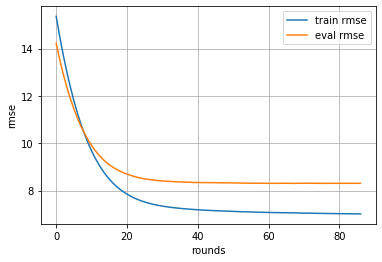

In [33]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

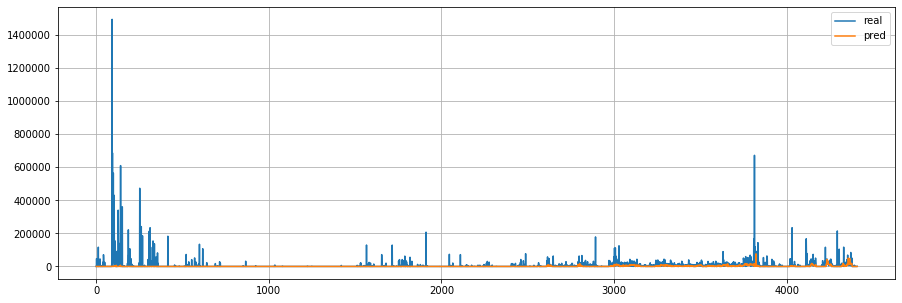

In [34]:
d_pred_log = model.predict(d_val)
d_pred = np.exp(d_pred_log)

#plt.plot(d_pred)
plt.figure(figsize=(15,5))
plt.plot(df_val_Y['Sales'].values, label='real')
plt.plot(d_pred, label='pred')
plt.legend()
plt.grid()
plt.show()

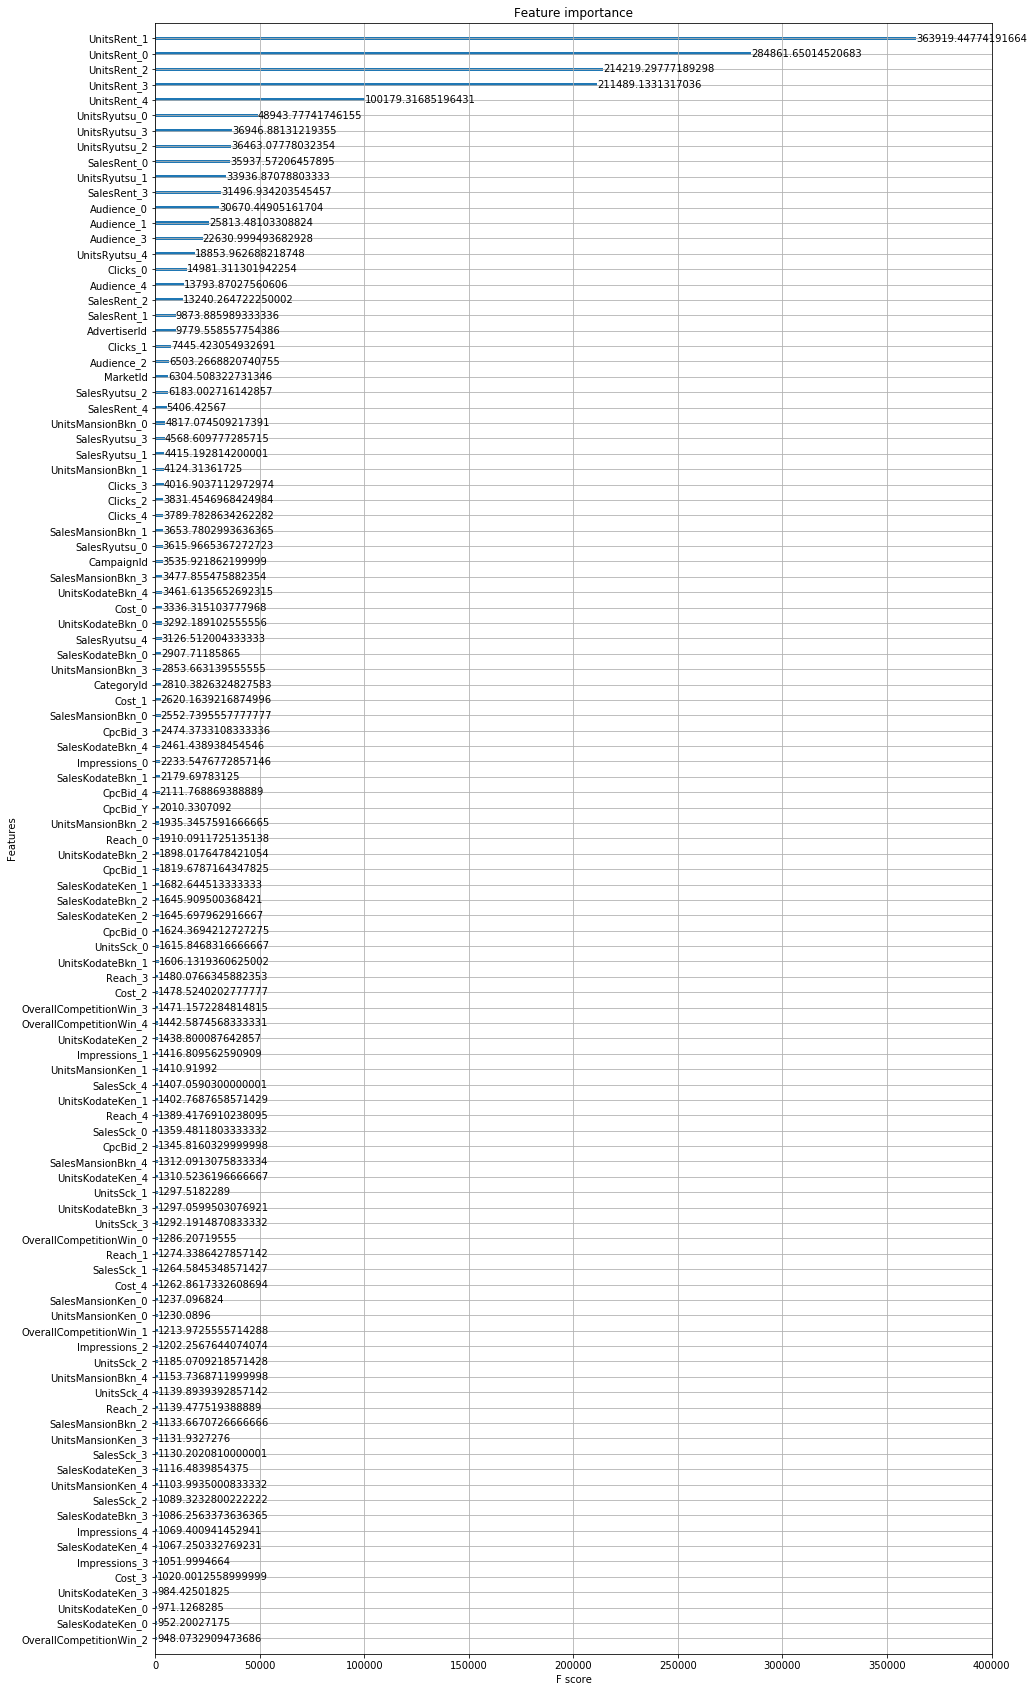

In [35]:
_, ax = plt.subplots(figsize=(15,30))
xgb.plot_importance(model, ax=ax, importance_type='gain')
plt.show()

In [31]:
m = model.get_score(importance_type='gain')
sorted(m, key=lambda x: m[x], reverse=True)

['UnitsRent_0',
 'UnitsRent_1',
 'UnitsRent_2',
 'UnitsRent_4',
 'UnitsRent_3',
 'SalesRent_3',
 'UnitsRyutsu_0',
 'Audience_1',
 'UnitsRyutsu_2',
 'AdvertiserId',
 'Clicks_0',
 'UnitsRyutsu_1',
 'Audience_3',
 'Audience_4',
 'UnitsRyutsu_3',
 'SalesRent_2',
 'SalesRent_0',
 'SalesRent_1',
 'MarketId',
 'CampaignId',
 'UnitsRyutsu_4',
 'SalesMansionBkn_1',
 'SalesMansionBkn_3',
 'Audience_0',
 'SalesMansionBkn_0',
 'Clicks_1',
 'Clicks_4',
 'SalesRent_4',
 'SalesRyutsu_2',
 'UnitsKodateBkn_4',
 'SalesRyutsu_0',
 'UnitsMansionBkn_0',
 'SalesRyutsu_4',
 'CpcBid_Y',
 'SalesKodateBkn_4',
 'Cost_0',
 'UnitsMansionBkn_1',
 'UnitsKodateBkn_0',
 'SalesSck_4',
 'SalesKodateBkn_0',
 'Audience_2',
 'Clicks_2',
 'CategoryId',
 'SalesRyutsu_3',
 'SalesKodateBkn_2',
 'SalesKodateKen_2',
 'UnitsMansionBkn_3',
 'CpcBid_1',
 'SalesKodateBkn_3',
 'CpcBid_4',
 'UnitsKodateBkn_2',
 'SalesKodateBkn_1',
 'SalesRyutsu_1',
 'Cost_2',
 'CpcBid_3',
 'CpcBid_2',
 'Clicks_3',
 'Impressions_0',
 'UnitsKodateKen_2'